### Dal Zotto Luca, Squarcina Giuliano
# HDA Project

### Opportunity Activity Recognition dataset

## Table of contents
##### 1 Dataset loading, first data exploration and missing values handling
&emsp; 1.1 Training set <br>
&emsp; &emsp; 1.1.1 Analysis Missing valules pattern <br>
&emsp; 1.2 Validation set<br>
&emsp; 1.3 Test set<br>
&emsp; 1.4 Test set with noise<br>

##### 2 Gravity filter for accelerometers and Orientation Invariant Coordinate system
&emsp; 2.1 Gravity filter using quaternions<br>
&emsp; 2.2 Orientation invariant coordinate system<br>

##### 3 Statistics of the datasets before segmentation
&emsp; 3.1 Summary of the features<br>
&emsp; 3.2 Class distribution<br>
&emsp; &emsp; 3.2.1 considering the class 'Other'<br>
&emsp; &emsp; 3.2.2 without considering the class 'Other'<br>
&emsp; 3.3 Compute the avg duration of each action<br>

##### 4 Creating datasets
&emsp; 4.1 Automatic feature extraction<br>
&emsp; &emsp; 4.1.1 Dataset 1: all raw features<br>
&emsp; &emsp; 4.1.2 Dataset 2: only lower arm accelerometer and gyroscope features<br>
&emsp; 4.2 Function for Segmentation<br>
&emsp; 4.3 Manual Feature extraction<br>
&emsp; &emsp; 4.3.1 Dataset 3: hand-crafted features, all IMUs<br>
&emsp; &emsp; 4.3.2 Dataset 4: hand-crafted features, only lower arm IMUs<br>

##### 5 Model training
&emsp; 5.1 Dataset 1 - opportunity <br>
&emsp; &emsp; 5.1.1 CNN + RNN model<br>
&emsp; &emsp; 5.1.1 CNN model<br>
&emsp; 5.2 Dataset 2 - opportunity_low<br>
&emsp; &emsp; 5.2.1 CNN + RNN model<br>
&emsp; &emsp; 5.2.2 CNN model<br>
&emsp; 5.3 Dataset 3 - opportunity_manual<br>
&emsp; &emsp; 5.3.1 manual model<br>
&emsp; 5.4 Dataset 4 - opportunity_manual_low<br>
&emsp; &emsp; 5.1.1 manualmodel<br>

##### 6 Comparisons
&emsp; 6.1 CNN + RNN vs CNN only<br>
&emsp; 6.2 Datasets comparisons<br>

In [ ]:
# Import packages

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv1D, Conv2D, GRU
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
import csv
import h5py
import json 
from scipy import stats
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
# import kerastuner as kt
import IPython
import itertools
import missingno as msno
%matplotlib inline

## 0 Point Colaboratory to Google Drive (only for Colab)


In [ ]:
# Point Colaboratory to your Google Drive

from google.colab import drive
drive.mount('/content/gdrive')
datapath = '/content/gdrive/My Drive/Colab Notebooks/dataset'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 1 Dataset loading, first data exploration and missing values handling

In [ ]:
# write path to the folder "OpportunityUCIDataset/dataset"
#datapath='../dataset'
#os.getcwd() 
datapath = 'gdrive/My Drive/Colab Notebooks/dataset' 

'test' is the test set for task B2, while 'test_noise' is the test set for task C.

We may use both of them to evaluate the difference in performance when rotational noise is added and possibly which model is more robust

In [ ]:
files = {'training':   ['/S1-ADL1.dat', '/S1-ADL2.dat', '/S1-ADL3.dat',                                '/S1-Drill.dat',
                        '/S2-ADL1.dat', '/S2-ADL2.dat', '/S2-ADL3.dat',                                '/S2-Drill.dat',
                        '/S3-ADL1.dat', '/S3-ADL2.dat', '/S3-ADL3.dat',                                '/S3-Drill.dat', 
                        '/S4-ADL1.dat', '/S4-ADL2.dat', '/S4-ADL3.dat',                                '/S4-Drill.dat'],
         
         'validation': ['/S1-ADL4.dat', '/S1-ADL5.dat', ], 
         
         'test':       ['/S2-ADL4.dat', '/S2-ADL5.dat', '/S3-ADL4.dat', '/S3-ADL5.dat'],
         
         'test_noise': ['/S4-ADL4.dat', '/S4-ADL5.dat']}

In [ ]:
# Select the variables corresponding to the IMUs located in the motion jacket + the label using the 1-based convention (like in the 'columns_name' txt)

BACK_acc = [38, 39, 40]; BACK_gyro = [41, 42, 43]; BACK_mag = [44, 45, 46]; BACK_q = [47, 48, 49, 50]
RUA_acc = [51, 52, 53]; RUA_gyro = [54, 55, 56]; RUA_mag = [57, 58, 59]; RUA_q = [60, 61, 62, 63]
RLA_acc = [64, 65, 66]; RLA_gyro = [67, 68, 69]; RLA_mag = [70, 71, 72]; RLA_q = [73, 74, 75, 76]
LUA_acc = [77, 78, 79]; LUA_gyro = [80, 81, 82]; LUA_mag = [83, 84, 85]; LUA_q = [86, 87, 88, 89]
LLA_acc = [90, 91, 92]; LLA_gyro = [93, 94, 95]; LLA_mag = [96, 97, 98]; LLA_q = [99, 100, 101, 102]
LABEL = [250]

BACK = BACK_acc + BACK_gyro + BACK_mag + BACK_q
RUA = RUA_acc + RUA_gyro + RUA_mag + RUA_q 
RLA = RLA_acc + RLA_gyro + RLA_mag + RLA_q
LUA = LUA_acc + LUA_gyro + LUA_mag + LUA_q
LLA = LLA_acc + LLA_gyro + LLA_mag + LLA_q

We may consider a dataset with all the IMUs of the motion jacket and a dataset with just the IMUs located in the RLA and LLA (right/left lower arms).

In [ ]:
jacket = BACK + RUA + RLA + LUA + LLA + LABEL
jacket = [x-1 for x in jacket] # change the column number to be consistent with the 0-based convention(like in Python)

column_names_jacket = [
            'BACK accX', 'BACK accY', 'BACK accZ', 'BACK gyroX', 'BACK gyroY', 'BACK gyroZ', 'BACK magneticX', 'BACK magneticY', 'BACK magneticZ', 'BACK q1', 'BACK q2', 'BACK q3', 'BACK q4',
            'RUA accX', 'RUA accY', 'RUA accZ', 'RUA gyroX', 'RUA gyroY', 'RUA gyroZ', 'RUA magneticX', 'RUA magneticY', 'RUA magneticZ', 'RUA q1', 'RUA q2', 'RUA q3', 'RUA q4',
            'RLA accX', 'RLA accY', 'RLA accZ', 'RLA gyroX', 'RLA gyroY', 'RLA gyroZ', 'RLA magneticX', 'RLA magneticY', 'RLA magneticZ', 'RLA q1', 'RLA q2', 'RLA q3', 'RLA q4',
            'LUA accX', 'LUA accY', 'LUA accZ', 'LUA gyroX', 'LUA gyroY', 'LUA gyroZ', 'LUA magneticX', 'LUA magneticY', 'LUA magneticZ', 'LUA q1', 'LUA q2', 'LUA q3', 'LUA q4',
            'LLA accX', 'LLA accY', 'LLA accZ', 'LLA gyroX', 'LLA gyroY', 'LLA gyroZ', 'LLA magneticX', 'LLA magneticY', 'LLA magneticZ', 'LLA q1', 'LLA q2', 'LLA q3', 'LLA q4',
            'label']

lower_arm = RLA + LLA + LABEL
lower_arm = [x-1 for x in lower_arm]  # change the column number to be consistent with the 0-based convention(like in Python)

column_names_lower_arm = [
                'RLA accX', 'RLA accY', 'RLA accZ', 'RLA gyroX', 'RLA gyroY', 'RLA gyroZ', 'RLA magneticX', 'RLA magneticY', 'RLA magneticZ', 'RLA q1', 'RLA q2', 'RLA q3', 'RLA q4',
                'LLA accX', 'LLA accY', 'LLA accZ', 'LLA gyroX', 'LLA gyroY', 'LLA gyroZ', 'LLA magneticX', 'LLA magneticY', 'LLA magneticZ', 'LLA q1', 'LLA q2', 'LLA q3', 'LLA q4',
                'label']

Define a function that generates the datasets combining the available files (runs)

In [ ]:
def read_files(datapath, filelist, subset, cols, column_names, stat = False):
    
    data = pd.DataFrame(columns = column_names)
    lengths = []
    
    for s in files[subset]:
        d = pd.read_csv(datapath + s, sep=" ", header = None, usecols = cols, names = column_names)
        d.iloc[:,:-1] = d.iloc[:,:-1] / 1000
        
        if stat: lengths.append(d.shape[0] - d.isnull().any(axis=1).sum()) # length of this run (exluding NAs)
        
        data = pd.concat([data, d])
    
    
    if stat: 
        stats = pd.DataFrame({'total_length' : np.sum(lengths), 'avg_length' : np.mean(lengths), 'min_length' : np.min(lengths), 'max_length' : np.max(lengths)}, index = ['stats'] )
        return data, stats
    
    return data

### 1.1 Training set

In [ ]:
training, train_stats = read_files(datapath, files, 'training', jacket, column_names_jacket, stat = True)

In [ ]:
# Compute the dimension of the training set
training.shape

(634798, 66)

In [ ]:
# First rows of the dataset
training.head()

BACK accX  BACK accY  BACK accZ  BACK gyroX  ...  LLA q2  LLA q3  LLA q4  label
0     -0.983     -0.199      0.119      -0.166  ...  -0.098   0.641  -0.172      0
1     -0.986     -0.220      0.114      -0.170  ...  -0.101   0.642  -0.169      0
2     -0.987     -0.227      0.112      -0.169  ...  -0.105   0.643  -0.165      0
3     -0.974     -0.209      0.104      -0.100  ...  -0.109   0.644  -0.162      0
4     -0.966     -0.199      0.104      -0.085  ...  -0.112   0.645  -0.158      0

[5 rows x 66 columns]

In [ ]:
# Missing values
print("Number of missing values in the dataset for each variable: \n{}".
     format(training.isna().sum()))

Number of missing values in the dataset for each variable: 
BACK accX     12287
BACK accY     12287
BACK accZ     12287
BACK gyroX    12287
BACK gyroY    12287
              ...  
LLA q1        12287
LLA q2        12287
LLA q3        12287
LLA q4        12287
label             0
Length: 66, dtype: int64


In [ ]:
# Percentage of recordings with missing values
print('Recordings with missing values:', np.round(100 * training.isnull().any(axis=1).sum() / training.shape[0], 2), '%')

Recordings with missing values: 1.94 %


We did not expect to have missing values, since the sensors of the motion jacket do not use wireless technology. 

It's strange that all the variables considered have the same number of NAs. Let's study their distribution.

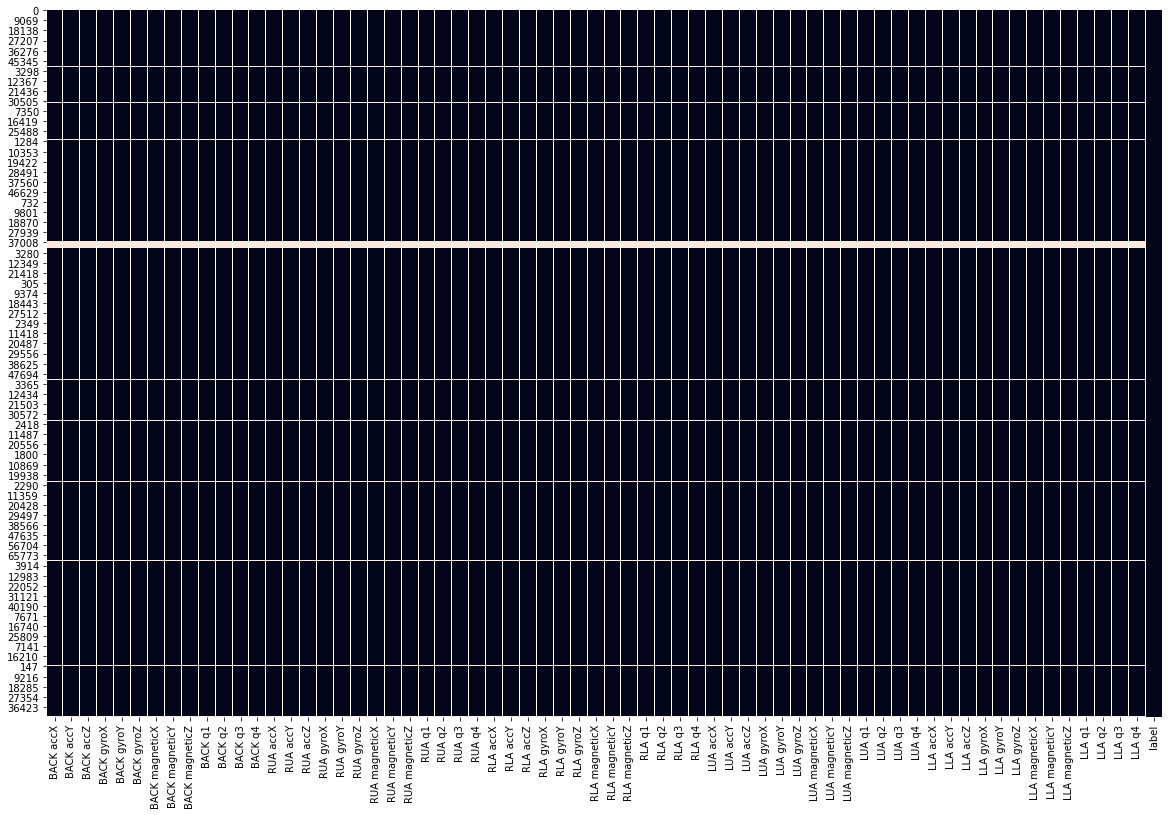

In [ ]:
fig, ax = plt.subplots(figsize=(20,13))
_ = sns.heatmap(training.isnull(), cbar=False)

From this plot it is possible to see that the missing values occour at the end of some runs, and they are shared by all the considered variables.

This latter aspect is confirmed by the following plot

https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj

https://towardsdatascience.com/visualize-missing-values-with-missingno-ad4d938b00a1

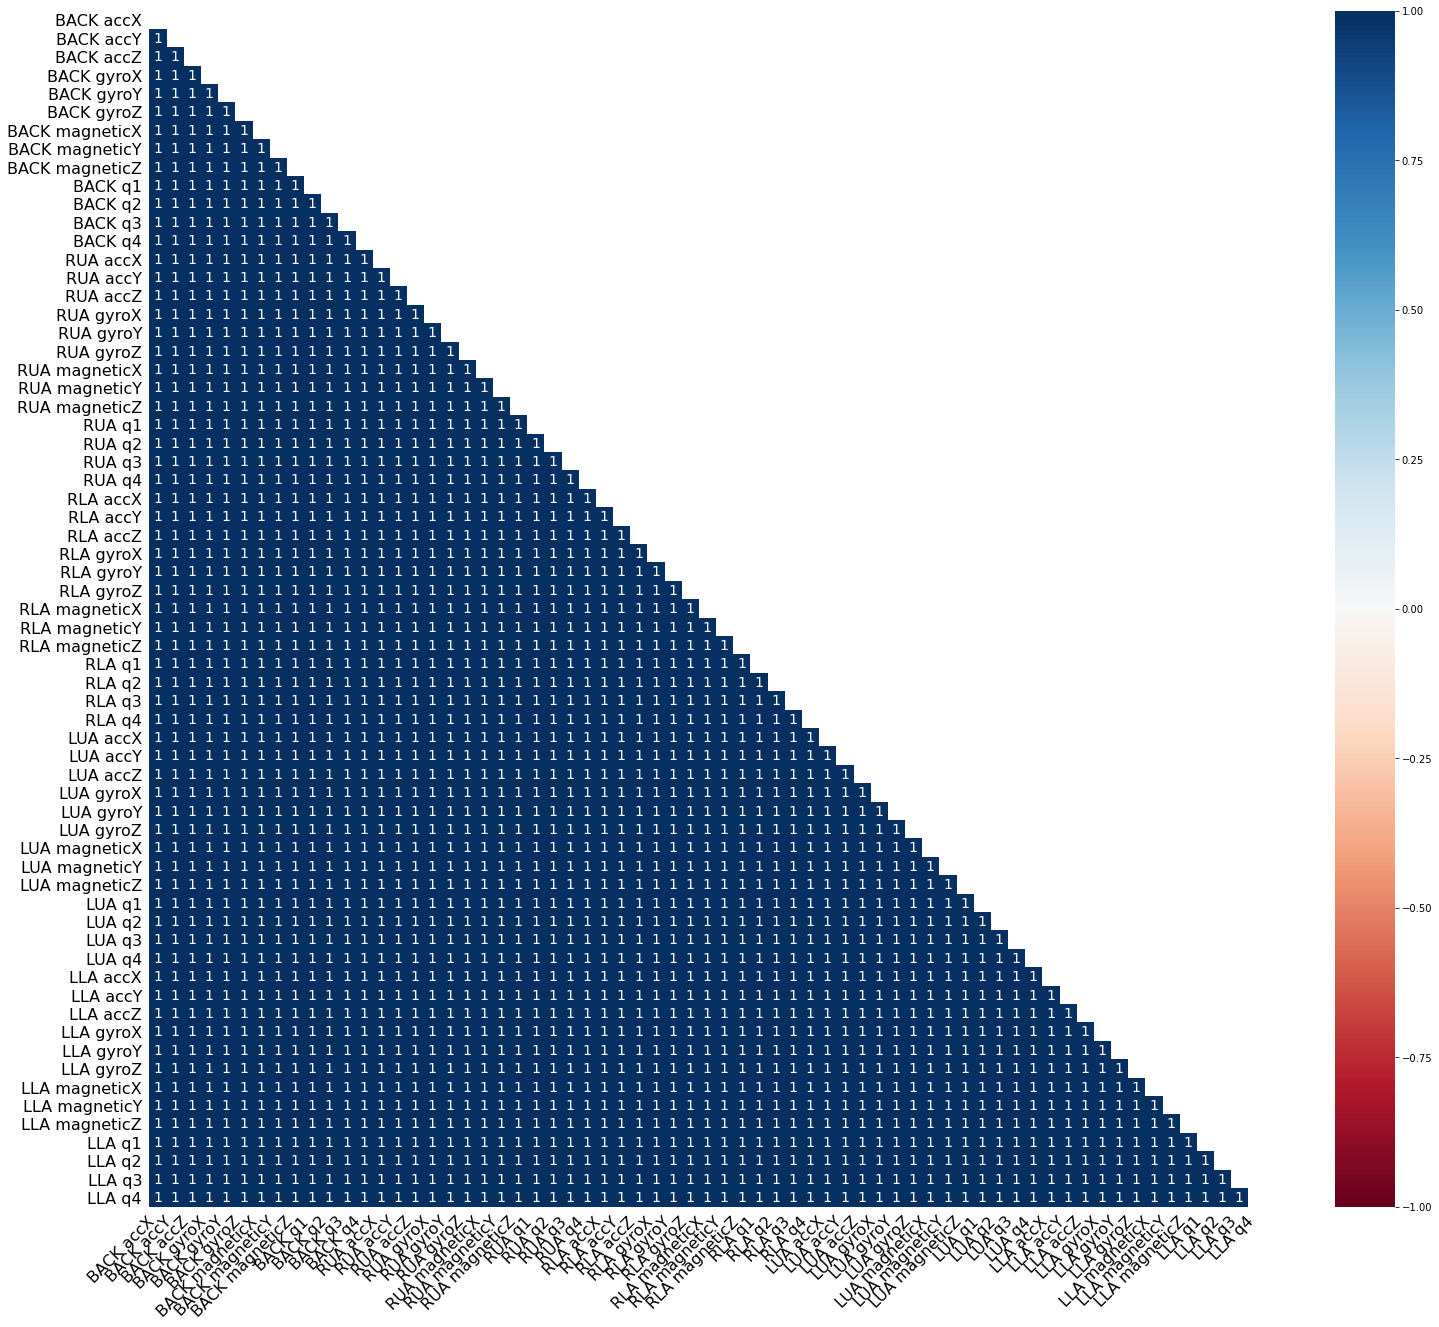

In [ ]:
msno.heatmap(training, figsize = (25,22))

#### 1.1.1 Analysis Missing valules pattern

We try to give an explanation of this phenomenon considering all the variables of just one run (S1-ADL1), and looking at missing values patterns

In [ ]:
d1 = pd.read_csv(datapath + '/S1-ADL1.dat', sep=" ", header = None)
d1.head()

0      1      2      3     4       5    ...  244  245  246  247  248  249
0    0   87.0  975.0 -287.0  11.0  1001.0  ...    0    0    0    0    0    0
1   33  124.0  978.0 -389.0  -7.0  1014.0  ...    0    0    0    0    0    0
2   67  102.0  996.0 -440.0 -49.0  1024.0  ...    0    0    0    0    0    0
3  100   59.0  861.0 -384.0  -9.0  1023.0  ...    0    0    0    0    0    0
4  133  119.0  946.0 -426.0 -22.0  1026.0  ...    0    0    0    0    0    0

[5 rows x 250 columns]

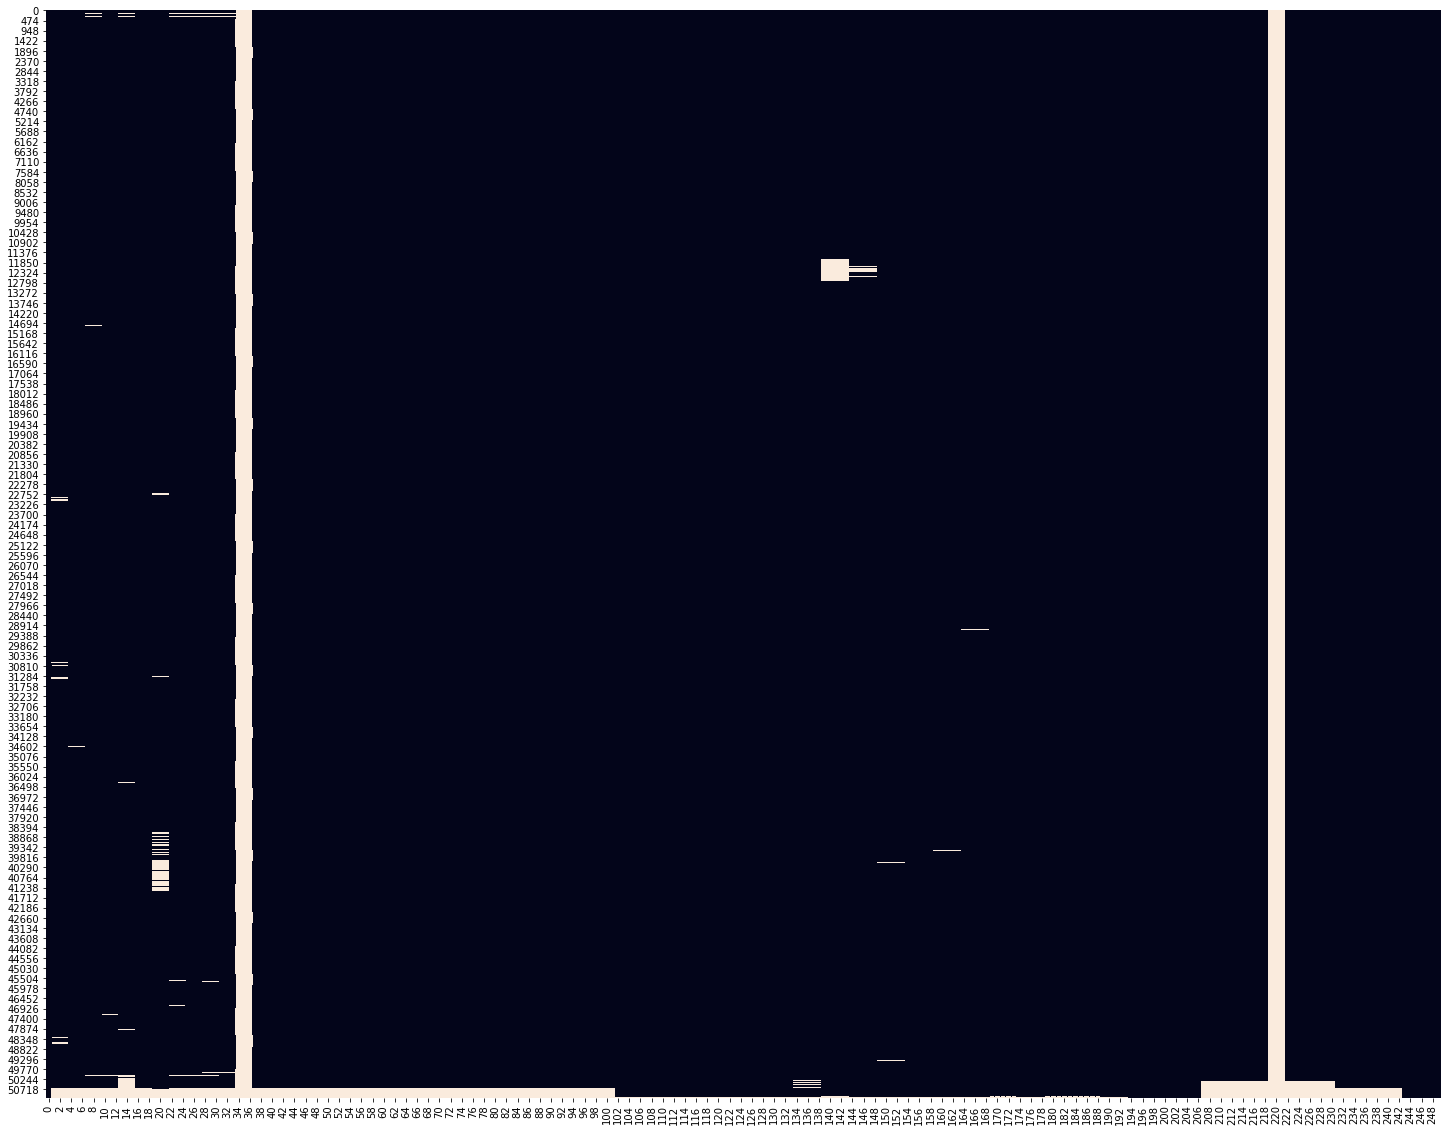

In [ ]:
fig, ax = plt.subplots(figsize=(25,20))
_ = sns.heatmap(d1.isnull(), cbar=False)

It is possible to observe that the recordings related to the shoes and some objects have a small number of missing values, 
while the activity of the sensors related to the jacket is stopped in advance.

This is why in our dataset we have some missing values (all at the end of some runs) even though the motion jacket uses wired connections.

For this reason, we will not recover these values through imputation but we will simply drop the recordings having missing values.

In [ ]:
# Remove the observations with missing values
training = training.dropna()

# Compute the dimension of the set
training.shape

(622511, 66)

In [ ]:
print('Statistics of the considered runs neglecting missing values')
train_stats

Statistics of the considered runs neglecting missing values


total_length  avg_length  min_length  max_length
stats        622511  38906.9375       24550       70401

Let's do the same for validation and test sets

### 1.2 Validation set

In [ ]:
validation, valid_stats = read_files(datapath, files, 'validation', jacket, column_names_jacket, stat = True)

In [ ]:
# Percentage of recordings with missing values
print('Recordings with missing values:', np.round(100 * validation.isnull().any(axis=1).sum() / validation.shape[0],2), '%')

Recordings with missing values: 0.53 %


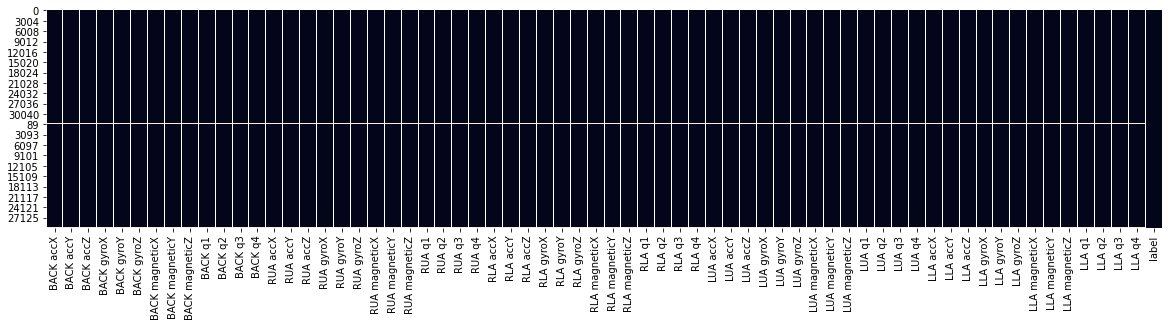

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))
_ = sns.heatmap(validation.isnull(), cbar=False)

Even in this case it's clear that the missing values occur in blocks at the end of the runs.

In [ ]:
# Remove the observations with missing values
validation = validation.dropna()

# Compute the dimension of the set
validation.shape

(62747, 66)

In [ ]:
print('Statistics of the considered runs neglecting missing values')
valid_stats

Statistics of the considered runs neglecting missing values


total_length  avg_length  min_length  max_length
stats         62747     31373.5       30048       32699

### 1.3 Test set

In [ ]:
test, test_stats = read_files(datapath, files, 'test', jacket, column_names_jacket, stat = True)

In [ ]:
# Percentage of recordings with missing values
print('Recordings with missing values:', np.round(100 * test.isnull().any(axis=1).sum() / test.shape[0],2), '%')

Recordings with missing values: 0.97 %


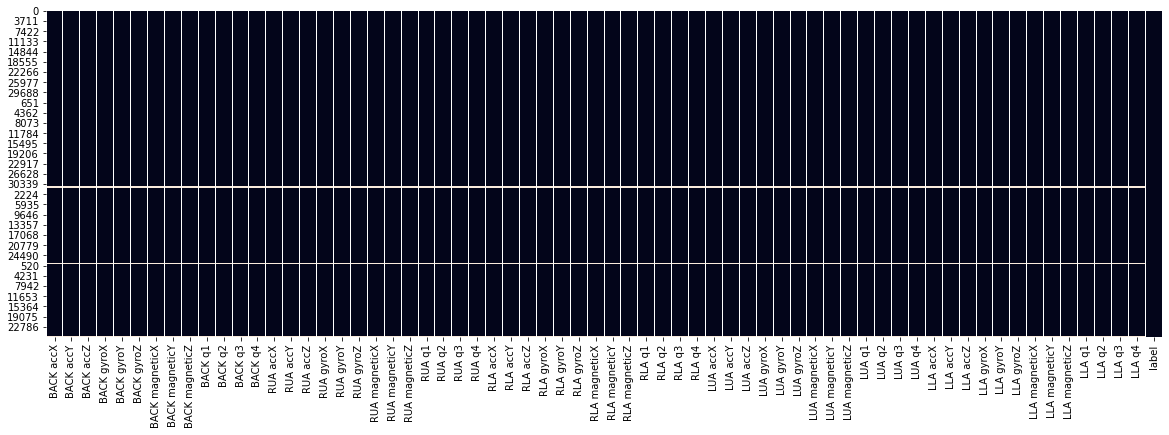

In [ ]:
# Check missing values' pattern
fig, ax = plt.subplots(figsize=(20,6))
_ = sns.heatmap(test.isnull(), cbar=False)

Even in this case it's clear that the missing values occur in blocks at the end of some runs.

In [ ]:
# Remove the observations with missing values
test = test.dropna()

# Compute the dimension of the set
test.shape

(117601, 66)

In [ ]:
print('Statistics of the considered runs neglecting missing values')
test_stats

Statistics of the considered runs neglecting missing values


total_length  avg_length  min_length  max_length
stats        117601    29400.25       26204       32543

### 1.4 Test set with noise

In [ ]:
test_noise, test_noise_stats = read_files(datapath, files, 'test_noise', jacket, column_names_jacket, stat = True)

In [ ]:
# Percentage of recordings with missing values
print('Recordings with missing values:', np.round(100 * test_noise.isnull().any(axis=1).sum() / test.shape[0], 2), '%')

Recordings with missing values: 1.1 %


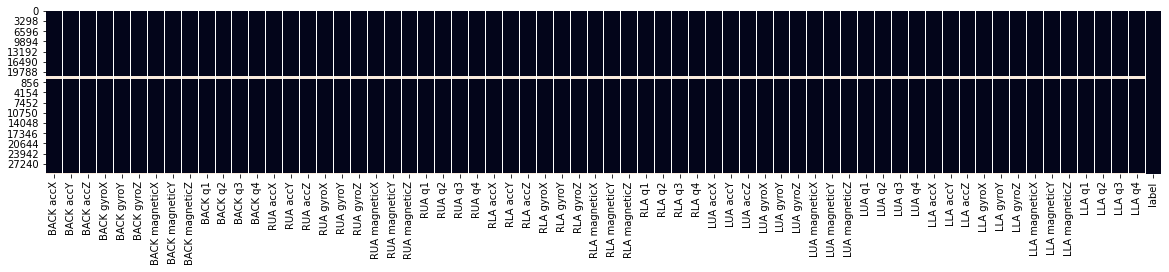

In [ ]:
# Check missing values' pattern
fig, ax = plt.subplots(figsize=(20,3))
_ = sns.heatmap(test_noise.isnull(), cbar=False)

Even in this case it's clear that the missing values occur in blocks at the end of some runs.

In [ ]:
# Remove the observations with missing values
test_noise = test_noise.dropna()

# Compute the dimension of the set
test_noise.shape

(51465, 66)

In [ ]:
print('Statistics of the considered runs neglecting missing values')
test_noise_stats

Statistics of the considered runs neglecting missing values


total_length  avg_length  min_length  max_length
stats         51465     25732.5       21216       30249

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 2 Gravity filter for accelerometers and Orientation Invariant Coordinate system

### 2.1 Gravity filter using quaternions:

- Keeping a Good Attitude: A Quaternion-Based Orientation
Filter for IMUs and MARGs
Roberto G. Valenti 1
Ivan Dryanovski 2 and Jizhong Xiao 1
file:///C:/Users/Lucadz/Documents/HDAproject/quaternions.pdf

- https://stackoverflow.com/questions/18252692/gravity-compensation-in-accelerometer-data

- http://www.varesano.net/blog/fabio/simple-gravity-compensation-9-dom-imus

- https://www.weizmann.ac.il/sci-tea/benari/sites/sci-tea.benari/files/uploads/softwareAndLearningMaterials/quaternion-tutorial-2-0-1.pdf

### 2.2 Orientation invariant coordinate system: 

- 'IDNet: Smartphone-based gait recognition with convolutional neural networks'. Matteo Gadaleta, Michele Rossi

Let's try to plot some accelerometer recordings 

In [ ]:
d = pd.read_csv(datapath + '/S1-ADL1.dat', sep=" ", header = None, usecols = jacket, names = column_names_jacket)/1000

In [ ]:
d.head()

BACK accX  BACK accY  BACK accZ  BACK gyroX  ...  LLA q2  LLA q3  LLA q4  label
0     -0.983     -0.199      0.119      -0.166  ...  -0.098   0.641  -0.172    0.0
1     -0.986     -0.220      0.114      -0.170  ...  -0.101   0.642  -0.169    0.0
2     -0.987     -0.227      0.112      -0.169  ...  -0.105   0.643  -0.165    0.0
3     -0.974     -0.209      0.104      -0.100  ...  -0.109   0.644  -0.162    0.0
4     -0.966     -0.199      0.104      -0.085  ...  -0.112   0.645  -0.158    0.0

[5 rows x 66 columns]

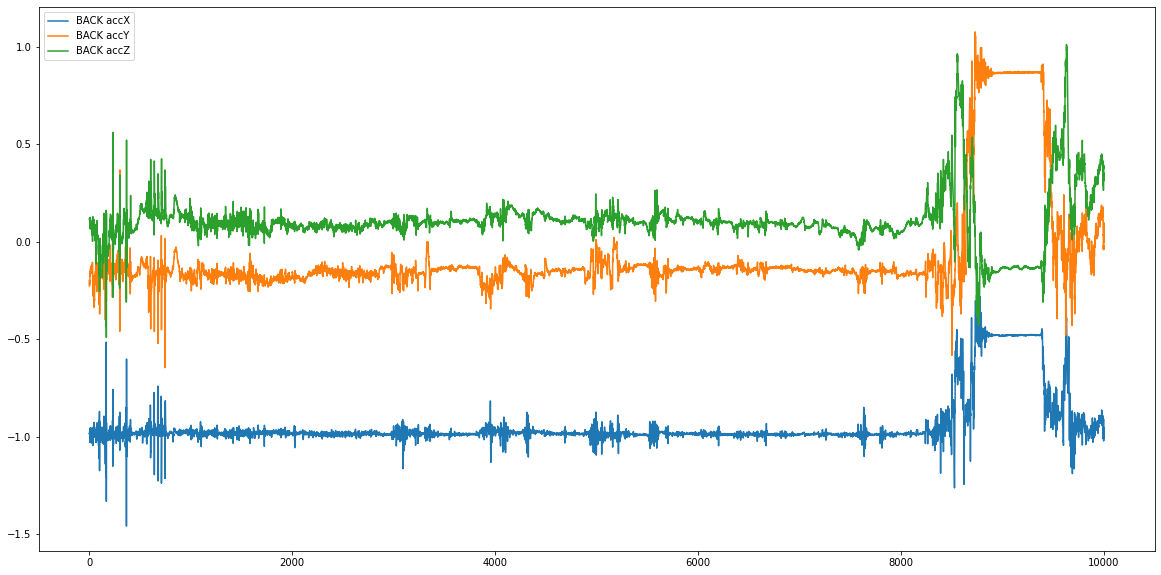

In [ ]:
# By way of illustration, let's plot just the accelerometer signals of the BACK sensor
fig = d.iloc[:10000,:3].plot(figsize = (20,10))#(subplots = True)

It is clear that the mean of these signals is not around 0 but it is shifted.

This is due to the constant gravity acceleration, that is not useful for our purposes thus is should be filtered

In [ ]:
# select the quaternions
q = d.iloc[:, 9:13]
print(q.shape)
q.head()

(51116, 4)


BACK q1  BACK q2  BACK q3  BACK q4
0    0.617   -0.475    0.457    0.430
1    0.615   -0.476    0.457    0.432
2    0.613   -0.477    0.456    0.434
3    0.611   -0.478    0.456    0.436
4    0.610   -0.478    0.456    0.437

In [ ]:
q1 = q.iloc[:,0]
q2 = q.iloc[:,1]
q3 = q.iloc[:,2]
q4 = q.iloc[:,3]

In [ ]:
# get the coordinates of the gravity acceleration wrt the sensors' frames (see sources for the mathematical derivation of these formulae)
g1 = np.array(2 * (q2 * q4 - q1 * q3)).reshape(-1,1)
g2 = np.array(2 * (q1 * q2 + q3 * q4)).reshape(-1,1)
g3 = np.array(q1 * q1 - q2 * q2 - q3 * q3 + q4 * q4).reshape(-1,1)

In [ ]:
g = np.concatenate((g1, g2, g3),axis=1)
g.shape

(51116, 3)

In [ ]:
a = d.iloc[:,:3]
print(a.shape)
a.head()

(51116, 3)


BACK accX  BACK accY  BACK accZ
0     -0.983     -0.199      0.119
1     -0.986     -0.220      0.114
2     -0.987     -0.227      0.112
3     -0.974     -0.209      0.104
4     -0.966     -0.199      0.104

In [ ]:
# Let's filter the gravity
d.iloc[:,:3] = np.array(d.iloc[:,:3]) - g

Let's see now how the filtered signal looks like

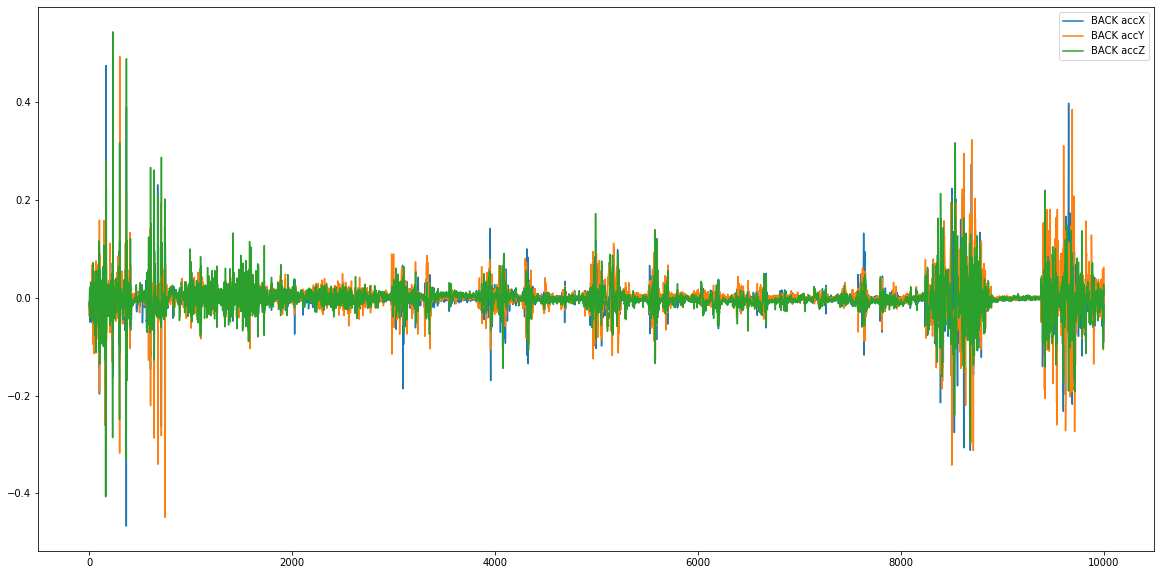

In [ ]:
fig = d.iloc[:10000,:3].plot(figsize = (20,10))#(subplots = True)

Now the signals have 0 mean, and all the values recorded now are due to human activity 

Let's filter in this way all the datasets and also let's move into a Orientation Invariant Coordinate system:
It will have the z-axis alligned with the gravity, and the other two axis mutually orthogonal

(see 'IDNet: Smartphone-based gait recognition with convolutional neural networks'. Matteo Gadaleta, Michele Rossi)

In [ ]:
# auxiliary function that project a triplet into the invariant coordinate system given by the versors g, first, second
def orientation_invariant_frame(a, g, first, second, acc = False):
    x = []
    y = []
    z = []
    for i in range(g.shape[0]):
        
        x.append(np.dot(a[i],first[i])/np.sqrt(np.dot(first[i], first[i])))
        y.append(np.dot(a[i],second[i])/np.sqrt(np.dot(second[i], second[i])))
        
        if acc:
            z.append(np.dot(a[i],g[i])/np.sqrt(np.dot(g[i], g[i]))-1)
        else:
            z.append(np.dot(a[i],g[i])/np.sqrt(np.dot(g[i], g[i])))

    return np.array((x, y, z))

In [ ]:
def remove_gravity_and_rotate_frame(s):
    
    for sensor in ['BACK', 'RUA', 'RLA', 'LUA', 'LLA']:
    
        list_q = [sensor + qi for qi in [' q1', ' q2', ' q3', ' q4']]
        list_acc = [sensor + acci for acci in [' accX', ' accY', ' accZ']]
        list_gyro = [sensor + gyro for gyro in [' gyroX', ' gyroY', ' gyroZ']]
        
        q = s.loc[:, list_q]
        
        q1 = q.iloc[:,0]; q2 = q.iloc[:,1]; q3 = q.iloc[:,2]; q4 = q.iloc[:,3]

        # get expected direction of gravity
        g1 = np.array(2 * (q2 * q4 - q1 * q3))
        g2 = np.array(2 * (q1 * q2 + q3 * q4))
        g3 = np.array(q1 * q1 - q2 * q2 - q3 * q3 + q4 * q4)
        g = np.array((g1, g2, g3)).T
        
        x1 = np.array(q1 * q1 + q2 * q2 - q3 * q3 - q4 * q4)
        x2 = np.array(2 * (q2 * q3 - q1 * q4))
        x3 = np.array(2 * (q1 * q3 + q2 * q4))
        first = np.array((x1, x2, x3)).T
        
        y1 = np.array(2 * (q1 * q4 + q2 * q3))
        y2 = np.array(q1 * q1 - q2 * q2 + q3 * q3 - q4 * q4)
        y3 = np.array(2 * (q3 * q4 - q1 * q2))
        second = np.array((y1, y2, y3)).T
        
        new_acc = orientation_invariant_frame(np.array(s.loc[:, list_acc]), g, first, second, acc = True).T
        new_gyro = orientation_invariant_frame(np.array(s.loc[:, list_gyro]), g, first, second).T
        
        s.loc[:, list_acc] = new_acc
        s.loc[:, list_gyro] = new_gyro

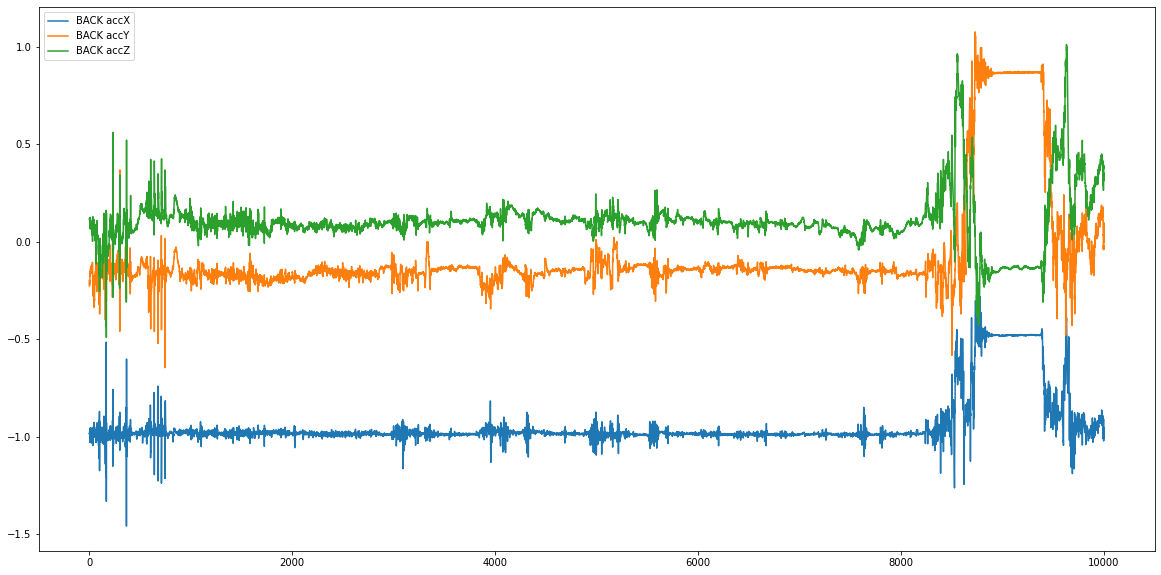

In [ ]:
fig = training.iloc[:10000,0:3].plot(figsize = (20,10))#(subplots = True)

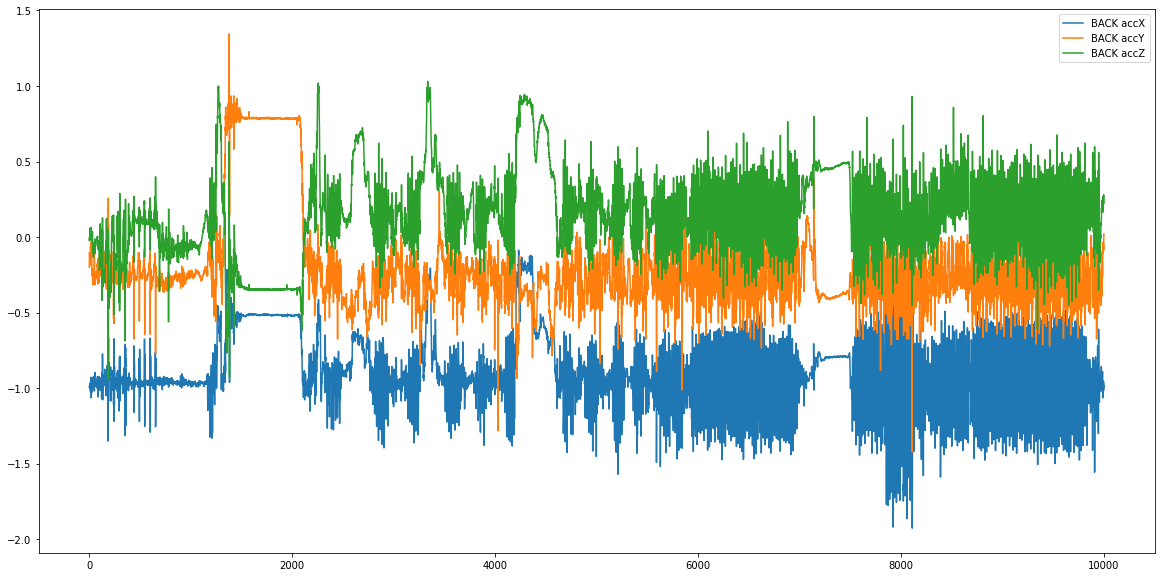

In [ ]:
fig = validation.iloc[:10000,0:3].plot(figsize = (20,10))#(subplots = True)

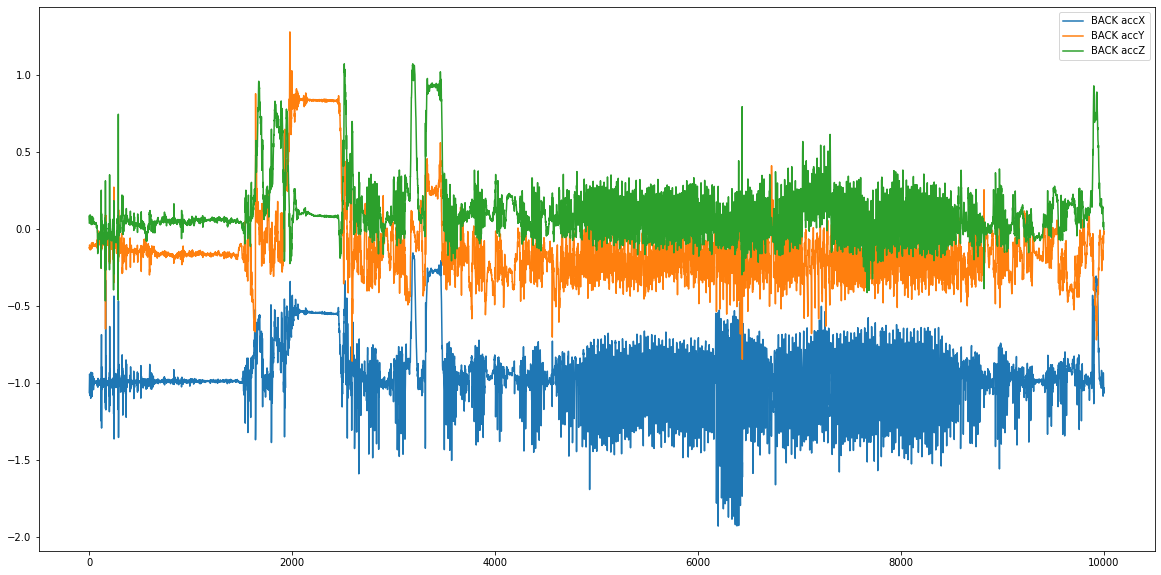

In [ ]:
fig = test.iloc[:10000,0:3].plot(figsize = (20,10))#(subplots = True)

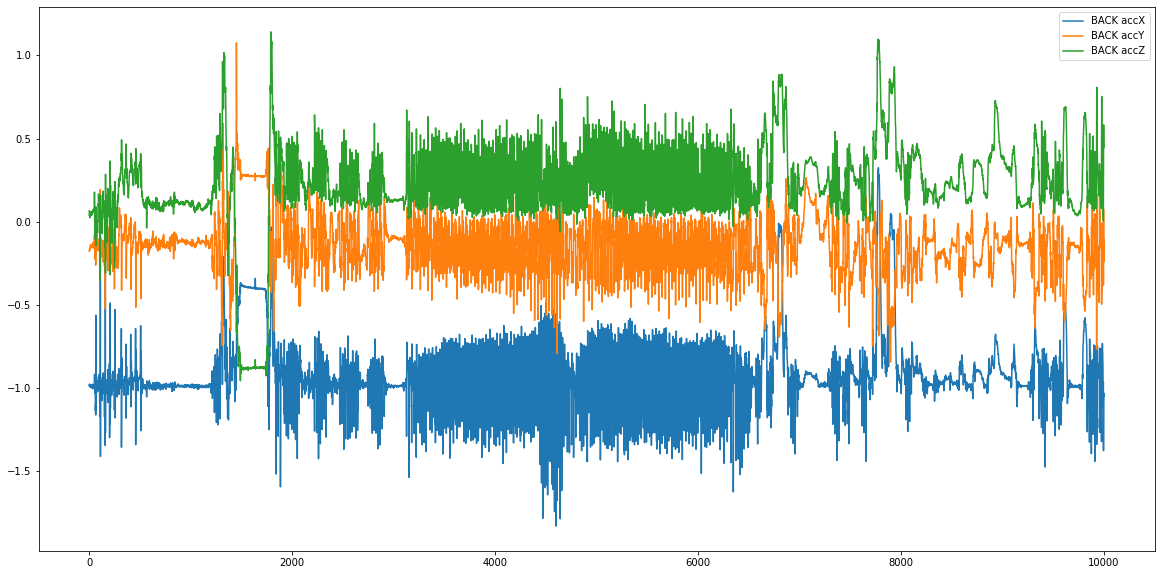

In [ ]:
fig = test_noise.iloc[:10000,0:3].plot(figsize = (20,10))#(subplots = True)

In [ ]:
# sta cella ci mette un bel po'...  Θ(15 minuti)
remove_gravity_and_rotate_frame(training)
remove_gravity_and_rotate_frame(validation)
remove_gravity_and_rotate_frame(test)
remove_gravity_and_rotate_frame(test_noise)

In [ ]:
training.head()

BACK accX  BACK accY  BACK accZ  BACK gyroX  ...  LLA q2  LLA q3  LLA q4  label
0   0.001535  -0.013931   0.009878    0.023832  ...  -0.098   0.641  -0.172      0
1   0.023406  -0.021437   0.016162    0.009908  ...  -0.101   0.642  -0.169      0
2   0.031474  -0.024075   0.018171   -0.012122  ...  -0.105   0.643  -0.165      0
3   0.018596  -0.026240   0.001069    0.023334  ...  -0.109   0.644  -0.162      0
4   0.012440  -0.023770  -0.008610   -0.000102  ...  -0.112   0.645  -0.158      0

[5 rows x 66 columns]

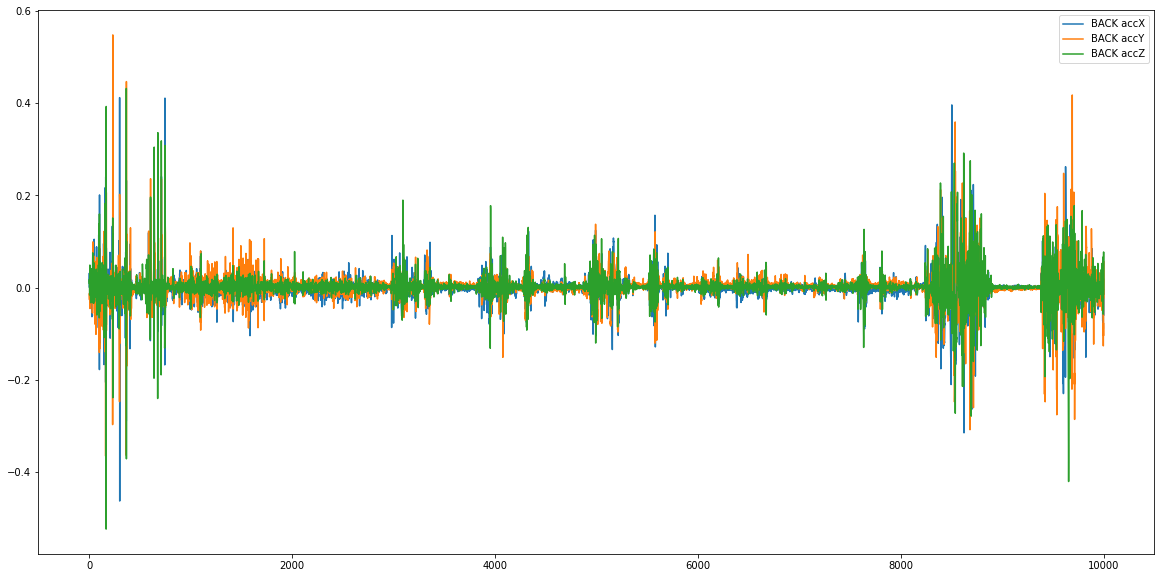

In [ ]:
fig = training.iloc[:10000,0:3].plot(figsize = (20,10))#(subplots = True)

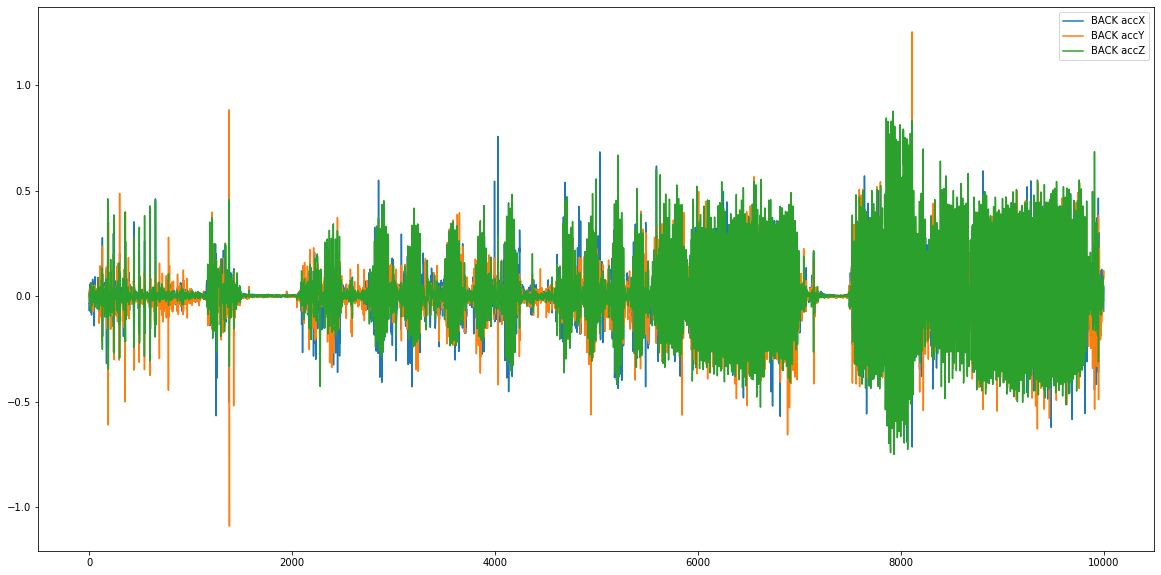

In [ ]:
fig = validation.iloc[:10000,0:3].plot(figsize = (20,10))#(subplots = True)

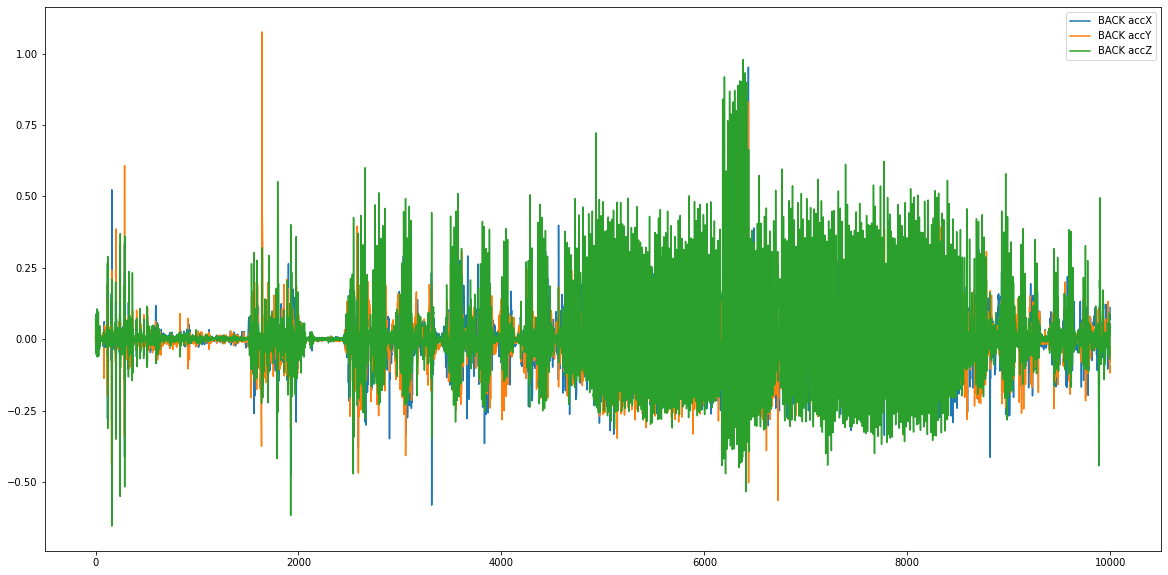

In [ ]:
fig = test.iloc[:10000,0:3].plot(figsize = (20,10))#(subplots = True)

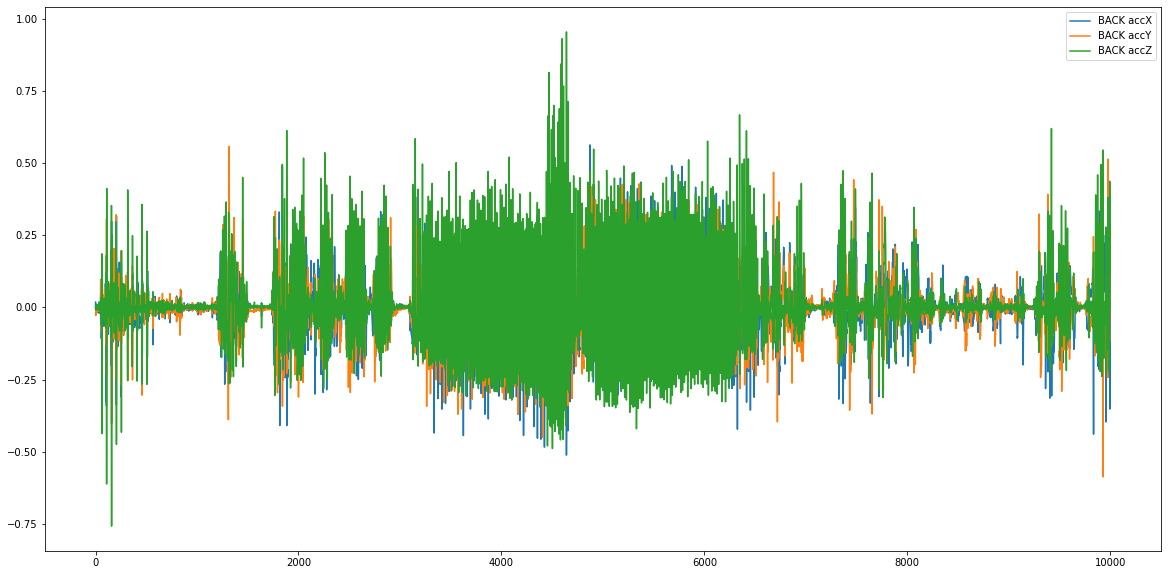

In [ ]:
fig = test_noise.iloc[:10000,0:3].plot(figsize = (20,10))#(subplots = True)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3 Statistics of the datasets before segmentation

### 3.1 Summary of the features

In [ ]:
training.describe()

BACK accX      BACK accY  ...         LLA q3         LLA q4
count  622511.000000  622511.000000  ...  622511.000000  622511.000000
mean        0.000084       0.001617  ...       0.036279      -0.011055
std         0.076579       0.077748  ...       0.550744       0.481701
min        -1.137200      -1.523186  ...      -0.988000      -0.966000
25%        -0.024883      -0.024535  ...      -0.550000      -0.467000
50%        -0.000165       0.001677  ...       0.094000      -0.020000
75%         0.025178       0.027673  ...       0.591000       0.445000
max         1.502098       1.614262  ...       0.967000       0.918000

[8 rows x 65 columns]

In [ ]:
validation.describe()

BACK accX     BACK accY  ...        LLA q3        LLA q4
count  62747.000000  62747.000000  ...  62747.000000  62747.000000
mean       0.001317      0.002099  ...      0.032887     -0.038780
std        0.082100      0.083713  ...      0.513733      0.549503
min       -1.058361     -1.089526  ...     -0.931000     -0.913000
25%       -0.020884     -0.021651  ...     -0.527000     -0.581000
50%        0.001665      0.002511  ...      0.069000     -0.138000
75%        0.024548      0.026139  ...      0.553000      0.513000
max        0.855639      1.252247  ...      0.938000      0.934000

[8 rows x 65 columns]

In [ ]:
test.describe()

BACK accX      BACK accY  ...         LLA q3         LLA q4
count  117601.000000  117601.000000  ...  117601.000000  117601.000000
mean        0.000648       0.000422  ...       0.011953      -0.002811
std         0.069388       0.070956  ...       0.569358       0.485394
min        -1.130180      -0.663747  ...      -0.962000      -0.910000
25%        -0.019195      -0.021431  ...      -0.587000      -0.470000
50%         0.000711      -0.000023  ...       0.051000      -0.014000
75%         0.021145       0.022043  ...       0.587000       0.480000
max         0.952485       1.075768  ...       0.961000       0.966000

[8 rows x 65 columns]

In [ ]:
test_noise.describe()

BACK accX     BACK accY  ...        LLA q3        LLA q4
count  51465.000000  51465.000000  ...  51465.000000  51465.000000
mean      -0.000714      0.000080  ...      0.092648     -0.057461
std        0.085620      0.080261  ...      0.545421      0.475835
min       -0.714328     -0.667101  ...     -0.963000     -0.897000
25%       -0.034789     -0.031731  ...     -0.471000     -0.479000
50%       -0.000687      0.000638  ...      0.183000     -0.177000
75%        0.033963      0.031032  ...      0.634000      0.411000
max        0.599519      0.623319  ...      0.945000      0.859000

[8 rows x 65 columns]

In [ ]:
print ("Training set shape: " + str(training.shape))
print ("Validation set shape: " + str(validation.shape))
print ("Test set shape: " + str(test.shape))
print ("Noisy test set shape: " + str(test_noise.shape))

Training set shape: (622511, 66)
Validation set shape: (62747, 66)
Test set shape: (117601, 66)
Noisy test set shape: (51465, 66)


### 3.2 Class distribution
#### 3.2.1 considering the class 'Other'

In [ ]:
# from 'label_legend' txt file
label_map = [
            (0,      'Other'),
            (406516, 'Open Door 1'),
            (406517, 'Open Door 2'),
            (404516, 'Close Door 1'),
            (404517, 'Close Door 2'),
            (406520, 'Open Fridge'),
            (404520, 'Close Fridge'),
            (406505, 'Open Dishwasher'),
            (404505, 'Close Dishwasher'),
            (406519, 'Open Drawer 1'),
            (404519, 'Close Drawer 1'),
            (406511, 'Open Drawer 2'),
            (404511, 'Close Drawer 2'),
            (406508, 'Open Drawer 3'),
            (404508, 'Close Drawer 3'),
            (408512, 'Clean Table'),
            (407521, 'Drink from Cup'),
            (405506, 'Toggle Switch')
        ]
dictio = {x[0]: i for i, x in enumerate(label_map) if i!=0}
# it creates the dictionary {406516:1, ...}
id2label = [x[1] for x in label_map]
# it creates the list ['other', 'Open Door1', ...]

In [ ]:
# check the class distributions in y_train, y_valid, y_test
y_valid = validation.label.replace(dictio)
freq_y_valid = y_valid.value_counts().sort_index()/y_valid.shape[0]

y_train = training.label.replace(dictio)
freq_y_train = y_train.value_counts().sort_index()/y_train.shape[0]

y_test = test.label.replace(dictio)
freq_y_test = y_test.value_counts().sort_index()/y_test.shape[0]

y_test_noise = test_noise.label.replace(dictio)
freq_y_test_noise = y_test_noise.value_counts().sort_index()/y_test_noise.shape[0]

In [ ]:
freq_df = pd.DataFrame([freq_y_train, freq_y_valid, freq_y_test, freq_y_test_noise]).transpose()
freq_df.index = id2label; 
freq_df.columns = ['training set','validation set','test set', 'test set noise']
freq_df

training set  validation set  test set  test set noise
Other                 0.683450        0.794476  0.831124        0.808355
Open Door 1           0.018649        0.015188  0.005757        0.016827
Open Door 2           0.019537        0.012813  0.009702        0.011037
Close Door 1          0.017945        0.013068  0.006020        0.013291
Close Door 2          0.018816        0.010502  0.008410        0.007345
Open Fridge           0.021209        0.013929  0.023291        0.018692
Close Fridge          0.019468        0.016638  0.016182        0.020480
Open Dishwasher       0.015421        0.006024  0.010119        0.004488
Close Dishwasher      0.014233        0.006964  0.008027        0.004119
Open Drawer 1         0.011418        0.002709  0.003980        0.007967
Close Drawer 1        0.009365        0.003283  0.004396        0.005810
Open Drawer 2         0.010417        0.005450  0.004099        0.005596
Close Drawer 2        0.009142        0.007188  0.002713        0.005829
Open Drawer 3         0.012618        0.007395  0.006718        0.006937
Close Drawer 3        0.012650        0.005419  0.006122        0.006820
Clean Table           0.020957        0.005578  0.010136        0.017857
Drink from Cup        0.071046        0.064386  0.032364        0.027009
Toggle Switch         0.013658        0.008988  0.010842        0.011542

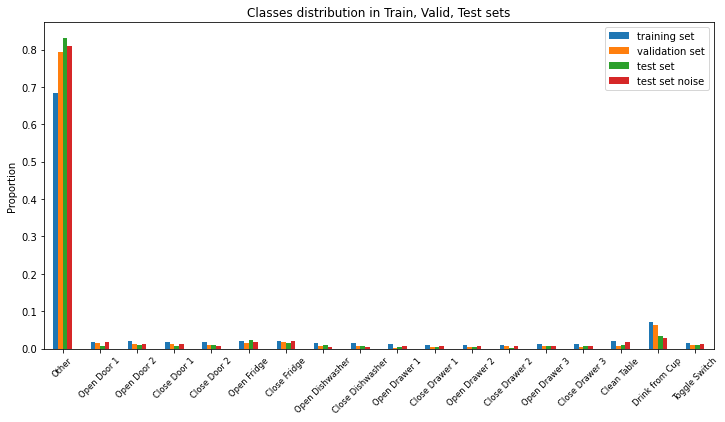

In [ ]:
# Graphical representation
fig, ax = plt.subplots(figsize=(12, 6))
freq_df.plot.bar(ax = ax)
ax.set_title('Classes distribution in Train, Valid, Test sets')
ax.set_ylabel('Proportion')
labels = ax.set_xticklabels(id2label)
_ = ax.set_xticklabels(labels = labels, rotation=45, fontsize='small')

#### 3.2.2 without considering the class 'Other'

In [ ]:
# check the class distributions in y_train, y_valid, y_test
freq_y_valid1 = y_valid.value_counts().sort_index()[1:]/y_valid.value_counts()[1:].sum()

freq_y_train1 = y_train.value_counts().sort_index()[1:]/y_train.value_counts()[1:].sum()

freq_y_test1 = y_test.value_counts().sort_index()[1:]/y_test.value_counts()[1:].sum()

freq_y_test_noise1 = y_test_noise.value_counts().sort_index()[1:]/y_test_noise.value_counts()[1:].sum()

In [ ]:
freq_df1 = pd.DataFrame([freq_y_train1, freq_y_valid1, freq_y_test1, freq_y_test_noise1]).transpose()
freq_df1.index = id2label[1:]; 
freq_df1.columns = ['training set','validation set','test set', 'test set noise']
freq_df1

training set  validation set  test set  test set noise
Open Door 1           0.058912        0.073899  0.034089        0.087803
Open Door 2           0.061718        0.062345  0.057452        0.057589
Close Door 1          0.056689        0.063586  0.035650        0.069350
Close Door 2          0.059440        0.051101  0.049799        0.038325
Open Fridge           0.067001        0.067773  0.137915        0.097536
Close Fridge          0.061500        0.080955  0.095821        0.106864
Open Dishwasher       0.048717        0.029311  0.059919        0.023421
Close Dishwasher      0.044962        0.033886  0.047533        0.021494
Open Drawer 1         0.036071        0.013182  0.023565        0.041570
Close Drawer 1        0.029585        0.015974  0.026032        0.030315
Open Drawer 2         0.032909        0.026520  0.024270        0.029200
Close Drawer 2        0.028880        0.034972  0.016062        0.030417
Open Drawer 3         0.039862        0.035980  0.039778        0.036196
Close Drawer 3        0.039963        0.026365  0.036254        0.035588
Clean Table           0.066205        0.027140  0.060020        0.093177
Drink from Cup        0.224439        0.313275  0.191641        0.140931
Toggle Switch         0.043145        0.043734  0.064199        0.060225

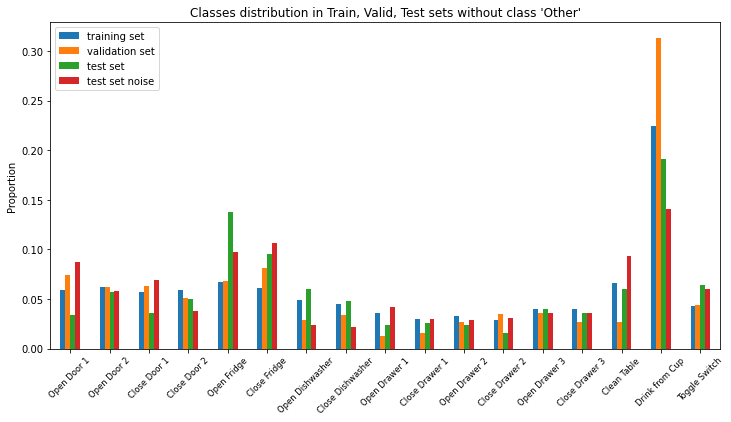

In [ ]:
# Graphical representation
fig, ax = plt.subplots(figsize=(12, 6))
freq_df1.plot.bar(ax = ax)
ax.set_title('Classes distribution in Train, Valid, Test sets without class \'Other\'')
ax.set_ylabel('Proportion')
labels = ax.set_xticklabels(id2label[1:])
_ = ax.set_xticklabels(labels = labels, rotation=45, fontsize='small')

### 3.3 Compute the avg duration of each action

##### The results of this part may give useful indications to choose the window size

In [ ]:
list_len_actions = [(x[0], len(list(x[1]))) for x in itertools.groupby(np.array(y_train, np.int))]

# https://stackoverflow.com/questions/36441521/find-maximum-length-of-consecutive-repeated-numbers-in-a-list-python

In [ ]:
list_len_actions[:5]

[(0, 10777), (5, 101), (0, 111), (6, 54), (0, 339)]

In [ ]:
dict_len_action = {}
for p in list_len_actions:
    object_class = p[0]
    dict_len_action[object_class] = dict_len_action.setdefault(object_class, []) + [p[1]]

In [ ]:
actions_list = []
actions_avg_len = []
for k in dict_len_action:
    actions_list.append(k)
    actions_avg_len.append(np.mean(dict_len_action[k]))
avg_len_action = pd.DataFrame(actions_avg_len, actions_list).sort_index().T
avg_len_action.columns = id2label
avg_len_action.index = ['avg_duration']
avg_len_action

Other  Open Door 1  ...  Drink from Cup  Toggle Switch
avg_duration  227.881628   109.518868  ...      199.220721      48.582857

[1 rows x 18 columns]

In [ ]:
print('Global average duration: ' + str(np.round(np.mean(avg_len_action.values[0]), 2)) + ' samples.')

Global average duration: 97.54 samples.


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 4 Creating datasets

### 4.1 Automatic feature extraction

#### 4.1.0 Dataset 0: all raw features (acc, gyro, mag, quat of all jacket IMU)

In [ ]:
x_train_raw = np.array(training.iloc[:,:-1])# ).astype(np.float32)

x_valid_raw = np.array(validation.iloc[:,:-1]) #).astype(np.float32)

x_test_raw = np.array(test.iloc[:,:-1]) #).astype(np.float32)

x_test_noise_raw = np.array(test_noise.iloc[:,:-1]) #).astype(np.float32)

In [ ]:
y_train_raw = np.array(y_train, np.int)

y_valid_raw = np.array(y_valid, np.int)

y_test_raw = np.array(y_test, np.int)

y_test_noise_raw = np.array(y_test_noise, np.int)

In [ ]:
#check the shape
print("x_train shape =",x_train_raw.shape)
print("y_train shape =",y_train_raw.shape)

print("x_valid shape =",x_valid_raw.shape)
print("y_valid shape =",y_valid_raw.shape)

print("x_test shape =",x_test_raw.shape)
print("y_test shape =",y_test_raw.shape)

print("x_test_noise shape =",x_test_noise_raw.shape)
print("y_test_noise shape =",y_test_noise_raw.shape)

x_train shape = (622511, 65)
y_train shape = (622511,)
x_valid shape = (62747, 65)
y_valid shape = (62747,)
x_test shape = (117601, 65)
y_test shape = (117601,)
x_test_noise shape = (51465, 65)
y_test_noise shape = (51465,)


In [ ]:
data_raw = {'training': {'x': x_train_raw, 'y': y_train_raw},
        'validation': {'x': x_valid_raw, 'y': y_valid_raw},
        'test': {'x': x_test_raw, 'y': y_test_raw},
        'test_noise': {'x': x_test_noise_raw, 'y': y_test_noise_raw}}

In [ ]:
# define a function to save the file in h5 format(RUN ONLY THE FIRST TIME)
def save_data(data, name):
        f = h5py.File('/content/gdrive/My Drive/Colab Notebooks/dataset/' + name + '.h5')#libver='earliest') # most compatible
        for key in data: #iterate through all the keys ('training', 'validation', 'test') of dict data
            f.create_group(key) #create a group for each key
            for field in data[key]: #iterate through all the keys ('x', 'y') of the inner dicts ('training', 'validation', 'test')
                f[key].create_dataset(field, data = data[key][field])
        f.close()
        with open('/content/gdrive/My Drive/Colab Notebooks/dataset/' + name + '.h5.classes.json', 'w') as f:
            f.write(json.dumps(id2label))   

In [ ]:
save_data(data_raw, 'opportunity_raw')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


#### 4.1.1 Dataset 1: all jacket IMUs (but only acc and gyro)

In [ ]:
jacket_acc_gyro = [
        'BACK accX', 'BACK accY', 'BACK accZ', 'BACK gyroX', 'BACK gyroY', 'BACK gyroZ',
        'RUA accX', 'RUA accY', 'RUA accZ', 'RUA gyroX', 'RUA gyroY', 'RUA gyroZ',
        'RLA accX', 'RLA accY', 'RLA accZ', 'RLA gyroX', 'RLA gyroY', 'RLA gyroZ',
        'LUA accX', 'LUA accY', 'LUA accZ', 'LUA gyroX', 'LUA gyroY', 'LUA gyroZ',
        'LLA accX', 'LLA accY', 'LLA accZ', 'LLA gyroX', 'LLA gyroY', 'LLA gyroZ'
        ]

In [ ]:
x_train_acc_gyro_df = training.loc[:,jacket_acc_gyro]
x_train_acc_gyro = np.array(x_train_acc_gyro_df)

x_valid_acc_gyro = np.array(validation.loc[:,jacket_acc_gyro])

x_test_acc_gyro = np.array(test.loc[:,jacket_acc_gyro])
                     
x_test_noise_acc_gyro = np.array(test_noise.loc[:,jacket_acc_gyro])

In [ ]:
x_train_acc_gyro_df.head()

BACK accX  BACK accY  BACK accZ  ...  LLA gyroX  LLA gyroY  LLA gyroZ
0   0.001535  -0.013931   0.009878  ...   0.036181   0.094922   0.123364
1   0.023406  -0.021437   0.016162  ...  -0.015757   0.113801   0.297473
2   0.031474  -0.024075   0.018171  ...  -0.001062   0.170803   0.393537
3   0.018596  -0.026240   0.001069  ...   0.016700   0.172171   0.310184
4   0.012440  -0.023770  -0.008610  ...   0.066945   0.190873   0.288275

[5 rows x 30 columns]

In [ ]:
#check the shape
print("x_train shape =",x_train_acc_gyro.shape)
print("y_train shape =",y_train_raw.shape)

print("x_valid shape =",x_valid_acc_gyro.shape)
print("y_valid shape =",y_valid_raw.shape)

print("x_test shape =",x_test_acc_gyro.shape)
print("y_test shape =",y_test_raw.shape)

print("x_test_noise shape =",x_test_noise_acc_gyro.shape)
print("y_test_noise shape =",y_test_noise_raw.shape)

x_train shape = (622511, 30)
y_train shape = (622511,)
x_valid shape = (62747, 30)
y_valid shape = (62747,)
x_test shape = (117601, 30)
y_test shape = (117601,)
x_test_noise shape = (51465, 30)
y_test_noise shape = (51465,)


In [ ]:
data = {'training': {'x': x_train_acc_gyro, 'y': y_train_raw},
        'validation': {'x': x_valid_acc_gyro, 'y': y_valid_raw},
        'test': {'x': x_test_acc_gyro, 'y': y_test_raw},
        'test_noise': {'x': x_test_noise_acc_gyro, 'y': y_test_noise_raw}}

In [ ]:
save_data(data, 'opportunity')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


#### 4.1.2 Dataset 2: only lower arm accelerometer and gyroscope features

In [ ]:
lower_arm_features = [
                'RLA accX', 'RLA accY', 'RLA accZ', 'RLA gyroX', 'RLA gyroY', 'RLA gyroZ', #'RLA magneticX', 'RLA magneticY', 'RLA magneticZ', 'RLA q1', 'RLA q2', 'RLA q3', 'RLA q4',
                'LLA accX', 'LLA accY', 'LLA accZ', 'LLA gyroX', 'LLA gyroY', 'LLA gyroZ'#, 'LLA magneticX', 'LLA magneticY', 'LLA magneticZ', 'LLA q1', 'LLA q2', 'LLA q3', 'LLA q4'
                     ]

In [ ]:
x_train_low_df = training.loc[:,lower_arm_features]
x_train_low = np.array(x_train_low_df)

x_valid_low = np.array(validation.loc[:,lower_arm_features])

x_test_low = np.array(test.loc[:,lower_arm_features])
                     
x_test_noise_low = np.array(test_noise.loc[:,lower_arm_features])

In [ ]:
x_train_low_df.head()

RLA accX  RLA accY  RLA accZ  ...  LLA gyroX  LLA gyroY  LLA gyroZ
0  0.137626 -0.114514  0.013232  ...   0.036181   0.094922   0.123364
1  0.044977 -0.185260  0.093070  ...  -0.015757   0.113801   0.297473
2  0.026921  0.033661 -0.025930  ...  -0.001062   0.170803   0.393537
3  0.013297  0.097971 -0.018512  ...   0.016700   0.172171   0.310184
4  0.008089  0.104149 -0.010667  ...   0.066945   0.190873   0.288275

[5 rows x 12 columns]

In [ ]:
#check the shape
print("x_train shape =",x_train_low.shape)
print("y_train shape =",y_train_raw.shape)

print("x_valid shape =",x_valid_low.shape)
print("y_valid shape =",y_valid_raw.shape)

print("x_test shape =",x_test_low.shape)
print("y_test shape =",y_test_raw.shape)

print("x_test_noise shape =",x_test_noise_low.shape)
print("y_test_noise shape =",y_test_noise_raw.shape)

x_train shape = (622511, 12)
y_train shape = (622511,)
x_valid shape = (62747, 12)
y_valid shape = (62747,)
x_test shape = (117601, 12)
y_test shape = (117601,)
x_test_noise shape = (51465, 12)
y_test_noise shape = (51465,)


In [ ]:
data_low = {'training': {'x': x_train_low, 'y': y_train_raw},
        'validation': {'x': x_valid_low, 'y': y_valid_raw},
        'test': {'x': x_test_low, 'y': y_test_raw},
        'test_noise': {'x': x_test_noise_low, 'y': y_test_noise_raw}}

In [ ]:
save_data(data_low, 'opportunity_low')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


### 4.2 Segmentation

In [ ]:
#segment the data in a series of half-overlapping windows, each of which will be the input of the CNN 
#("Deep, Convolutional, and Recurrent Models for Human Activity Recognition using Wearables"-Hammerla, Halloran, Plotz)

#helper function used in 'segment'
def windowz(data, size):
    start = 0
    while start < len(data):
        yield start, start + size
        start += (size // 2)

def segment(x_train, y_train, window_size):
    n_windows = (len(x_train)//(window_size//2))-1
    n_features = x_train.shape[1]
    segments = np.zeros( (n_windows, window_size, n_features) ) 
    labels = np.zeros( n_windows )
    i_segment = 0
    i_label = 0
    for (start,end) in windowz(x_train, window_size):
        if(len(x_train[start:end]) == window_size):
            m = stats.mode(y_train[start:end])
            segments[i_segment] = x_train[start:end]
            labels[i_label] = m[0] 
            i_label+=1 
            i_segment+=1
    return  np.asarray(segments,dtype=np.float32),  np.asarray(labels,dtype=np.int)

### 4.3 Manual Feature extraction

In [ ]:
# Let's add after each triplet the norm of that 3D vector
def compute_norm(s):
    for i in range(0, int(s.shape[1]*4/3), 4):

        norm = np.sqrt(s[:,i]**2 + s[:,i+1]**2 + s[:,i+2]**2)
        s = np.insert(s, i + 3, norm, axis = 1)
    
    return s

In [ ]:
# Check using the training set 
x_train_acc_gyro[0]

array([ 0.00153486, -0.01393149,  0.00987849,  0.02383187,  0.04357448,
        0.1802479 ,  0.04788962, -0.08437213,  0.01452054,  0.03475064,
        0.14542649,  0.20791471,  0.13762605, -0.11451371,  0.0132318 ,
       -0.48191242, -0.27761363, -0.11686355,  0.00817964,  0.02672991,
       -0.01178767,  0.00606198,  0.03032844,  0.15674641,  0.01317911,
        0.00759534,  0.00178522,  0.0361808 ,  0.0949225 ,  0.12336397])

In [ ]:
x_train_acc_gyro.shape

(622511, 30)

In [ ]:
x_train_acc_gyro_n = compute_norm(x_train_acc_gyro)

In [ ]:
x_train_acc_gyro_n[0]

array([ 0.00153486, -0.01393149,  0.00987849,  0.01714721,  0.02383187,
        0.04357448,  0.1802479 ,  0.18696524,  0.04788962, -0.08437213,
        0.01452054,  0.09809647,  0.03475064,  0.14542649,  0.20791471,
        0.25609569,  0.13762605, -0.11451371,  0.0132318 ,  0.17952549,
       -0.48191242, -0.27761363, -0.11686355,  0.56830098,  0.00817964,
        0.02672991, -0.01178767,  0.03033717,  0.00606198,  0.03032844,
        0.15674641,  0.15976858,  0.01317911,  0.00759534,  0.00178522,
        0.01531552,  0.0361808 ,  0.0949225 ,  0.12336397,  0.15980613])

In [ ]:
x_train_acc_gyro_n.shape

(622511, 40)

In [ ]:
# Apply it to the other sets
x_valid_acc_gyro_n = compute_norm(x_valid_acc_gyro)
x_test_acc_gyro_n = compute_norm(x_test_acc_gyro)
x_test_noise_acc_gyro_n = compute_norm(x_test_noise_acc_gyro)

In [ ]:
print(x_valid_acc_gyro_n.shape)
print(x_test_acc_gyro_n.shape)
print(x_test_noise_acc_gyro_n.shape)

(62747, 40)
(117601, 40)
(51465, 40)


Now these datasets have 40 variables. Those in position 3, 7, 11, ... are the norms of the previous three

#### 4.3.0 segment the datasets

In [ ]:
input_width = 30

x_train_segmented, y_train_segmented = segment(x_train_acc_gyro_n, y_train_raw, input_width)
x_valid_segmented, y_valid_segmented = segment(x_valid_acc_gyro_n, y_valid_raw, input_width)
x_test_segmented, y_test_segmented = segment(x_test_acc_gyro_n, y_test_raw, input_width)
x_test_noise_segmented, y_test_noise_segmented = segment(x_test_noise_acc_gyro_n, y_test_noise_raw, input_width)

#check the shape
print("x_train_segmented shape =", x_train_segmented.shape)
print("y_train_segmented shape =", y_train_segmented.shape)

print("x_valid_segmented shape =", x_valid_segmented.shape)
print("y_valid_segmented shape =", y_valid_segmented.shape)

print("x_test_segmented shape =", x_test_segmented.shape)
print("y_test_segmented shape =", y_test_segmented.shape)

print("x_test_segmented shape =", x_test_noise_segmented.shape)
print("y_test_segmented shape =", y_test_noise_segmented.shape)

x_train_segmented shape = (41499, 30, 40)
y_train_segmented shape = (41499,)
x_valid_segmented shape = (4182, 30, 40)
y_valid_segmented shape = (4182,)
x_test_segmented shape = (7839, 30, 40)
y_test_segmented shape = (7839,)
x_test_segmented shape = (3430, 30, 40)
y_test_segmented shape = (3430,)


In [ ]:
# Manual feature extraction: compute the mean of all the features. Moreover it computes the std, min, max, iqr and rms for the norm features.

def manual_features(s):
    average = np.mean(s, axis = 1)
    
    norm_columns = list(range(3, s.shape[2], 4))
    std = np.std(s[:,:,norm_columns], axis = 1)
    mins = np.min(s[:,:,norm_columns], axis = 1)
    maxs = np.max(s[:,:,norm_columns], axis = 1)
    q75, q25 = np.percentile(s[:,:,norm_columns], [75 ,25], axis = 1)
    iqr = q75 - q25
    rms = np.sqrt(np.mean(s[:,:,norm_columns] ** 2, axis = 1))
        
    return np.concatenate((average, std, mins, maxs, iqr, rms), axis = 1)

#### 4.3.1 Dataset 3: hand-crafted features, all IMUs

In [ ]:
# Manual feature extraction: compute the mean of all the features (40). Moreover compute the std, min, max, iqr and rms for the norm features (10*5). Tot 40+50=90 features.

x_train_manual = manual_features(x_train_segmented)
x_valid_manual = manual_features(x_valid_segmented)
x_test_manual = manual_features(x_test_segmented)
x_test_noise_manual = manual_features(x_test_noise_segmented)

In [ ]:
#check the shape
print("x_train shape =",x_train_manual.shape)
print("y_train shape =",y_train_segmented.shape)

print("x_valid shape =",x_valid_manual.shape)
print("y_valid shape =",y_valid_segmented.shape)

print("x_test shape =",x_test_manual.shape)
print("y_test shape =",y_test_segmented.shape)

print("x_test_noise shape =",x_test_noise_manual.shape)
print("y_test_noise shape =",y_test_noise_segmented.shape)

x_train shape = (41499, 90)
y_train shape = (41499,)
x_valid shape = (4182, 90)
y_valid shape = (4182,)
x_test shape = (7839, 90)
y_test shape = (7839,)
x_test_noise shape = (3430, 90)
y_test_noise shape = (3430,)


In [ ]:
data_manual = {'training': {'x': x_train_manual, 'y': y_train_segmented},
        'validation': {'x': x_valid_manual, 'y': y_valid_segmented},
        'test': {'x': x_test_manual, 'y': y_test_segmented},
        'test_noise': {'x': x_test_noise_manual, 'y': y_test_noise_segmented}}

In [ ]:
save_data(data_manual, 'opportunity_manual')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


#### 4.3.2 Dataset 4: Hand-crafted features, only lower arm IMUs

In [ ]:
lower_arm_indices = list(range(16,24)) + list(range(32,40))

In [ ]:
# Manual feature extraction: compute the mean of all the features (16). Moreover compute the std, min, max, iqr and rms for the norm features (4*5). Tot 16+20=36 features.

x_train_manual_low = manual_features(x_train_segmented[:,:,lower_arm_indices])
x_valid_manual_low = manual_features(x_valid_segmented[:,:,lower_arm_indices])
x_test_manual_low = manual_features(x_test_segmented[:,:,lower_arm_indices])
x_test_noise_manual_low = manual_features(x_test_noise_segmented[:,:,lower_arm_indices])

In [ ]:
#check the shape
print("x_train shape =",x_train_manual_low.shape)
print("y_train shape =",y_train_segmented.shape)

print("x_valid shape =",x_valid_manual_low.shape)
print("y_valid shape =",y_valid_segmented.shape)

print("x_test shape =",x_test_manual_low.shape)
print("y_test shape =",y_test_segmented.shape)

print("x_test_noise shape =",x_test_noise_manual_low.shape)
print("y_test_noise shape =",y_test_noise_segmented.shape)

x_train shape = (41499, 36)
y_train shape = (41499,)
x_valid shape = (4182, 36)
y_valid shape = (4182,)
x_test shape = (7839, 36)
y_test shape = (7839,)
x_test_noise shape = (3430, 36)
y_test_noise shape = (3430,)


In [ ]:
data_manual_lower = {'training': {'x': x_train_manual_low, 'y': y_train_segmented},
        'validation': {'x': x_valid_manual_low, 'y': y_valid_segmented},
        'test': {'x': x_test_manual_low, 'y': y_test_segmented},
        'test_noise': {'x': x_test_noise_manual_low, 'y': y_test_noise_segmented}}

In [ ]:
save_data(data_manual_lower, 'opportunity_manual_low')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 5 Model training

Recap - we have four datasets:
- Dataset 0: 'opportunity_raw' with acc, gyro, mag, quat features of all IMUs;
- Dataset 1: 'opportunity' with acc, gyro of all IMUs;
- Dataset 2: 'opportunity_low' with acc, gyro of RLA and LLA;
- Dataset 3: 'opportunity_manual' with some hand-crafted features related to acc and gyro of all IMUs;
- Dataset 4: 'opportunity_manual_low' with some hand-crafted features related to acc and gyro of RLA and LLA.

Now we have to build on top of these datasets some deep learning models.

The idea is to compare:
- the effectiveness of manual vs automatic feature extraction (dataset 1 vs 3 and 2 vs 4);
- the accuracy reduction using just two IMUs (dataset 1 vs 2 and 3 vs 4);
- the noise robustness of the different models (test accuracy vs test_noise accuracy).

### 5.0 Cells required if running only this section

In [ ]:
# Import packages

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv1D, Conv2D, GRU
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow_addons.metrics import F1Score
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
import csv
import h5py
import json 
from scipy import stats
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
# import kerastuner as kt
import IPython
import itertools
import missingno as msno
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Point Colaboratory to your Google Drive

from google.colab import drive
drive.mount('/content/gdrive')
datapath = '/content/gdrive/My Drive/Colab Notebooks/dataset'

Mounted at /content/gdrive


In [ ]:
# from 'label_legend' txt file
label_map = [
            (0,      'Other'),
            (406516, 'Open Door 1'),
            (406517, 'Open Door 2'),
            (404516, 'Close Door 1'),
            (404517, 'Close Door 2'),
            (406520, 'Open Fridge'),
            (404520, 'Close Fridge'),
            (406505, 'Open Dishwasher'),
            (404505, 'Close Dishwasher'),
            (406519, 'Open Drawer 1'),
            (404519, 'Close Drawer 1'),
            (406511, 'Open Drawer 2'),
            (404511, 'Close Drawer 2'),
            (406508, 'Open Drawer 3'),
            (404508, 'Close Drawer 3'),
            (408512, 'Clean Table'),
            (407521, 'Drink from Cup'),
            (405506, 'Toggle Switch')
        ]
dictio = {x[0]: i for i, x in enumerate(label_map) if i!=0}
# it creates the dictionary {406516:1, ...}
id2label = [x[1] for x in label_map]
# it creates the list ['other', 'Open Door1', ...]

In [ ]:
#segment the data in a series of half-overlapping windows, each of which will be the input of the CNN 
#("Deep, Convolutional, and Recurrent Models for Human Activity Recognition using Wearables"-Hammerla, Halloran, Plotz)

#helper function used in 'segment'
def windowz(data, size):
    start = 0
    while start < len(data):
        yield start, start + size
        start += (size // 2)

def segment(x_train, y_train, window_size):
    n_windows = (len(x_train)//(window_size//2))-1
    n_features = x_train.shape[1]
    segments = np.zeros( (n_windows, window_size, n_features) ) 
    labels = np.zeros( n_windows )
    i_segment = 0
    i_label = 0
    for (start,end) in windowz(x_train, window_size):
        if(len(x_train[start:end]) == window_size):
            m = stats.mode(y_train[start:end])
            segments[i_segment] = x_train[start:end]
            labels[i_label] = m[0] 
            i_label+=1 
            i_segment+=1
    return  np.asarray(segments,dtype=np.float32),  np.asarray(labels,dtype=np.int)

In [ ]:
# function to plot accuracy on Training set and Test set in same figure
def plot_accuracy(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['f1_score'], label = "Accuracy on Training Set")
    plt.plot(history.epoch,history.history['val_f1_score'], label = "Accuracy on Validation Set")
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracies')

### 5.1 Dataset 1 - opportunity 


Load

In [ ]:
# Load the data from .h5 
f = h5py.File('/content/gdrive/My Drive/Colab Notebooks/dataset/opportunity.h5', 'r') 

# load training set
x_train = f.get('training').get('x')[()]
y_train = f.get('training').get('y')[()].astype(np.int)

# load validation set
x_valid = f.get('validation').get('x')[()]
y_valid = f.get('validation').get('y')[()].astype(np.int)

# load test set
x_test = f.get('test').get('x')[()]
y_test = f.get('test').get('y')[()].astype(np.int)

# load noise test set
x_test_noise = f.get('test_noise').get('x')[()]
y_test_noise = f.get('test_noise').get('y')[()].astype(np.int)

#check the shape
print("x_train shape = ", x_train.shape)
print("y_train shape =", y_train.shape)

print("x_valid shape = ", x_valid.shape)
print("y_valid shape =", y_valid.shape)

print("x_test shape =" , x_test.shape)
print("y_test shape =", y_test.shape)

print("x_test_noise shape =" , x_test_noise.shape)
print("y_test_noise shape =", y_test_noise.shape)
   

x_train shape =  (622511, 30)
y_train shape = (622511,)
x_valid shape =  (62747, 30)
y_valid shape = (62747,)
x_test shape = (117601, 30)
y_test shape = (117601,)
x_test_noise shape = (51465, 30)
y_test_noise shape = (51465,)


In [ ]:
# Segment the dataset: half overlapping windows of 30 samples (1 sec) 
input_width = 30
x_train_segmented, y_train_segmented = segment(x_train, y_train, input_width)
x_valid_segmented, y_valid_segmented = segment(x_valid, y_valid, input_width)
x_test_segmented, y_test_segmented = segment(x_test, y_test, input_width)
x_test_noise_segmented, y_test_noise_segmented = segment(x_test_noise, y_test_noise, input_width)

In [ ]:
# one hot-encode (not necessary if using 'sparse_categorical_crossentropy')
y_train_segmented=pd.get_dummies(y_train_segmented)
y_valid_segmented=pd.get_dummies(y_valid_segmented)
y_test_segmented_original = y_test_segmented
y_test_segmented=pd.get_dummies(y_test_segmented) 
y_test_noise_segmented_original = y_test_noise_segmented
y_test_noise_segmented=pd.get_dummies(y_test_segmented) 

In [ ]:
# Convert to tensor and change dtypes to speed up computations on the GPU

x_train_segmented = tf.convert_to_tensor(x_train_segmented, tf.float32)
x_valid_segmented = tf.convert_to_tensor(x_valid_segmented, tf.float32)
x_test_segmented = tf.convert_to_tensor(x_test_segmented, tf.float32)
x_test_noise_segmented = tf.convert_to_tensor(x_test_noise_segmented, tf.float32)

y_train_segmented = tf.convert_to_tensor(y_train_segmented, tf.int8)
y_valid_segmented = tf.convert_to_tensor(y_valid_segmented, tf.int8)
y_test_segmented = tf.convert_to_tensor(y_test_segmented, tf.int8)
y_test_noise_segmented = tf.convert_to_tensor(y_test_noise_segmented, tf.int8)

In [ ]:
# check the shape
print("x_train_segmented shape =",x_train_segmented.shape)
print("y_train_segmented shape =",y_train_segmented.shape)

print("x_valid_segmented shape =",x_valid_segmented.shape)
print("y_valid_segmented shape =",y_valid_segmented.shape)

print("x_test_segmented shape =",x_test_segmented.shape)
print("y_test_segmented shape =",y_test_segmented.shape)

print("x_test_noise_segmented shape =",x_test_noise_segmented.shape)
print("y_test_noise_segmented shape =",y_test_noise_segmented.shape)

x_train_segmented shape = (41499, 30, 30)
y_train_segmented shape = (41499, 18)
x_valid_segmented shape = (4182, 30, 30)
y_valid_segmented shape = (4182, 18)
x_test_segmented shape = (7839, 30, 30)
y_test_segmented shape = (7839, 18)
x_test_noise_segmented shape = (3430, 30, 30)
y_test_noise_segmented shape = (7839, 18)


#### 5.1.1 CNN + RNN model
Two 1D convolutional layers, two GRU units and two dense layers.
(with a GPU available, it is convenient to use CuDNNGRU, which leverages the CuDNN library for a more efficient training)

In [ ]:
def model_CNN_RNN(input_shape):
    X_input = layers.Input(input_shape)
    
    X = Conv1D(filters=128,
               kernel_size=8, 
               strides=1,
               name='conv1',
               activation = 'relu')(X_input)
    X= BatchNormalization(axis=2)(X) 
    X=Dropout(0.1)(X)
    
    X = Conv1D(filters=128,
               kernel_size=3,
               strides=1,
               name='conv2',
               activation = 'relu')(X)
    X= BatchNormalization(axis=2)(X)
    X=Dropout(0.25)(X)
    
    X = CuDNNGRU(units = 128, return_sequences= True)(X)
    X = CuDNNGRU(units = 128, return_sequences= True)(X)

    X = layers.Flatten()(X) 
    X = Dense(units=64, activation='relu')(X)#2^8
    X=Dropout(0.25)(X)
      
    X = Dense(units=18, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='model_CNN_RNN')

    return model

In [ ]:
# Compile the model
input_shape = x_train_segmented.shape[1:]
model_CNN_RNN = model_CNN_RNN(input_shape)

model_CNN_RNN.compile(optimizer = 'adam',
                      loss =  CategoricalCrossentropy(),
                      metrics = F1Score(num_classes = 18, average='weighted'))
model_CNN_RNN.summary()

Model: "model_CNN_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 30)]          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 23, 128)           30848     
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 128)           512       
_________________________________________________________________
dropout (Dropout)            (None, 23, 128)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 21, 128)           49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 128)           512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 128)         

In [ ]:
# Interrupt training when it measures no progress on the validation set for a number of epochs (patience)
early_stopping = EarlyStopping(monitor='val_f1_score', patience=8, mode='max')

In [ ]:
# Save the model when its performance on the validation set is the best so far
model_checkpoint = ModelCheckpoint(filepath= datapath + '/models/opp.h5', save_weights_only=False, monitor='val_f1_score',
                                                                mode='max', save_best_only=True)

In [ ]:
# Other parameters
batch_size = 64
epochs = 128

In [ ]:
# Training
history = model_CNN_RNN.fit (x = x_train_segmented,
                            y = y_train_segmented, 
                            epochs = epochs, 
                            batch_size = batch_size, 
                            callbacks=[early_stopping, model_checkpoint],
                            validation_data=(x_valid_segmented, y_valid_segmented))

Epoch 1/128
649/649 [==============================] - 10s 15ms/step - loss: 0.9653 - f1_score: 0.7062 - val_loss: 0.5763 - val_f1_score: 0.8247
Epoch 2/128
649/649 [==============================] - 8s 12ms/step - loss: 0.6354 - f1_score: 0.7978 - val_loss: 0.5189 - val_f1_score: 0.8338
Epoch 3/128
649/649 [==============================] - 8s 12ms/step - loss: 0.5316 - f1_score: 0.8330 - val_loss: 0.4951 - val_f1_score: 0.8452
Epoch 4/128
649/649 [==============================] - 8s 12ms/step - loss: 0.4753 - f1_score: 0.8528 - val_loss: 0.5073 - val_f1_score: 0.8471
Epoch 5/128
649/649 [==============================] - 8s 12ms/step - loss: 0.4266 - f1_score: 0.8639 - val_loss: 0.4830 - val_f1_score: 0.8570
Epoch 6/128
649/649 [==============================] - 8s 12ms/step - loss: 0.3917 - f1_score: 0.8737 - val_loss: 0.4467 - val_f1_score: 0.8584
Epoch 7/128
649/649 [==============================] - 7s 11ms/step - loss: 0.3629 - f1_score: 0.8832 - val_loss: 0.5165 - val_f1_score

In [ ]:
# Load the best model
model_CNN_RNN = tf.keras.models.load_model(datapath + '/models/opp.h5')

info = model_CNN_RNN.evaluate(x_valid_segmented, y_valid_segmented, verbose=3)
print("Final Loss on Validation Set: {}; \nFinal F1 Score on Validation Set: {}".format(info[0], info[1]))

Final Loss on Validation Set: 0.6096312403678894; 
Final F1 Score on Validation Set: 0.8774587512016296


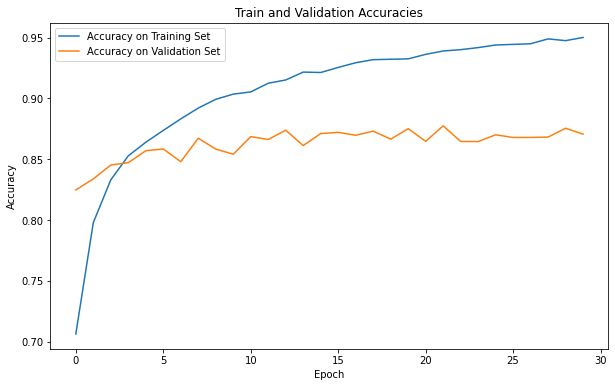

In [ ]:
# Learning curves
plot_accuracy(history)
fig=plt.gcf()
fig.savefig(datapath + '/models/opp_lc.png')

Evaluation

Test set without noise

In [ ]:
# Performance on test set
y_true=y_test_segmented_original
val_steps = int(np.ceil(len(x_test_segmented)/64))
y_prob=model_CNN_RNN.predict(x_test_segmented, batch_size=64, steps=val_steps)
y_pred=np.argmax(y_prob,axis=1)
precision, recall, fscore_opp, _= metrics.precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp) )

precision = 0.882
 recall = 0.887
 fscore = 0.881


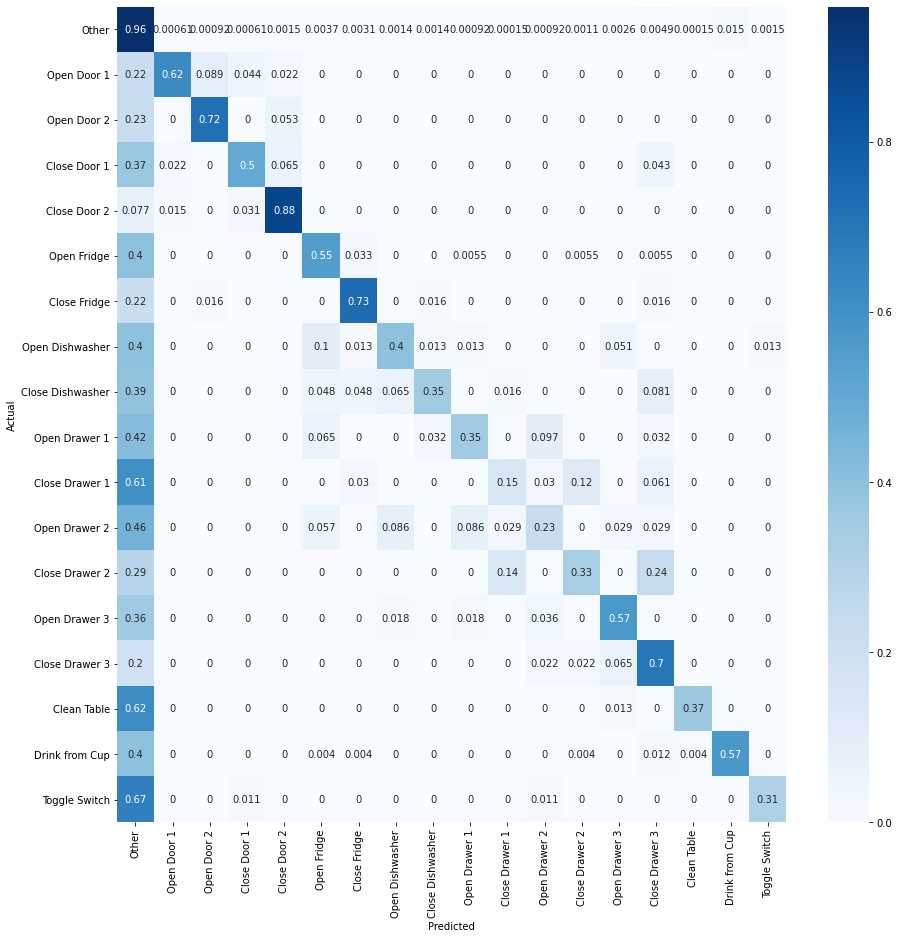

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true, y_pred, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.93      0.96      0.94      6522
     Open Door 1       0.82      0.62      0.71        45
     Open Door 2       0.82      0.72      0.77        75
    Close Door 1       0.72      0.50      0.59        46
    Close Door 2       0.76      0.88      0.81        65
     Open Fridge       0.72      0.55      0.62       183
    Close Fridge       0.74      0.73      0.74       124
 Open Dishwasher       0.65      0.40      0.49        78
Close Dishwasher       0.63      0.35      0.45        62
   Open Drawer 1       0.48      0.35      0.41        31
  Close Drawer 1       0.45      0.15      0.23        33
   Open Drawer 2       0.36      0.23      0.28        35
  Close Drawer 2       0.33      0.33      0.33        21
   Open Drawer 3       0.55      0.57      0.56        56
  Close Drawer 3       0.37      0.70      0.48        46
     Clean Table       0.94      0.37      0.53        79
  Drink from 

In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo", average="weighted") # ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",average="weighted") # ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.933
One-vs-Rest ROC AUC scores: 0.907


Test set with noise

In [ ]:
# Performance on test set with noise
batch_size = 64
y_true_n = y_test_noise_segmented_original
val_steps = int(np.ceil(len(x_test_noise_segmented)/batch_size))
y_prob_n=model_CNN_RNN.predict(x_test_noise_segmented, batch_size=64, steps=val_steps)
y_pred_n=np.argmax(y_prob_n,axis=1)
precision, recall, fscore_opp_n, _= metrics.precision_recall_fscore_support(y_true_n, y_pred_n, average='weighted',zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp_n) )

precision = 0.873
 recall = 0.872
 fscore = 0.869


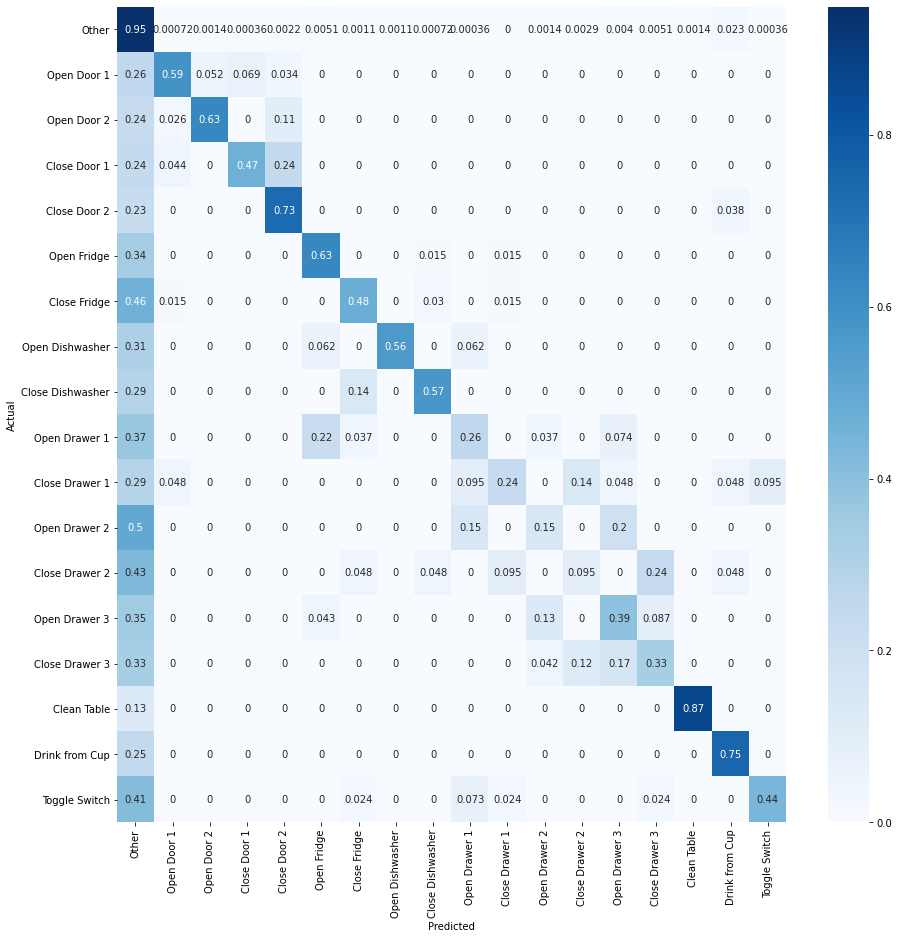

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true_n, y_pred_n, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true_n, y_pred_n, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.93      0.95      0.94      2771
     Open Door 1       0.83      0.59      0.69        58
     Open Door 2       0.77      0.63      0.70        38
    Close Door 1       0.81      0.47      0.59        45
    Close Door 2       0.45      0.73      0.56        26
     Open Fridge       0.65      0.63      0.64        65
    Close Fridge       0.80      0.48      0.60        67
 Open Dishwasher       0.75      0.56      0.64        16
Close Dishwasher       0.57      0.57      0.57        14
   Open Drawer 1       0.41      0.26      0.32        27
  Close Drawer 1       0.50      0.24      0.32        21
   Open Drawer 2       0.25      0.15      0.19        20
  Close Drawer 2       0.12      0.10      0.11        21
   Open Drawer 3       0.29      0.39      0.33        23
  Close Drawer 3       0.27      0.33      0.30        24
     Clean Table       0.93      0.87      0.90        61
  Drink from 

In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true_n, y_prob_n, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_n, y_prob_n, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.945
One-vs-Rest ROC AUC scores: 0.929


Performance neglecting Null class

In [ ]:
mask = y_true!=0
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

precision, recall, fscore, _= metrics.precision_recall_fscore_support(y_true_0, y_pred_0, average='weighted',zero_division = 0)
print('precision_without_0 = {:.3}\n recall_without_0 = {:.3}\n fscore_without_0 = {:.3}'.format(precision,recall,fscore) )

precision_without_0 = 0.86
 recall_without_0 = 0.533
 fscore_without_0 = 0.644


In [ ]:
# Classification report
report = metrics.classification_report(y_true_0, y_pred_0, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.00      0.00      0.00         0
     Open Door 1       0.93      0.62      0.75        45
     Open Door 2       0.90      0.72      0.80        75
    Close Door 1       0.82      0.50      0.62        46
    Close Door 2       0.88      0.88      0.88        65
     Open Fridge       0.86      0.55      0.67       183
    Close Fridge       0.88      0.73      0.80       124
 Open Dishwasher       0.79      0.40      0.53        78
Close Dishwasher       0.85      0.35      0.50        62
   Open Drawer 1       0.65      0.35      0.46        31
  Close Drawer 1       0.50      0.15      0.23        33
   Open Drawer 2       0.50      0.23      0.31        35
  Close Drawer 2       0.50      0.33      0.40        21
   Open Drawer 3       0.78      0.57      0.66        56
  Close Drawer 3       0.59      0.70      0.64        46
     Clean Table       0.97      0.37      0.53        79
  Drink from 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# AUC ROC scores
y_prob_0=y_prob[mask,1:]#remove 1st column(class 0)
new_weigths=np.sum(y_prob_0,axis=1).reshape((y_pred_0.shape[0],1))#sum by row
y_prob_0=y_prob_0/new_weigths#divide each element in a row by the sum of the row
weighted_roc_auc_ovo = roc_auc_score(y_true_0, y_prob_0, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_0, y_prob_0, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.957
One-vs-Rest ROC AUC scores: 0.963


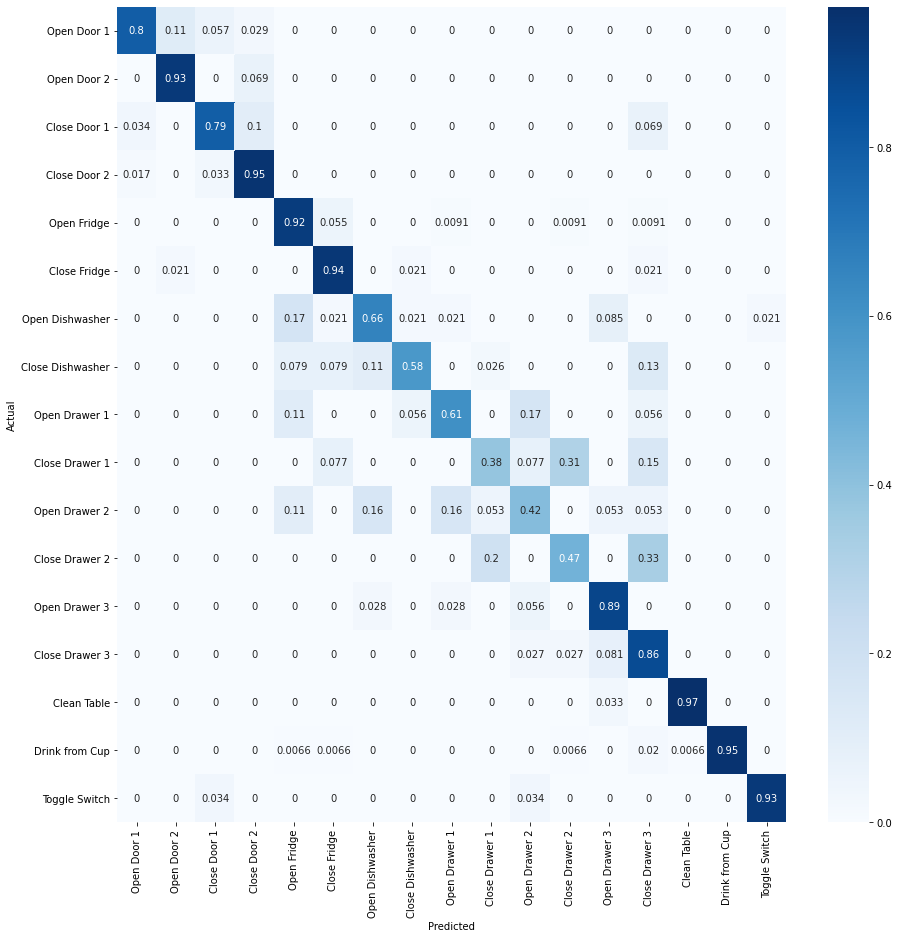

In [ ]:
# Confusion matrix
mask = (np.logical_and(y_true!=0, y_pred!=0))
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

conf_mat = confusion_matrix(y_true_0, y_pred_0, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label[1:], yticklabels=id2label[1:])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 5.1.2 CNN model
Two 2D convolutional layers, and three dense layers

In [ ]:
def model_CNN(input_shape):
    X_input = Input(input_shape)
    
    X = Conv2D(filters=128,
               kernel_size=(8, 1), 
               strides=(1,1),
               name='conv00', 
               padding='same')(X_input)
    X= BatchNormalization(axis=2)(X)
    X=Activation('elu')(X)
    X=Dropout(0.1)(X)
    
    X = Conv2D(filters=128,
               kernel_size=(3, 3), 
               strides=(1,1),
               name='conv01', 
               padding='same')(X)
    X= BatchNormalization(axis=2)(X)
    X=Activation('elu')(X)
    X= MaxPooling2D(pool_size=(2, 2))(X)
    X=Dropout(0.25)(X)
    
    X = Flatten()(X) 
    X = Dense(units=256, activation='elu')(X)
    X=Dropout(0.25)(X)
    
    X = Flatten()(X) 
    X = Dense(units=128, activation='elu')(X)
    X=Dropout(0.25)(X)
      
    X = Dense(units=18, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='model_CNN')

    return model

In [ ]:
# Compile the model
input_shape = (x_train_segmented.shape[1:] + (1,))  
model_CNN = model_CNN(input_shape)

model_CNN.compile(optimizer = 'adam',
                      loss =  CategoricalCrossentropy(),
                      metrics = F1Score(num_classes = 18, average='weighted'))
model_CNN.summary()

Model: "model_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 30, 1)]       0         
_________________________________________________________________
conv00 (Conv2D)              (None, 30, 30, 128)       1152      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 128)       120       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 128)       0         
_________________________________________________________________
conv01 (Conv2D)              (None, 30, 30, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 128)       12

In [ ]:
#interrupt training when it measures no progress on the validation set for a number of epochs (patience)
early_stopping = EarlyStopping(monitor='val_f1_score', patience=8, mode='max')

In [ ]:
# Save the model when its performance on the validation set is the best so far
model_checkpoint = ModelCheckpoint(filepath= datapath + '/models/opp_c.h5', save_weights_only=False, monitor='val_f1_score',
                                                                mode='max', save_best_only=True)

In [ ]:
# Training
history = model_CNN.fit (x = x_train_segmented,
                            y = y_train_segmented, 
                            epochs = epochs, 
                            batch_size = batch_size, 
                            callbacks=[early_stopping, model_checkpoint],
                            validation_data=(x_valid_segmented, y_valid_segmented))

Epoch 1/128
649/649 [==============================] - 22s 34ms/step - loss: 1.5437 - f1_score: 0.6097 - val_loss: 0.7098 - val_f1_score: 0.7501
Epoch 2/128
649/649 [==============================] - 21s 33ms/step - loss: 1.0537 - f1_score: 0.6713 - val_loss: 0.6154 - val_f1_score: 0.7885
Epoch 3/128
649/649 [==============================] - 21s 33ms/step - loss: 0.8517 - f1_score: 0.7246 - val_loss: 0.5488 - val_f1_score: 0.8097
Epoch 4/128
649/649 [==============================] - 21s 33ms/step - loss: 0.7234 - f1_score: 0.7646 - val_loss: 0.5062 - val_f1_score: 0.8314
Epoch 5/128
649/649 [==============================] - 21s 33ms/step - loss: 0.6298 - f1_score: 0.7980 - val_loss: 0.4881 - val_f1_score: 0.8316
Epoch 6/128
649/649 [==============================] - 21s 33ms/step - loss: 0.5712 - f1_score: 0.8196 - val_loss: 0.4614 - val_f1_score: 0.8498
Epoch 7/128
649/649 [==============================] - 21s 33ms/step - loss: 0.5045 - f1_score: 0.8386 - val_loss: 0.4380 - val_f1

In [ ]:
# Load the best model
model_CNN = tf.keras.models.load_model(datapath + '/models/opp_c.h5')

info = model_CNN.evaluate(x_valid_segmented, y_valid_segmented, verbose=3)
print("Final Loss on Validation Set: {}; \nFinal F1 Score on Validation Set: {}".format(info[0], info[1]))

Final Loss on Validation Set: 0.6832860112190247; 
Final F1 Score on Validation Set: 0.870919942855835


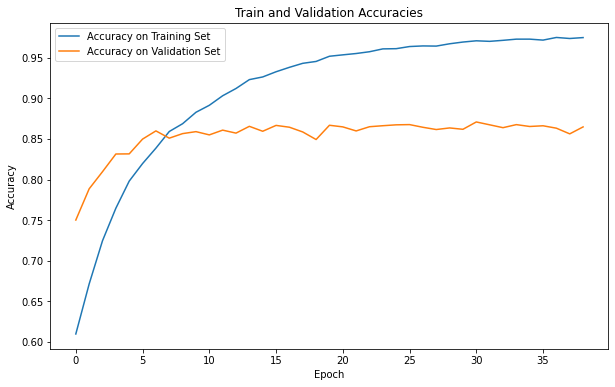

In [ ]:
# Learning curves
plot_accuracy(history)
fig=plt.gcf()
fig.savefig(datapath + '/models/opp_c_lc.png')

Evaluation

Test set without noise

In [ ]:
# Performance on test set
y_true=y_test_segmented_original
val_steps = int(np.ceil(len(x_test_segmented)/64))
y_prob=model_CNN.predict(x_test_segmented, batch_size=64, steps=val_steps)
y_pred=np.argmax(y_prob,axis=1)
precision, recall, fscore_opp_c, _= metrics.precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp_c) )

precision = 0.877
 recall = 0.889
 fscore = 0.877


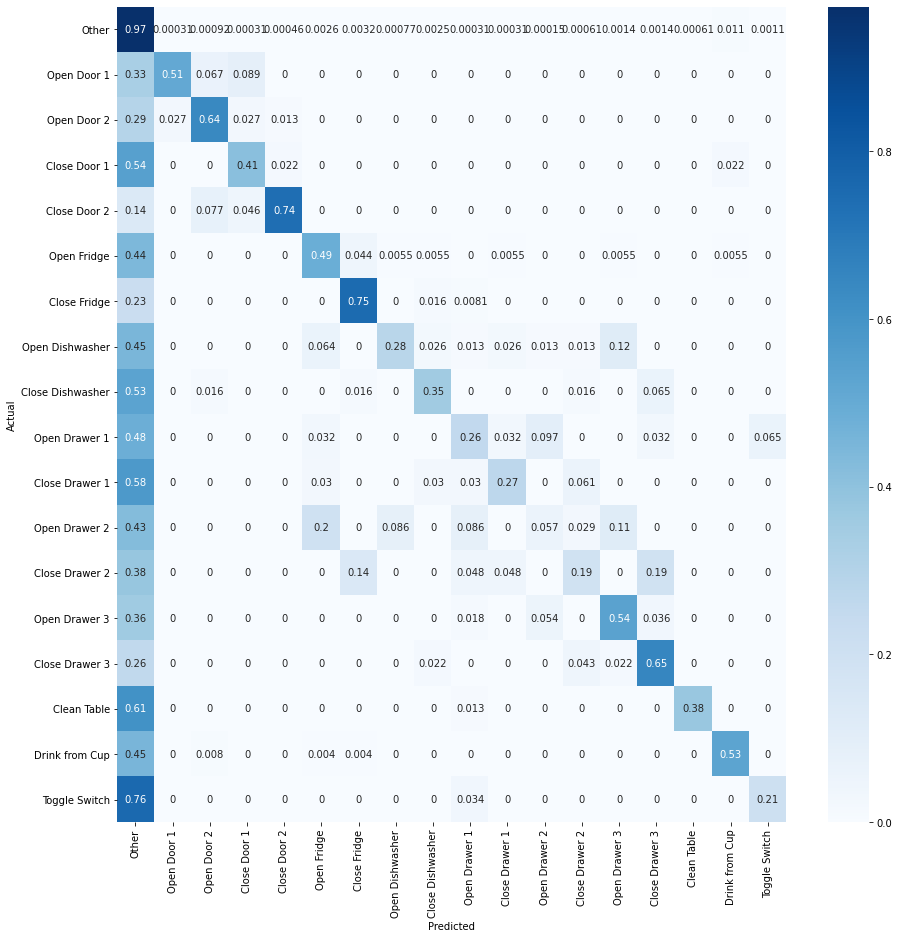

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true, y_pred, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.92      0.97      0.94      6522
     Open Door 1       0.85      0.51      0.64        45
     Open Door 2       0.74      0.64      0.69        75
    Close Door 1       0.63      0.41      0.50        46
    Close Door 2       0.91      0.74      0.81        65
     Open Fridge       0.74      0.49      0.59       183
    Close Fridge       0.73      0.75      0.74       124
 Open Dishwasher       0.71      0.28      0.40        78
Close Dishwasher       0.49      0.35      0.41        62
   Open Drawer 1       0.36      0.26      0.30        31
  Close Drawer 1       0.56      0.27      0.37        33
   Open Drawer 2       0.20      0.06      0.09        35
  Close Drawer 2       0.27      0.19      0.22        21
   Open Drawer 3       0.56      0.54      0.55        56
  Close Drawer 3       0.60      0.65      0.63        46
     Clean Table       0.88      0.38      0.53        79
  Drink from 

In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.932
One-vs-Rest ROC AUC scores: 0.918


Test set with noise

In [ ]:
# Performance on test set with noise
y_true_n = y_test_noise_segmented_original

val_steps = int(np.ceil(len(x_test_noise_segmented)/batch_size))
y_prob_n=model_CNN.predict(x_test_noise_segmented, batch_size=64, steps=val_steps)
y_pred_n=np.argmax(y_prob_n,axis=1)
precision, recall, fscore_opp_c_n, _= metrics.precision_recall_fscore_support(y_true_n, y_pred_n, average='weighted',zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp_c_n) )

precision = 0.87
 recall = 0.874
 fscore = 0.867


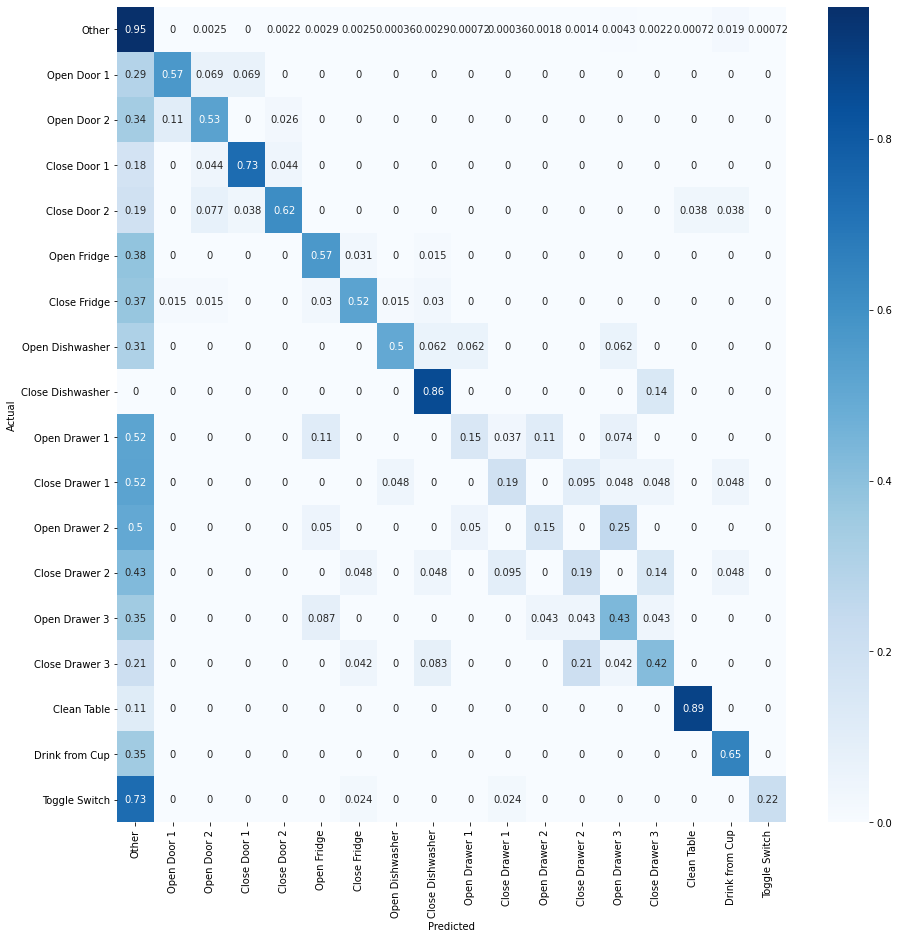

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true_n, y_pred_n, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true_n, y_pred_n, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.92      0.95      0.94      2771
     Open Door 1       0.87      0.57      0.69        58
     Open Door 2       0.56      0.53      0.54        38
    Close Door 1       0.87      0.73      0.80        45
    Close Door 2       0.64      0.62      0.63        26
     Open Fridge       0.70      0.57      0.63        65
    Close Fridge       0.74      0.52      0.61        67
 Open Dishwasher       0.73      0.50      0.59        16
Close Dishwasher       0.44      0.86      0.59        14
   Open Drawer 1       0.50      0.15      0.23        27
  Close Drawer 1       0.44      0.19      0.27        21
   Open Drawer 2       0.25      0.15      0.19        20
  Close Drawer 2       0.25      0.19      0.22        21
   Open Drawer 3       0.31      0.43      0.36        23
  Close Drawer 3       0.43      0.42      0.43        24
     Clean Table       0.95      0.89      0.92        61
  Drink from 

In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true_n, y_prob_n, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_n, y_prob_n, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.941
One-vs-Rest ROC AUC scores: 0.928


Performance neglecting Null class


In [ ]:
mask = y_true!=0
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

precision, recall, fscore, _= metrics.precision_recall_fscore_support(y_true_0, y_pred_0, average='weighted',zero_division = 0)
print('precision_without_0 = {:.3}\n recall_without_0 = {:.3}\n fscore_without_0 = {:.3}'.format(precision,recall,fscore) )

precision_without_0 = 0.835
 recall_without_0 = 0.477
 fscore_without_0 = 0.592


In [ ]:
# Classification report
report = metrics.classification_report(y_true_0, y_pred_0, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.00      0.00      0.00         0
     Open Door 1       0.92      0.51      0.66        45
     Open Door 2       0.81      0.64      0.72        75
    Close Door 1       0.68      0.41      0.51        46
    Close Door 2       0.96      0.74      0.83        65
     Open Fridge       0.86      0.49      0.62       183
    Close Fridge       0.88      0.75      0.81       124
 Open Dishwasher       0.85      0.28      0.42        78
Close Dishwasher       0.76      0.35      0.48        62
   Open Drawer 1       0.40      0.26      0.31        31
  Close Drawer 1       0.64      0.27      0.38        33
   Open Drawer 2       0.22      0.06      0.09        35
  Close Drawer 2       0.36      0.19      0.25        21
   Open Drawer 3       0.67      0.54      0.59        56
  Close Drawer 3       0.73      0.65      0.69        46
     Clean Table       1.00      0.38      0.55        79
  Drink from 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# AUC ROC scores
y_prob_0=y_prob[mask,1:]#remove 1st column(class 0)
new_weigths=np.sum(y_prob_0,axis=1).reshape((y_pred_0.shape[0],1))#sum by row
y_prob_0=y_prob_0/new_weigths#divide each element in a row by the sum of the row
weighted_roc_auc_ovo = roc_auc_score(y_true_0, y_prob_0, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_0, y_prob_0, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.943
One-vs-Rest ROC AUC scores: 0.954


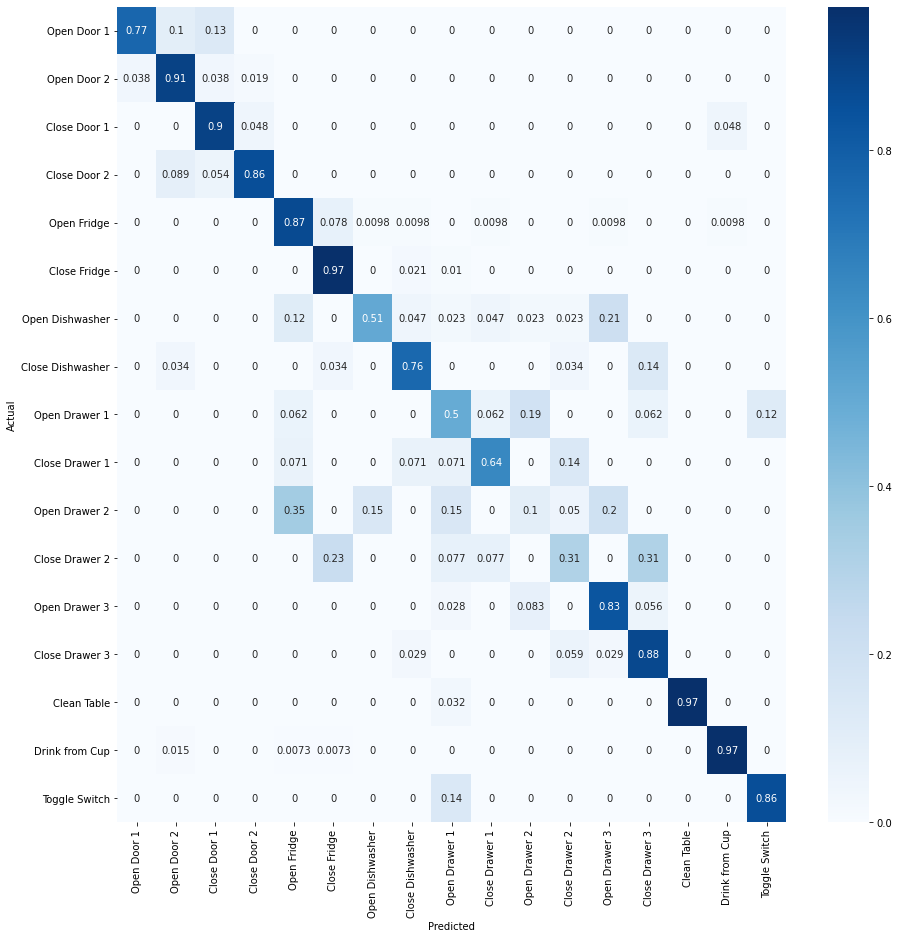

In [ ]:
# Confusion matrix
mask = (np.logical_and(y_true!=0, y_pred!=0))
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

conf_mat = confusion_matrix(y_true_0, y_pred_0, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label[1:], yticklabels=id2label[1:])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 5.2 Dataset 2 - opportunity_low



Load

In [ ]:
# Load the data from .h5 
f = h5py.File('/content/gdrive/My Drive/Colab Notebooks/dataset/opportunity_low.h5', 'r') 

#load training set
x_train = f.get('training').get('x')[()]
y_train = f.get('training').get('y')[()].astype(np.int)

#load validation set
x_valid = f.get('validation').get('x')[()]
y_valid = f.get('validation').get('y')[()].astype(np.int)

#load test set
x_test = f.get('test').get('x')[()]
y_test = f.get('test').get('y')[()].astype(np.int)

#load noise test set
x_test_noise = f.get('test_noise').get('x')[()]
y_test_noise = f.get('test_noise').get('y')[()].astype(np.int)

#check the shape
print("x_train shape = ", x_train.shape)
print("y_train shape =", y_train.shape)

print("x_valid shape = ", x_valid.shape)
print("y_valid shape =", y_valid.shape)

print("x_test shape =" , x_test.shape)
print("y_test shape =", y_test.shape)

print("x_test_noise shape =" , x_test_noise.shape)
print("y_test_noise shape =", y_test_noise.shape)
   

x_train shape =  (622511, 12)
y_train shape = (622511,)
x_valid shape =  (62747, 12)
y_valid shape = (62747,)
x_test shape = (117601, 12)
y_test shape = (117601,)
x_test_noise shape = (51465, 12)
y_test_noise shape = (51465,)


In [ ]:
input_width = 30
x_train_segmented, y_train_segmented = segment(x_train, y_train, input_width)
x_valid_segmented, y_valid_segmented = segment(x_valid, y_valid, input_width)
x_test_segmented, y_test_segmented = segment(x_test, y_test, input_width)
x_test_noise_segmented, y_test_noise_segmented = segment(x_test_noise, y_test_noise, input_width)

In [ ]:
# one hot-encode (not necessary using 'sparse_categorical_crossentropy')

y_train_segmented=pd.get_dummies(y_train_segmented)
y_valid_segmented=pd.get_dummies(y_valid_segmented)
y_test_segmented_original = y_test_segmented
y_test_segmented=pd.get_dummies(y_test_segmented) 
y_test_noise_segmented_original = y_test_noise_segmented
y_test_noise_segmented=pd.get_dummies(y_test_segmented) 

In [ ]:
# Convert to tensor and change dtypes to speed up computations on the GPU

x_train_segmented = tf.convert_to_tensor(x_train_segmented, tf.float32)
x_valid_segmented = tf.convert_to_tensor(x_valid_segmented, tf.float32)
x_test_segmented = tf.convert_to_tensor(x_test_segmented, tf.float32)
x_test_noise_segmented = tf.convert_to_tensor(x_test_noise_segmented, tf.float32)

y_train_segmented = tf.convert_to_tensor(y_train_segmented, tf.int8)
y_valid_segmented = tf.convert_to_tensor(y_valid_segmented, tf.int8)
y_test_segmented = tf.convert_to_tensor(y_test_segmented, tf.int8)
y_test_noise_segmented = tf.convert_to_tensor(y_test_noise_segmented, tf.int8)

In [ ]:
# check the shape
print("x_train_segmented shape =",x_train_segmented.shape)
print("y_train_segmented shape =",y_train_segmented.shape)

print("x_valid_segmented shape =",x_valid_segmented.shape)
print("y_valid_segmented shape =",y_valid_segmented.shape)

print("x_test_segmented shape =",x_test_segmented.shape)
print("y_test_segmented shape =",y_test_segmented.shape)

print("x_test_noise_segmented shape =",x_test_noise_segmented.shape)
print("y_test_noise_segmented shape =",y_test_noise_segmented.shape)

x_train_segmented shape = (41499, 30, 12)
y_train_segmented shape = (41499, 18)
x_valid_segmented shape = (4182, 30, 12)
y_valid_segmented shape = (4182, 18)
x_test_segmented shape = (7839, 30, 12)
y_test_segmented shape = (7839, 18)
x_test_noise_segmented shape = (3430, 30, 12)
y_test_noise_segmented shape = (7839, 18)


#### 5.2.1 CNN + RNN model
Two 1D convolutional layers, two GRU units and two dense layers.


In [ ]:
def model_CNN_RNN(input_shape):
    X_input = layers.Input(input_shape)
    
    X = Conv1D(filters=128,
               kernel_size=8, 
               strides=1,
               name='conv1',
               activation = 'relu')(X_input)
    X= BatchNormalization(axis=2)(X) 
    X=Dropout(0.1)(X)
    
    X = Conv1D(filters=128,
               kernel_size=3, 
               strides=1,
               name='conv2',
               activation = 'relu')(X)
    X= BatchNormalization(axis=2)(X)
    X=Dropout(0.25)(X)
    
    X = CuDNNGRU(units = 128, return_sequences= True)(X)
    X = CuDNNGRU(units = 128, return_sequences= True)(X)

    X = layers.Flatten()(X) 
    X = Dense(units=128, activation='relu')(X)
    X=Dropout(0.25)(X)
      
    X = Dense(units=18, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='model_CNN_RNN')

    return model

In [ ]:
# Compile the model
input_shape = x_train_segmented.shape[1:]
model_CNN_RNN = model_CNN_RNN(input_shape)

model_CNN_RNN.compile(optimizer = 'adam',
                      loss =  CategoricalCrossentropy(),
                      metrics = F1Score(num_classes = 18, average='weighted'))
model_CNN_RNN.summary()

Model: "model_CNN_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30, 12)]          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 23, 128)           12416     
_________________________________________________________________
batch_normalization_4 (Batch (None, 23, 128)           512       
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 128)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 21, 128)           49280     
_________________________________________________________________
batch_normalization_5 (Batch (None, 21, 128)           512       
_________________________________________________________________
dropout_8 (Dropout)          (None, 21, 128)         

In [ ]:
# interrupt training when it measures no progress on the validation set for a number of epochs (patience)
early_stopping = EarlyStopping(monitor='val_f1_score', patience=8, mode='max')

In [ ]:
# Save the model when its performance on the validation set is the best so far
model_checkpoint = ModelCheckpoint(filepath= datapath + '/models/opp_low.h5', save_weights_only=False, monitor='val_f1_score',
                                                                mode='max', save_best_only=True)

In [ ]:
history = model_CNN_RNN.fit (x = x_train_segmented,
                            y = y_train_segmented, 
                            epochs = epochs, 
                            batch_size = batch_size, 
                            callbacks=[early_stopping, model_checkpoint],
                            validation_data=(x_valid_segmented, y_valid_segmented))

Epoch 1/128
649/649 [==============================] - 10s 15ms/step - loss: 1.0533 - f1_score: 0.6740 - val_loss: 0.6068 - val_f1_score: 0.7937
Epoch 2/128
649/649 [==============================] - 8s 12ms/step - loss: 0.7340 - f1_score: 0.7683 - val_loss: 0.5505 - val_f1_score: 0.8245
Epoch 3/128
649/649 [==============================] - 8s 12ms/step - loss: 0.6232 - f1_score: 0.8022 - val_loss: 0.5150 - val_f1_score: 0.8299
Epoch 4/128
649/649 [==============================] - 8s 12ms/step - loss: 0.5418 - f1_score: 0.8287 - val_loss: 0.5512 - val_f1_score: 0.8201
Epoch 5/128
649/649 [==============================] - 8s 12ms/step - loss: 0.4996 - f1_score: 0.8425 - val_loss: 0.5471 - val_f1_score: 0.8453
Epoch 6/128
649/649 [==============================] - 8s 12ms/step - loss: 0.4545 - f1_score: 0.8565 - val_loss: 0.5312 - val_f1_score: 0.8375
Epoch 7/128
649/649 [==============================] - 8s 12ms/step - loss: 0.4242 - f1_score: 0.8634 - val_loss: 0.5039 - val_f1_score

In [ ]:
# Load the best model
model_CNN_RNN = tf.keras.models.load_model(datapath + '/models/opp_low.h5')

info = model_CNN_RNN.evaluate(x_valid_segmented, y_valid_segmented, verbose=3)
print("Final Loss on Validation Set: {}; \nFinal F1 Score on Validation Set: {}".format(info[0], info[1]))

Final Loss on Validation Set: 0.6493817567825317; 
Final F1 Score on Validation Set: 0.8549792170524597


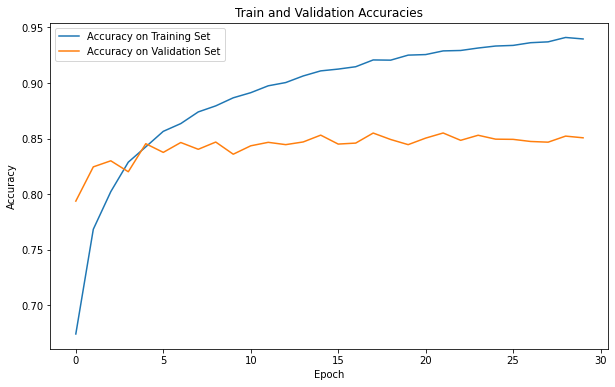

In [ ]:
# Learning curves
plot_accuracy(history)
fig=plt.gcf()
fig.savefig(datapath + '/models/opp_low_lc.png')

Evaluation

Test set without noise

In [ ]:
# Performance on test set
y_true=y_test_segmented_original
val_steps = int(np.ceil(len(x_test_segmented)/64))
y_prob=model_CNN_RNN.predict(x_test_segmented, batch_size=64, steps=val_steps)
y_pred=np.argmax(y_prob,axis=1)
precision, recall, fscore_opp_low, _= metrics.precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp_low) )

precision = 0.861
 recall = 0.874
 fscore = 0.862


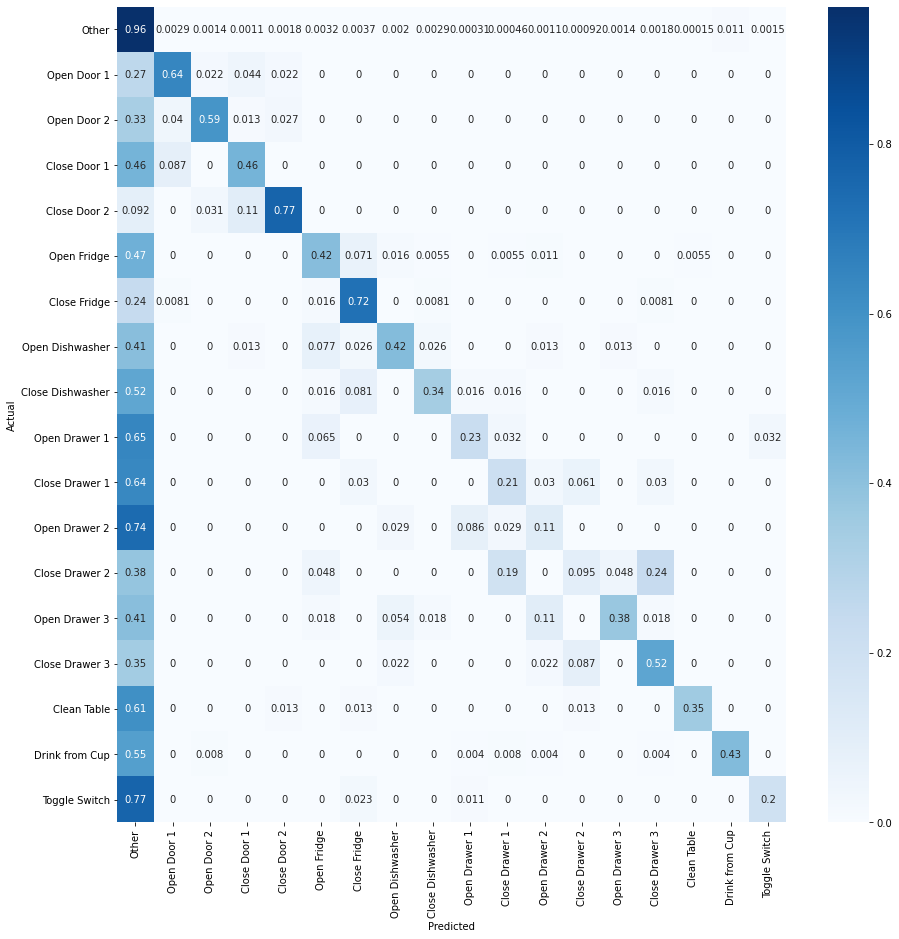

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true, y_pred, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.91      0.96      0.94      6522
     Open Door 1       0.52      0.64      0.57        45
     Open Door 2       0.76      0.59      0.66        75
    Close Door 1       0.54      0.46      0.49        46
    Close Door 2       0.76      0.77      0.76        65
     Open Fridge       0.69      0.42      0.52       183
    Close Fridge       0.65      0.72      0.68       124
 Open Dishwasher       0.61      0.42      0.50        78
Close Dishwasher       0.47      0.34      0.39        62
   Open Drawer 1       0.47      0.23      0.30        31
  Close Drawer 1       0.35      0.21      0.26        33
   Open Drawer 2       0.17      0.11      0.14        35
  Close Drawer 2       0.13      0.10      0.11        21
   Open Drawer 3       0.66      0.38      0.48        56
  Close Drawer 3       0.52      0.52      0.52        46
     Clean Table       0.93      0.35      0.51        79
  Drink from 

In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.917
One-vs-Rest ROC AUC scores: 0.899


Test set with noise 

In [ ]:
# Performance on test set with noise
y_true_n = y_test_noise_segmented_original

val_steps = int(np.ceil(len(x_test_noise_segmented)/batch_size))
y_prob_n=model_CNN_RNN.predict(x_test_noise_segmented, batch_size=64, steps=val_steps)
y_pred_n=np.argmax(y_prob_n,axis=1)
precision, recall, fscore_opp_low_n, _= metrics.precision_recall_fscore_support(y_true_n, y_pred_n, average='weighted',zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp_low_n) )

precision = 0.85
 recall = 0.859
 fscore = 0.851


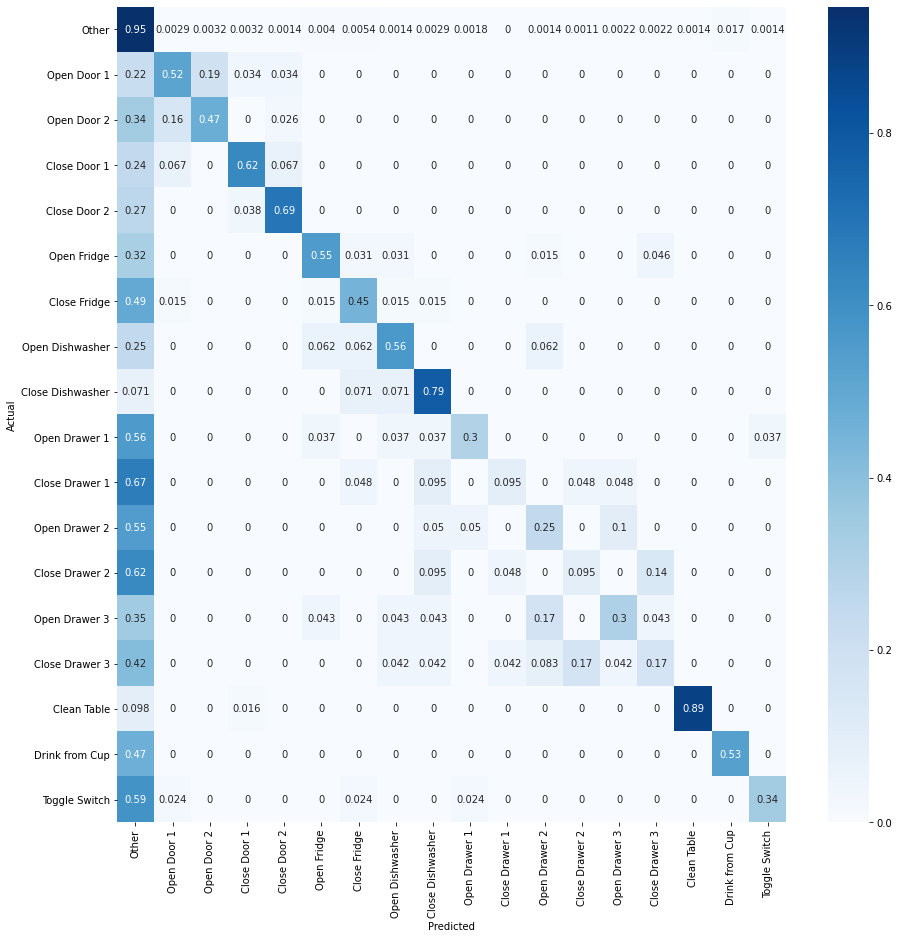

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true_n, y_pred_n, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true_n, y_pred_n, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.91      0.95      0.93      2771
     Open Door 1       0.61      0.52      0.56        58
     Open Door 2       0.47      0.47      0.47        38
    Close Door 1       0.68      0.62      0.65        45
    Close Door 2       0.64      0.69      0.67        26
     Open Fridge       0.71      0.55      0.62        65
    Close Fridge       0.59      0.45      0.51        67
 Open Dishwasher       0.45      0.56      0.50        16
Close Dishwasher       0.39      0.79      0.52        14
   Open Drawer 1       0.53      0.30      0.38        27
  Close Drawer 1       0.50      0.10      0.16        21
   Open Drawer 2       0.29      0.25      0.27        20
  Close Drawer 2       0.20      0.10      0.13        21
   Open Drawer 3       0.41      0.30      0.35        23
  Close Drawer 3       0.24      0.17      0.20        24
     Clean Table       0.93      0.89      0.91        61
  Drink from 

In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true_n, y_prob_n, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_n, y_prob_n, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.934
One-vs-Rest ROC AUC scores: 0.922


Performance neglecting Null class


In [ ]:
mask = y_true!=0
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

precision, recall, fscore, _= metrics.precision_recall_fscore_support(y_true_0, y_pred_0, average='weighted',zero_division = 0)
print('precision_without_0 = {:.3}\n recall_without_0 = {:.3}\n fscore_without_0 = {:.3}'.format(precision,recall,fscore) )

precision_without_0 = 0.833
 recall_without_0 = 0.44
 fscore_without_0 = 0.559


In [ ]:
# Classification report
report = metrics.classification_report(y_true_0, y_pred_0, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.00      0.00      0.00         0
     Open Door 1       0.78      0.64      0.71        45
     Open Door 2       0.90      0.59      0.71        75
    Close Door 1       0.66      0.46      0.54        46
    Close Door 2       0.93      0.77      0.84        65
     Open Fridge       0.85      0.42      0.56       183
    Close Fridge       0.79      0.72      0.75       124
 Open Dishwasher       0.80      0.42      0.55        78
Close Dishwasher       0.81      0.34      0.48        62
   Open Drawer 1       0.54      0.23      0.32        31
  Close Drawer 1       0.41      0.21      0.28        33
   Open Drawer 2       0.25      0.11      0.16        35
  Close Drawer 2       0.22      0.10      0.13        21
   Open Drawer 3       0.91      0.38      0.53        56
  Close Drawer 3       0.71      0.52      0.60        46
     Clean Table       0.97      0.35      0.52        79
  Drink from 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# AUC ROC scores
y_prob_0=y_prob[mask,1:]#remove 1st column(class 0)
new_weigths=np.sum(y_prob_0,axis=1).reshape((y_pred_0.shape[0],1))#sum by row
y_prob_0=y_prob_0/new_weigths#divide each element in a row by the sum of the row
weighted_roc_auc_ovo = roc_auc_score(y_true_0, y_prob_0, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_0, y_prob_0, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.934
One-vs-Rest ROC AUC scores: 0.944


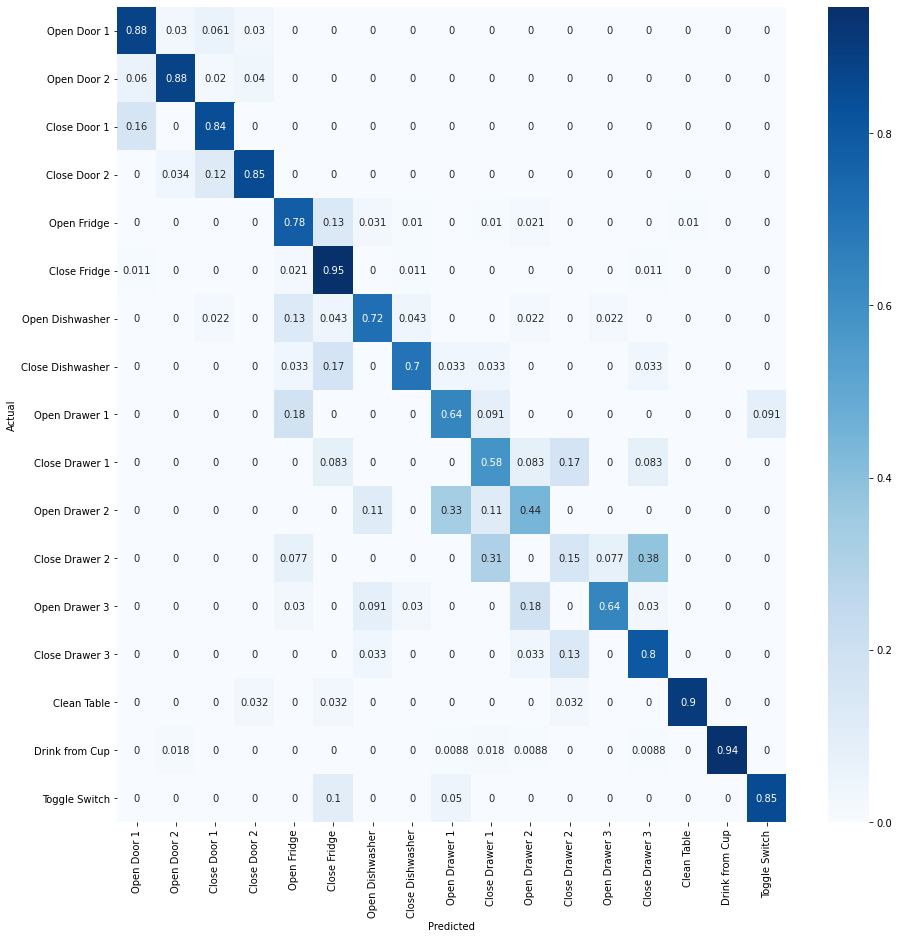

In [ ]:
# Confusion matrix
mask = (np.logical_and(y_true!=0, y_pred!=0))
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

conf_mat = confusion_matrix(y_true_0, y_pred_0, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label[1:], yticklabels=id2label[1:])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### 5.2.2 CNN model
Two 2D convolutional layers, and three dense layers

In [ ]:
def model_CNN(input_shape):
    X_input = Input(input_shape)
    
    X = Conv2D(filters=128,
               kernel_size=(8, 1), 
               strides=(1,1),
               name='conv00', 
               padding='same')(X_input)
    X= BatchNormalization(axis=2)(X)
    X=Activation('elu')(X)
    X=Dropout(0.1)(X)
    
    X = Conv2D(filters=128,
               kernel_size=(3, 3),
               strides=(1,1),
               name='conv01', 
               padding='same')(X)
    X= BatchNormalization(axis=2)(X)
    X=Activation('elu')(X)
    X= MaxPooling2D(pool_size=(2, 2))(X)
    X=Dropout(0.25)(X)
    
    X = Flatten()(X) 
    X = Dense(units=128, activation='elu')(X)
    X=Dropout(0.25)(X)
    
    X = Flatten()(X) 
    X = Dense(units=128, activation='elu')(X)
    X=Dropout(0.25)(X)
      
    X = Dense(units=18, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='model_CNN')

    return model

In [ ]:
# Compile the model
input_shape = (x_train_segmented.shape[1:] + (1,))  
model_CNN = model_CNN(input_shape)

model_CNN.compile(optimizer = 'adam',
                      loss =  CategoricalCrossentropy(),
                      metrics = F1Score(num_classes = 18, average='weighted'))
model_CNN.summary()

Model: "model_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 30, 12, 1)]       0         
_________________________________________________________________
conv00 (Conv2D)              (None, 30, 12, 128)       1152      
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 12, 128)       48        
_________________________________________________________________
activation_2 (Activation)    (None, 30, 12, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 12, 128)       0         
_________________________________________________________________
conv01 (Conv2D)              (None, 30, 12, 128)       147584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 12, 128)       48

In [ ]:
#interrupt training when it measures no progress on the validation set for a number of epochs (patience)
early_stopping = EarlyStopping(monitor='val_f1_score', patience=8, mode='max')

In [ ]:
# Save the model when its performance on the validation set is the best so far
model_checkpoint = ModelCheckpoint(filepath= datapath + '/models/opp_low_c.h5', save_weights_only=False, monitor='val_f1_score',
                                                                mode='max', save_best_only=True)

In [ ]:
history = model_CNN.fit (x = x_train_segmented,
                            y = y_train_segmented, 
                            epochs = epochs, 
                            batch_size = batch_size, 
                            callbacks=[early_stopping, model_checkpoint],
                            validation_data=(x_valid_segmented, y_valid_segmented))

Epoch 1/128
649/649 [==============================] - 10s 15ms/step - loss: 1.3529 - f1_score: 0.5891 - val_loss: 0.7649 - val_f1_score: 0.7501
Epoch 2/128
649/649 [==============================] - 10s 15ms/step - loss: 1.1518 - f1_score: 0.6245 - val_loss: 0.6689 - val_f1_score: 0.7623
Epoch 3/128
649/649 [==============================] - 10s 15ms/step - loss: 1.0198 - f1_score: 0.6610 - val_loss: 0.6363 - val_f1_score: 0.7781
Epoch 4/128
649/649 [==============================] - 10s 15ms/step - loss: 0.9485 - f1_score: 0.6789 - val_loss: 0.5933 - val_f1_score: 0.7957
Epoch 5/128
649/649 [==============================] - 10s 15ms/step - loss: 0.8661 - f1_score: 0.7108 - val_loss: 0.5627 - val_f1_score: 0.7985
Epoch 6/128
649/649 [==============================] - 10s 15ms/step - loss: 0.7929 - f1_score: 0.7389 - val_loss: 0.5518 - val_f1_score: 0.8066
Epoch 7/128
649/649 [==============================] - 10s 15ms/step - loss: 0.7398 - f1_score: 0.7552 - val_loss: 0.5141 - val_f1

In [ ]:
# Load the best model
model_CNN = tf.keras.models.load_model(datapath + '/models/opp_low_c.h5')

info = model_CNN.evaluate(x_valid_segmented, y_valid_segmented, verbose=3)
print("Final Loss on Validation Set: {}; \nFinal F1 Score on Validation Set: {}".format(info[0], info[1]))

Final Loss on Validation Set: 0.5097033381462097; 
Final F1 Score on Validation Set: 0.8513457179069519


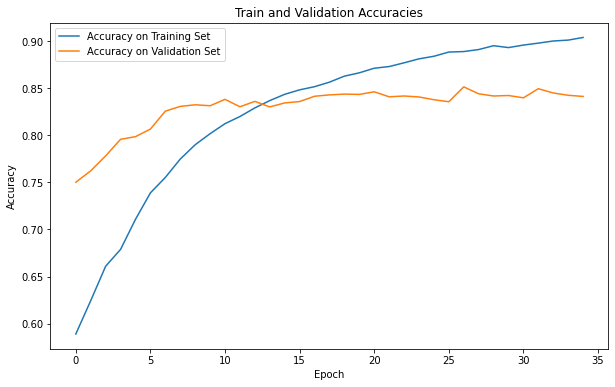

In [ ]:
# Learning curves
plot_accuracy(history)
fig=plt.gcf()
fig.savefig(datapath + '/models/opp_low_c_lc.png')

Evaluation

Test set without noise


In [ ]:
# Performance on test set
y_true=y_test_segmented_original
val_steps = int(np.ceil(len(x_test_segmented)/64))
y_prob=model_CNN.predict(x_test_segmented, batch_size=64, steps=val_steps)
y_pred=np.argmax(y_prob,axis=1)
precision, recall, fscore_opp_low_c, _= metrics.precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp_low_c) )

precision = 0.856
 recall = 0.868
 fscore = 0.854


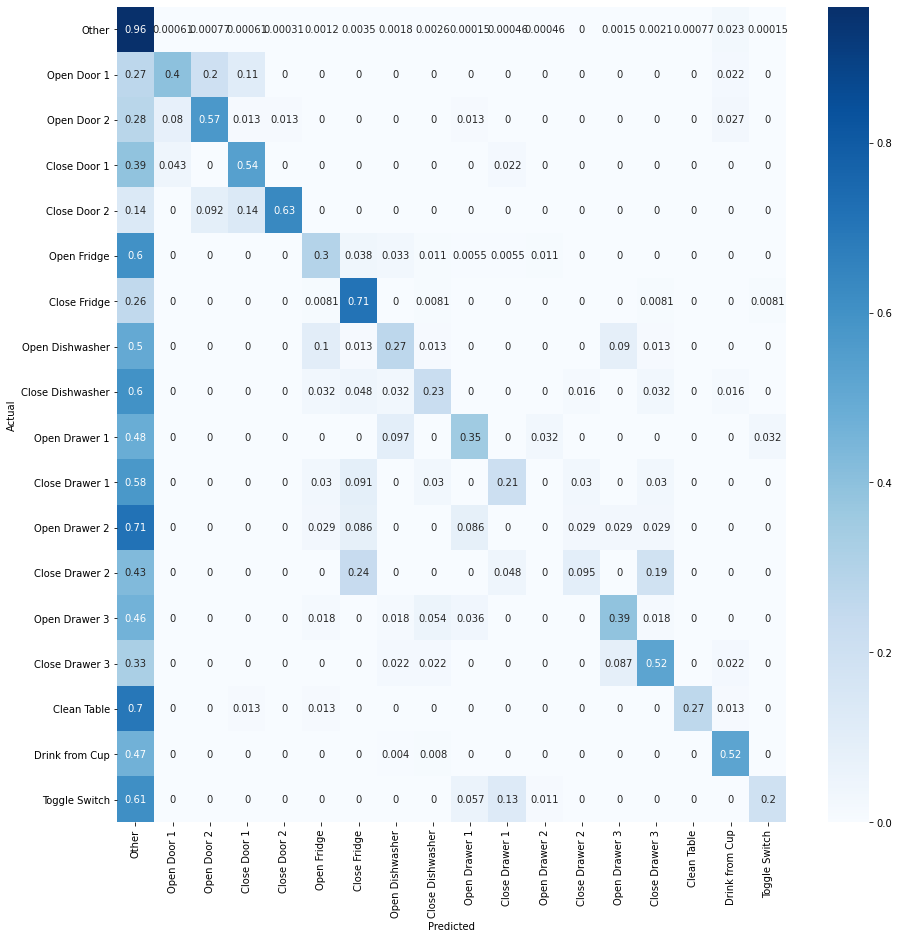

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true, y_pred, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.91      0.96      0.93      6522
     Open Door 1       0.60      0.40      0.48        45
     Open Door 2       0.68      0.57      0.62        75
    Close Door 1       0.56      0.54      0.55        46
    Close Door 2       0.93      0.63      0.75        65
     Open Fridge       0.70      0.30      0.42       183
    Close Fridge       0.66      0.71      0.68       124
 Open Dishwasher       0.45      0.27      0.34        78
Close Dishwasher       0.33      0.23      0.27        62
   Open Drawer 1       0.46      0.35      0.40        31
  Close Drawer 1       0.29      0.21      0.25        33
   Open Drawer 2       0.00      0.00      0.00        35
  Close Drawer 2       0.40      0.10      0.15        21
   Open Drawer 3       0.50      0.39      0.44        56
  Close Drawer 3       0.49      0.52      0.51        46
     Clean Table       0.81      0.27      0.40        79
  Drink from 

In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.923
One-vs-Rest ROC AUC scores: 0.902


Test set with noise 

In [ ]:
# Performance on test set with noise
y_true_n = y_test_noise_segmented_original
val_steps = int(np.ceil(len(x_test_noise_segmented)/batch_size))
y_prob_n=model_CNN.predict(x_test_noise_segmented, batch_size=64, steps=val_steps)
y_pred_n=np.argmax(y_prob_n,axis=1)
precision, recall, fscore_opp_low_c_n, _= metrics.precision_recall_fscore_support(y_true_n, y_pred_n, average='weighted',zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp_low_c_n) )

precision = 0.859
 recall = 0.862
 fscore = 0.855


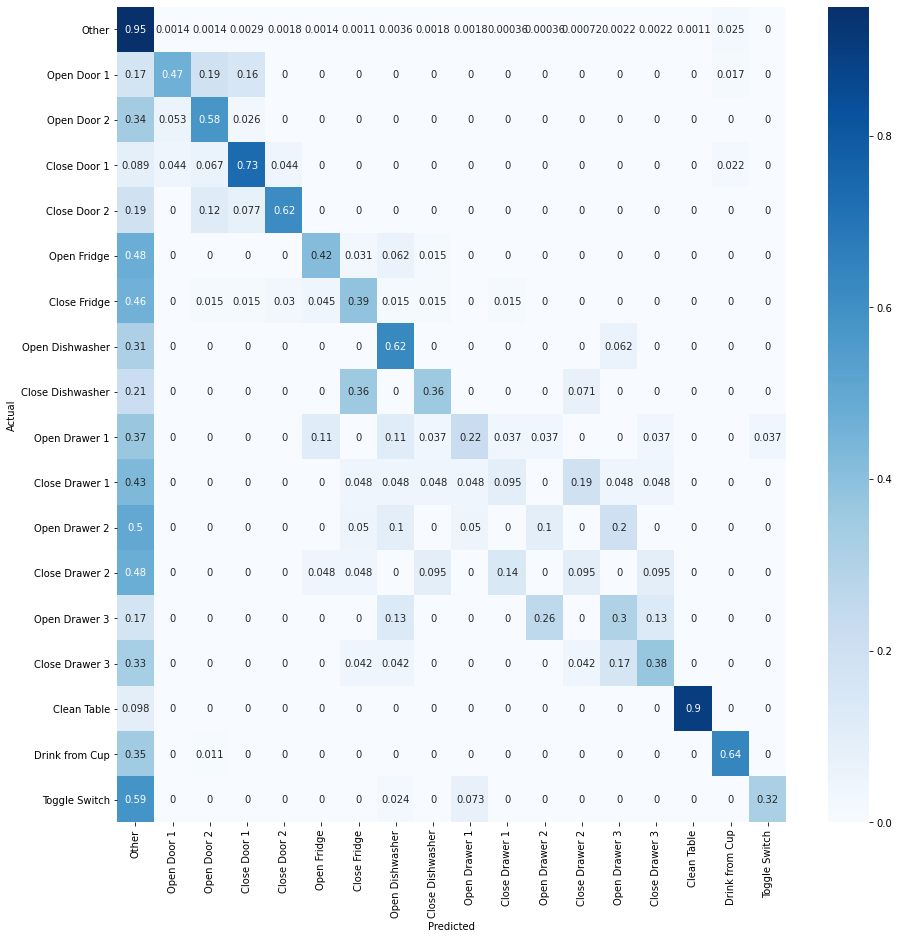

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true_n, y_pred_n, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true_n, y_pred_n, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.92      0.95      0.94      2771
     Open Door 1       0.77      0.47      0.58        58
     Open Door 2       0.49      0.58      0.53        38
    Close Door 1       0.61      0.73      0.67        45
    Close Door 2       0.64      0.62      0.63        26
     Open Fridge       0.71      0.42      0.52        65
    Close Fridge       0.65      0.39      0.49        67
 Open Dishwasher       0.28      0.62      0.38        16
Close Dishwasher       0.31      0.36      0.33        14
   Open Drawer 1       0.38      0.22      0.28        27
  Close Drawer 1       0.25      0.10      0.14        21
   Open Drawer 2       0.20      0.10      0.13        20
  Close Drawer 2       0.20      0.10      0.13        21
   Open Drawer 3       0.30      0.30      0.30        23
  Close Drawer 3       0.41      0.38      0.39        24
     Clean Table       0.95      0.90      0.92        61
  Drink from 

In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true_n, y_prob_n, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_n, y_prob_n, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.945
One-vs-Rest ROC AUC scores: 0.933


Performance neglecting Null class


In [ ]:
mask = y_true!=0
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

precision, recall, fscore, _= metrics.precision_recall_fscore_support(y_true_0, y_pred_0, average='weighted',zero_division = 0)
print('precision_without_0 = {:.3}\n recall_without_0 = {:.3}\n fscore_without_0 = {:.3}'.format(precision,recall,fscore) )

precision_without_0 = 0.76
 recall_without_0 = 0.409
 fscore_without_0 = 0.515


In [ ]:
# Classification report
report = metrics.classification_report(y_true_0, y_pred_0, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.00      0.00      0.00         0
     Open Door 1       0.69      0.40      0.51        45
     Open Door 2       0.74      0.57      0.65        75
    Close Door 1       0.61      0.54      0.57        46
    Close Door 2       0.98      0.63      0.77        65
     Open Fridge       0.78      0.30      0.43       183
    Close Fridge       0.80      0.71      0.75       124
 Open Dishwasher       0.60      0.27      0.37        78
Close Dishwasher       0.56      0.23      0.32        62
   Open Drawer 1       0.48      0.35      0.41        31
  Close Drawer 1       0.33      0.21      0.26        33
   Open Drawer 2       0.00      0.00      0.00        35
  Close Drawer 2       0.40      0.10      0.15        21
   Open Drawer 3       0.65      0.39      0.49        56
  Close Drawer 3       0.69      0.52      0.59        46
     Clean Table       1.00      0.27      0.42        79
  Drink from 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# AUC ROC scores
y_prob_0=y_prob[mask,1:]#remove 1st column(class 0)
new_weigths=np.sum(y_prob_0,axis=1).reshape((y_pred_0.shape[0],1))#sum by row
y_prob_0=y_prob_0/new_weigths#divide each element in a row by the sum of the row
weighted_roc_auc_ovo = roc_auc_score(y_true_0, y_prob_0, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_0, y_prob_0, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.933
One-vs-Rest ROC AUC scores: 0.945


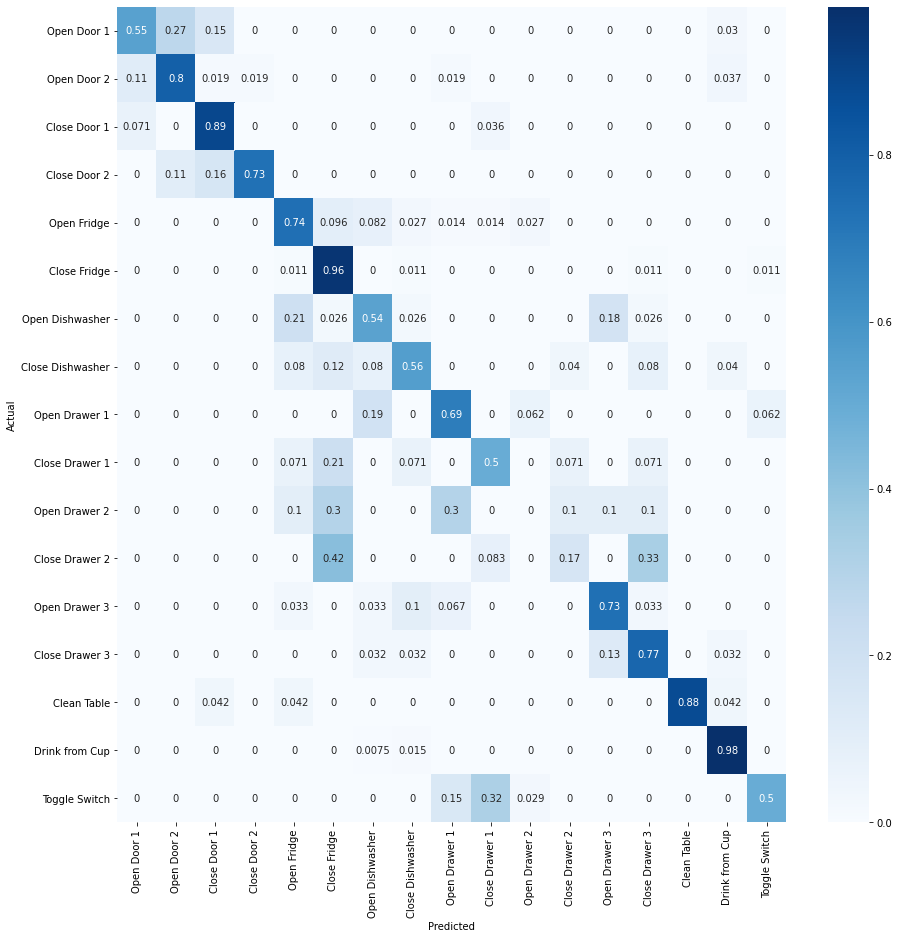

In [ ]:
# Confusion matrix
mask = (np.logical_and(y_true!=0, y_pred!=0))
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

conf_mat = confusion_matrix(y_true_0, y_pred_0, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label[1:], yticklabels=id2label[1:])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 5.3 Dataset 3 - opportunity_manual


Load

In [ ]:
#load the data from .h5 
f = h5py.File('/content/gdrive/My Drive/Colab Notebooks/dataset/opportunity_manual.h5', 'r') 

#load training set
x_train = f.get('training').get('x')[()]
y_train = f.get('training').get('y')[()].astype(np.int)

#load validation set
x_valid = f.get('validation').get('x')[()]
y_valid = f.get('validation').get('y')[()].astype(np.int)

#load test set
x_test = f.get('test').get('x')[()]
y_test = f.get('test').get('y')[()].astype(np.int)

#load noise test set
x_test_noise = f.get('test_noise').get('x')[()]
y_test_noise = f.get('test_noise').get('y')[()].astype(np.int)

#check the shape
print("x_train shape = ", x_train.shape)
print("y_train shape =", y_train.shape)

print("x_valid shape = ", x_valid.shape)
print("y_valid shape =", y_valid.shape)

print("x_test shape =" , x_test.shape)
print("y_test shape =", y_test.shape)

print("x_test_noise shape =" , x_test_noise.shape)
print("y_test_noise shape =", y_test_noise.shape)
   

x_train shape =  (41499, 90)
y_train shape = (41499,)
x_valid shape =  (4182, 90)
y_valid shape = (4182,)
x_test shape = (7839, 90)
y_test shape = (7839,)
x_test_noise shape = (3430, 90)
y_test_noise shape = (3430,)


In [ ]:
# one hot-encode (not necessary using 'sparse_categorical_crossentropy')

y_train_segmented=pd.get_dummies(y_train)
y_valid_segmented=pd.get_dummies(y_valid)
y_test_segmented_original = y_test
y_test_segmented=pd.get_dummies(y_test) 
y_test_noise_segmented_original = y_test_noise
y_test_noise_segmented=pd.get_dummies(y_test) 

In [ ]:
# reshape(expand) x_train_segmented and x_test_segmented for the CNN

x_train_segmented = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_valid_segmented = x_valid.reshape(x_valid.shape[0],x_valid.shape[1],1)
x_test_segmented = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
x_test_noise_segmented = x_test_noise.reshape(x_test_noise.shape[0],x_test_noise.shape[1],1)

In [ ]:
# Convert to tensor and change dtypes to speed up computations on the GPU

x_train_segmented = tf.convert_to_tensor(x_train_segmented, tf.float32)
x_valid_segmented = tf.convert_to_tensor(x_valid_segmented, tf.float32)
x_test_segmented = tf.convert_to_tensor(x_test_segmented, tf.float32)
x_test_noise_segmented = tf.convert_to_tensor(x_test_noise_segmented, tf.float32)

y_train_segmented = tf.convert_to_tensor(y_train_segmented, tf.int8)
y_valid_segmented = tf.convert_to_tensor(y_valid_segmented, tf.int8)
y_test_segmented = tf.convert_to_tensor(y_test_segmented, tf.int8)
y_test_noise_segmented = tf.convert_to_tensor(y_test_noise_segmented, tf.int8)

In [ ]:
# check the shape
print("x_train_segmented shape =",x_train_segmented.shape)
print("y_train_segmented shape =",y_train_segmented.shape)

print("x_valid_segmented shape =",x_valid_segmented.shape)
print("y_valid_segmented shape =",y_valid_segmented.shape)

print("x_test_segmented shape =",x_test_segmented.shape)
print("y_test_segmented shape =",y_test_segmented.shape)

print("x_test_noise_segmented shape =",x_test_noise_segmented.shape)
print("y_test_noise_segmented shape =",y_test_noise_segmented.shape)

x_train_segmented shape = (41499, 90, 1)
y_train_segmented shape = (41499, 18)
x_valid_segmented shape = (4182, 90, 1)
y_valid_segmented shape = (4182, 18)
x_test_segmented shape = (7839, 90, 1)
y_test_segmented shape = (7839, 18)
x_test_noise_segmented shape = (3430, 90, 1)
y_test_noise_segmented shape = (7839, 18)


#### 5.3.1 Manual model
Two 1D convolutional layers and two dense layers

In [ ]:
def model_manual(input_shape):
    X_input = layers.Input(input_shape)

    X = Conv1D(filters=128,
               kernel_size=9, 
               strides=1,
               name='conv1',
               activation = 'relu')(X_input)
    X= BatchNormalization(axis=2)(X) 
    X=Dropout(0.1)(X)

    X = Conv1D(filters=128,
               kernel_size=3,
               strides=1,
               name='conv2',
               activation = 'relu')(X)
    X= BatchNormalization(axis=2)(X)
    X=Dropout(0.25)(X)

    X = layers.Flatten()(X) 
    X = Dense(units=64, activation='relu')(X)
    X=Dropout(0.25)(X)
    
    X = Dense(units=18, activation='softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name='model_manual')

    return model

In [ ]:
# Compile the model
input_shape =  x_train_segmented.shape[1:]
model_manual = model_manual(input_shape)

model_manual.compile(optimizer = 'adam',
                      loss =  CategoricalCrossentropy(),
                      metrics = F1Score(num_classes = 18, average='weighted'))
model_manual.summary()


Model: "model_manual"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 90, 1)]           0         
_________________________________________________________________
conv1 (Conv1D)               (None, 82, 128)           1280      
_________________________________________________________________
batch_normalization_8 (Batch (None, 82, 128)           512       
_________________________________________________________________
dropout_14 (Dropout)         (None, 82, 128)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 80, 128)           49280     
_________________________________________________________________
batch_normalization_9 (Batch (None, 80, 128)           512       
_________________________________________________________________
dropout_15 (Dropout)         (None, 80, 128)          

In [ ]:
#interrupt training when it measures no progress on the validation set for a number of epochs (patience)
early_stopping = EarlyStopping(monitor='val_f1_score', patience=8, mode='max')

In [ ]:
# Save the model when its performance on the validation set is the best so far
model_checkpoint = ModelCheckpoint(filepath= datapath + '/models/opp_man.h5', save_weights_only=False, monitor='val_f1_score',
                                                                mode='max', save_best_only=True)

In [ ]:
history = model_manual.fit (x = x_train_segmented,
                            y = y_train_segmented, 
                            epochs = epochs, 
                            batch_size = batch_size, 
                            callbacks=[early_stopping, model_checkpoint],
                            validation_data=(x_valid_segmented, y_valid_segmented))

Epoch 1/128
649/649 [==============================] - 4s 6ms/step - loss: 1.3317 - f1_score: 0.5934 - val_loss: 0.7307 - val_f1_score: 0.7398
Epoch 2/128
649/649 [==============================] - 4s 6ms/step - loss: 1.0541 - f1_score: 0.6315 - val_loss: 0.6830 - val_f1_score: 0.7499
Epoch 3/128
649/649 [==============================] - 4s 6ms/step - loss: 0.9486 - f1_score: 0.6645 - val_loss: 0.6118 - val_f1_score: 0.7589
Epoch 4/128
649/649 [==============================] - 4s 6ms/step - loss: 0.8862 - f1_score: 0.6867 - val_loss: 0.6042 - val_f1_score: 0.7661
Epoch 5/128
649/649 [==============================] - 4s 6ms/step - loss: 0.8418 - f1_score: 0.7020 - val_loss: 0.5721 - val_f1_score: 0.7837
Epoch 6/128
649/649 [==============================] - 4s 6ms/step - loss: 0.8059 - f1_score: 0.7188 - val_loss: 0.5757 - val_f1_score: 0.7889
Epoch 7/128
649/649 [==============================] - 4s 6ms/step - loss: 0.7789 - f1_score: 0.7236 - val_loss: 0.5591 - val_f1_score: 0.7930

In [ ]:
# Load the best model
model_CNN_RNN = tf.keras.models.load_model(datapath + '/models/opp_man.h5')

info = model_CNN_RNN.evaluate(x_valid_segmented, y_valid_segmented, verbose=3)
print("Final Loss on Validation Set: {}; \nFinal F1 Score on Validation Set: {}".format(info[0], info[1]))

Final Loss on Validation Set: 0.4891017973423004; 
Final F1 Score on Validation Set: 0.851669192314148


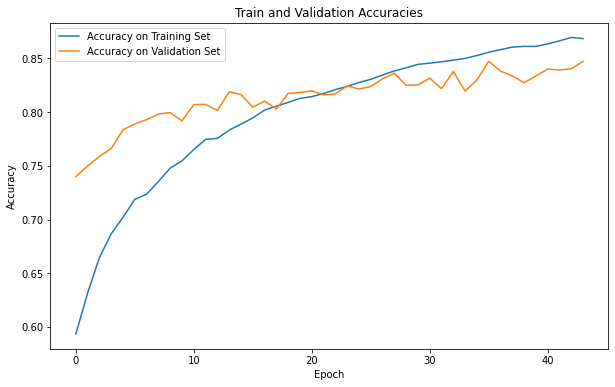

In [ ]:
# Learning curves
plot_accuracy(history)
fig=plt.gcf()
fig.savefig(datapath + '/models/opp_man_lc.png')

Evaluation

Test set without noise


In [ ]:
# Performance on test set
y_true=y_test_segmented_original

val_steps = int(np.ceil(len(x_test_segmented)/64))
y_prob=model_CNN_RNN.predict(x_test_segmented, batch_size=64, steps=val_steps)
y_pred=np.argmax(y_prob,axis=1)
precision, recall, fscore_opp_man, _= metrics.precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp_man) )

precision = 0.862
 recall = 0.879
 fscore = 0.862


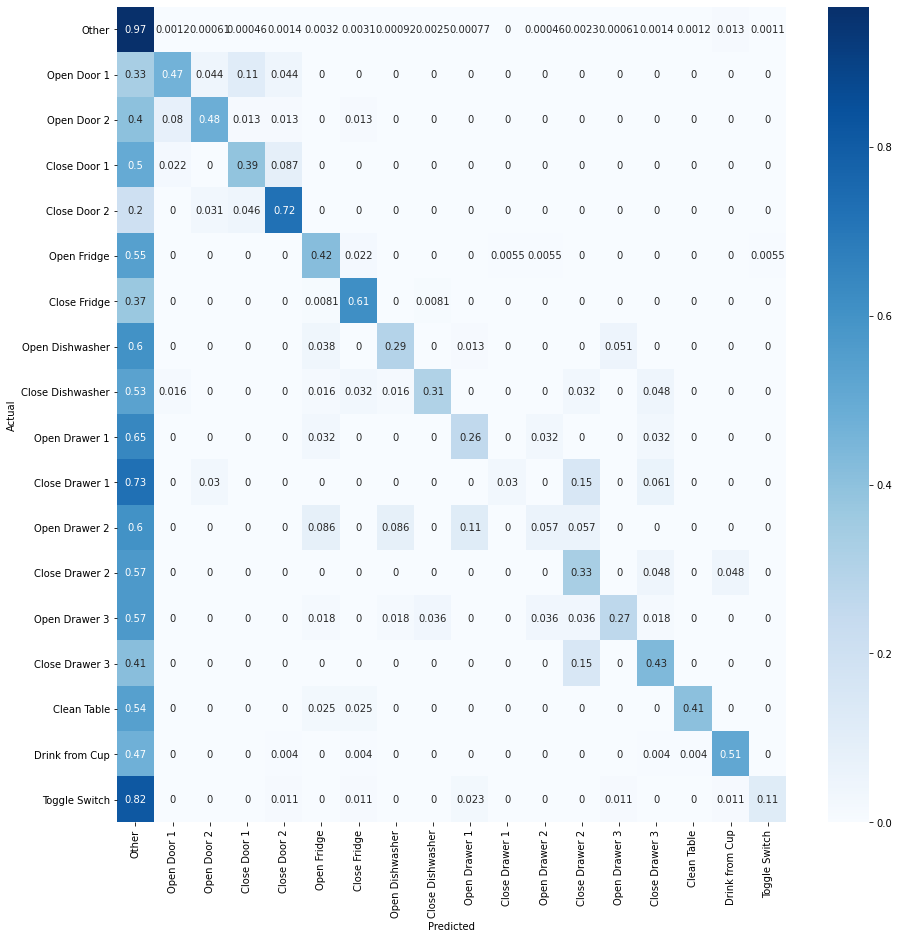

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true, y_pred, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.90      0.97      0.93      6522
     Open Door 1       0.57      0.47      0.51        45
     Open Door 2       0.80      0.48      0.60        75
    Close Door 1       0.60      0.39      0.47        46
    Close Door 2       0.72      0.72      0.72        65
     Open Fridge       0.70      0.42      0.52       183
    Close Fridge       0.71      0.61      0.66       124
 Open Dishwasher       0.68      0.29      0.41        78
Close Dishwasher       0.50      0.31      0.38        62
   Open Drawer 1       0.40      0.26      0.31        31
  Close Drawer 1       0.50      0.03      0.06        33
   Open Drawer 2       0.22      0.06      0.09        35
  Close Drawer 2       0.17      0.33      0.23        21
   Open Drawer 3       0.62      0.27      0.38        56
  Close Drawer 3       0.53      0.43      0.48        46
     Clean Table       0.78      0.41      0.53        79
  Drink from 

In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.932
One-vs-Rest ROC AUC scores: 0.912


Test set with noise 


In [ ]:
# Performance on test set with noise
y_true_n = y_test_noise_segmented_original
val_steps = int(np.ceil(len(x_test_noise_segmented)/batch_size))
y_prob_n=model_CNN_RNN.predict(x_test_noise_segmented, batch_size=64, steps=val_steps)
y_pred_n=np.argmax(y_prob_n,axis=1)
precision, recall, fscore_opp_man_n, _= metrics.precision_recall_fscore_support(y_true_n, y_pred_n, average='weighted',zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp_man_n) )

precision = 0.843
 recall = 0.86
 fscore = 0.846


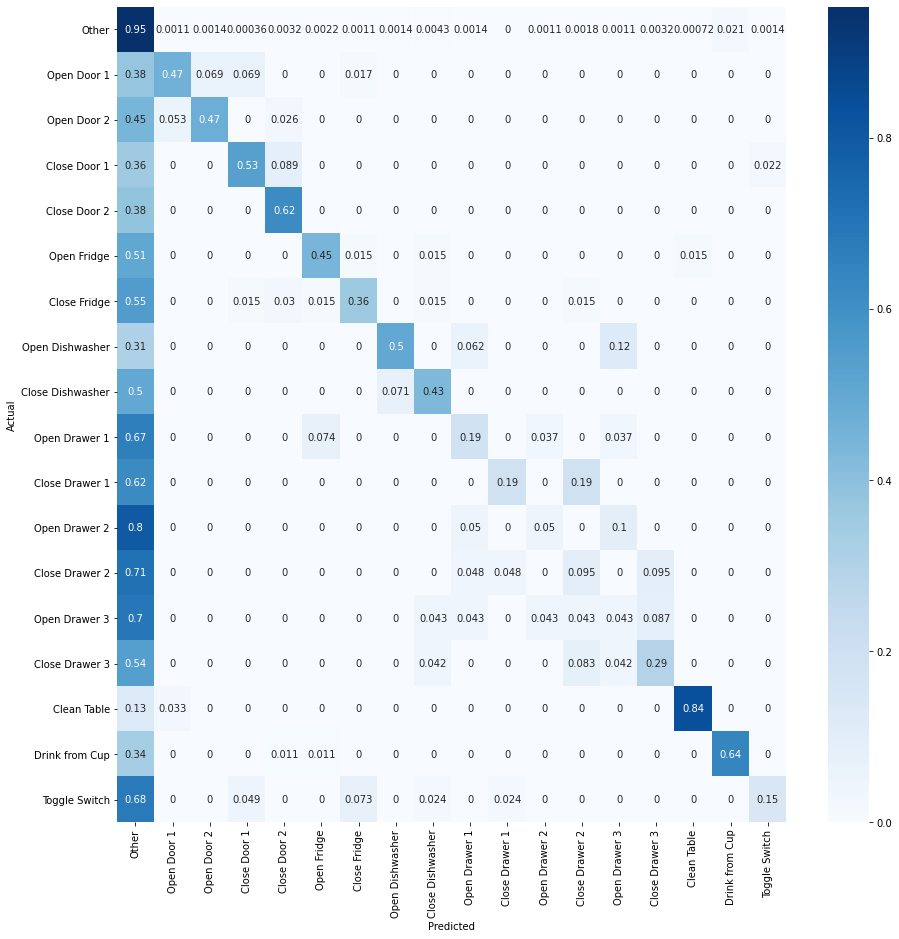

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true_n, y_pred_n, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true_n, y_pred_n, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.90      0.95      0.92      2771
     Open Door 1       0.79      0.47      0.59        58
     Open Door 2       0.69      0.47      0.56        38
    Close Door 1       0.75      0.53      0.62        45
    Close Door 2       0.48      0.62      0.54        26
     Open Fridge       0.74      0.45      0.56        65
    Close Fridge       0.75      0.36      0.48        67
 Open Dishwasher       0.62      0.50      0.55        16
Close Dishwasher       0.26      0.43      0.32        14
   Open Drawer 1       0.38      0.19      0.25        27
  Close Drawer 1       0.67      0.19      0.30        21
   Open Drawer 2       0.17      0.05      0.08        20
  Close Drawer 2       0.13      0.10      0.11        21
   Open Drawer 3       0.10      0.04      0.06        23
  Close Drawer 3       0.35      0.29      0.32        24
     Clean Table       0.94      0.84      0.89        61
  Drink from 

In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true_n, y_prob_n, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_n, y_prob_n, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.933
One-vs-Rest ROC AUC scores: 0.919


Performance neglecting Null class


In [ ]:
mask = y_true!=0
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

precision, recall, fscore, _= metrics.precision_recall_fscore_support(y_true_0, y_pred_0, average='weighted',zero_division = 0)
print('precision_without_0 = {:.3}\n recall_without_0 = {:.3}\n fscore_without_0 = {:.3}'.format(precision,recall,fscore) )

precision_without_0 = 0.837
 recall_without_0 = 0.406
 fscore_without_0 = 0.53


In [ ]:
# Classification report
report = metrics.classification_report(y_true_0, y_pred_0, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.00      0.00      0.00         0
     Open Door 1       0.68      0.41      0.51        56
     Open Door 2       0.89      0.49      0.64        95
    Close Door 1       0.71      0.34      0.46        59
    Close Door 2       0.86      0.74      0.80        82
     Open Fridge       0.84      0.40      0.54       224
    Close Fridge       0.87      0.67      0.76       160
 Open Dishwasher       0.67      0.32      0.43       100
Close Dishwasher       0.74      0.22      0.34        76
   Open Drawer 1       0.60      0.24      0.34        38
  Close Drawer 1       0.67      0.09      0.16        44
   Open Drawer 2       0.23      0.07      0.11        40
  Close Drawer 2       0.14      0.07      0.10        27
   Open Drawer 3       0.75      0.36      0.49        66
  Close Drawer 3       0.73      0.41      0.53        58
     Clean Table       0.98      0.43      0.60        98
  Drink from 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# AUC ROC scores
y_prob_0=y_prob[mask,1:]#remove 1st column(class 0)
new_weigths=np.sum(y_prob_0,axis=1).reshape((y_pred_0.shape[0],1))#sum by row
y_prob_0=y_prob_0/new_weigths#divide each element in a row by the sum of the row
weighted_roc_auc_ovo = roc_auc_score(y_true_0, y_prob_0, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_0, y_prob_0, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.934
One-vs-Rest ROC AUC scores: 0.946


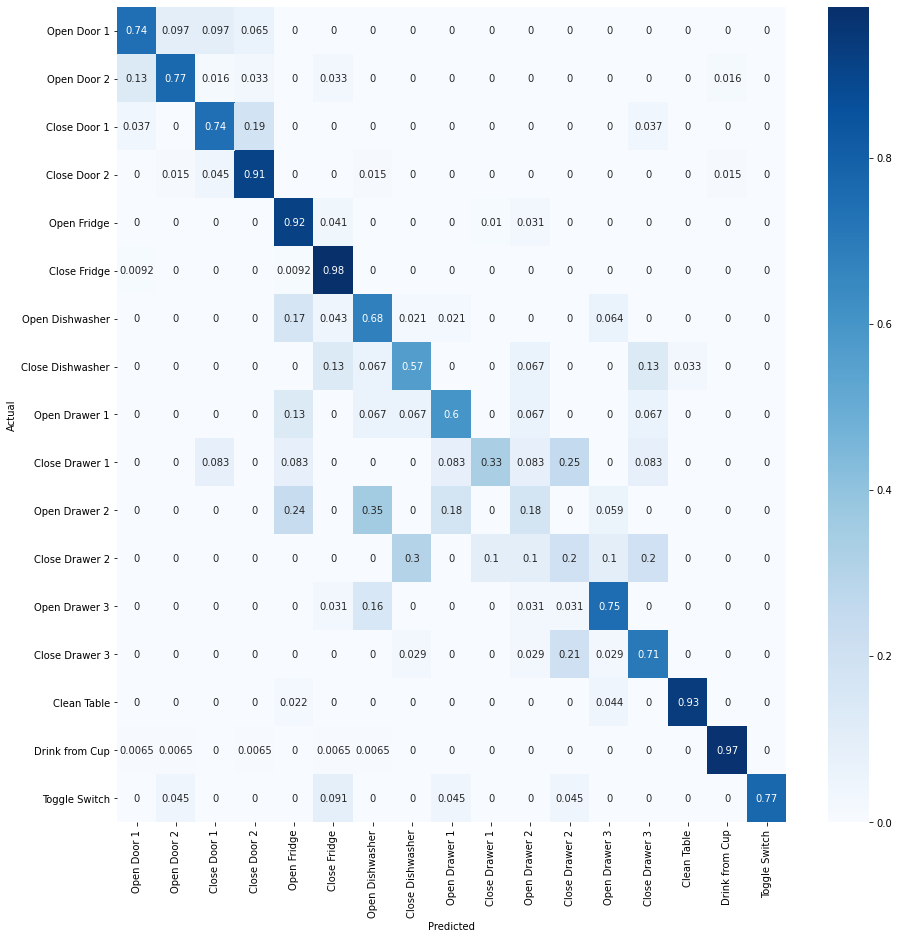

In [ ]:
# Confusion matrix
mask = (np.logical_and(y_true!=0, y_pred!=0))
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

conf_mat = confusion_matrix(y_true_0, y_pred_0, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label[1:], yticklabels=id2label[1:])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 5.4 Dataset 4 - opportunity_manual_low


Load

In [ ]:
# Load the data from .h5 
f = h5py.File('/content/gdrive/My Drive/Colab Notebooks/dataset/opportunity_manual_low.h5', 'r') 

#load training set
x_train = f.get('training').get('x')[()]
y_train = f.get('training').get('y')[()].astype(np.int)

#load validation set
x_valid = f.get('validation').get('x')[()]
y_valid = f.get('validation').get('y')[()].astype(np.int)

#load test set
x_test = f.get('test').get('x')[()]
y_test = f.get('test').get('y')[()].astype(np.int)

#load noise test set
x_test_noise = f.get('test_noise').get('x')[()]
y_test_noise = f.get('test_noise').get('y')[()].astype(np.int)

#check the shape
print("x_train shape = ", x_train.shape)
print("y_train shape =", y_train.shape)

print("x_valid shape = ", x_valid.shape)
print("y_valid shape =", y_valid.shape)

print("x_test shape =" , x_test.shape)
print("y_test shape =", y_test.shape)

print("x_test_noise shape =" , x_test_noise.shape)
print("y_test_noise shape =", y_test_noise.shape)
   

x_train shape =  (41499, 36)
y_train shape = (41499,)
x_valid shape =  (4182, 36)
y_valid shape = (4182,)
x_test shape = (7839, 36)
y_test shape = (7839,)
x_test_noise shape = (3430, 36)
y_test_noise shape = (3430,)


In [ ]:
# one hot-encode (not necessary using 'sparse_categorical_crossentropy')

y_train_segmented=pd.get_dummies(y_train)
y_valid_segmented=pd.get_dummies(y_valid)
y_test_segmented_original = y_test
y_test_segmented=pd.get_dummies(y_test) 
y_test_noise_segmented_original = y_test_noise
y_test_noise_segmented=pd.get_dummies(y_test) 

In [ ]:
# reshape(expand) x_train_segmented and x_test_segmented for the CNN

x_train_segmented = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_valid_segmented = x_valid.reshape(x_valid.shape[0],x_valid.shape[1],1)
x_test_segmented = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
x_test_noise_segmented = x_test_noise.reshape(x_test_noise.shape[0],x_test_noise.shape[1],1)

In [ ]:
# Convert to tensor and change dtypes to speed up computations on the GPU

x_train_segmented = tf.convert_to_tensor(x_train_segmented, tf.float32)
x_valid_segmented = tf.convert_to_tensor(x_valid_segmented, tf.float32)
x_test_segmented = tf.convert_to_tensor(x_test_segmented, tf.float32)
x_test_noise_segmented = tf.convert_to_tensor(x_test_noise_segmented, tf.float32)

y_train_segmented = tf.convert_to_tensor(y_train_segmented, tf.int8)
y_valid_segmented = tf.convert_to_tensor(y_valid_segmented, tf.int8)
y_test_segmented = tf.convert_to_tensor(y_test_segmented, tf.int8)
y_test_noise_segmented = tf.convert_to_tensor(y_test_noise_segmented, tf.int8)

In [ ]:
# check the shape
print("x_train_segmented shape =",x_train_segmented.shape)
print("y_train_segmented shape =",y_train_segmented.shape)

print("x_valid_segmented shape =",x_valid_segmented.shape)
print("y_valid_segmented shape =",y_valid_segmented.shape)

print("x_test_segmented shape =",x_test_segmented.shape)
print("y_test_segmented shape =",y_test_segmented.shape)

print("x_test_noise_segmented shape =",x_test_noise_segmented.shape)
print("y_test_noise_segmented shape =",y_test_noise_segmented.shape)

x_train_segmented shape = (41499, 36, 1)
y_train_segmented shape = (41499, 18)
x_valid_segmented shape = (4182, 36, 1)
y_valid_segmented shape = (4182, 18)
x_test_segmented shape = (7839, 36, 1)
y_test_segmented shape = (7839, 18)
x_test_noise_segmented shape = (3430, 36, 1)
y_test_noise_segmented shape = (7839, 18)


#### 5.4.1 Manual model
Two 1D onvolutional layers and two dense layers

In [ ]:
def model_manual(input_shape):
    X_input = layers.Input(input_shape)

    X = Conv1D(filters=128,
               kernel_size=9, 
               strides=1,
               name='conv1',
               activation = 'relu')(X_input)
    X= BatchNormalization(axis=2)(X) 
    X=Dropout(0.1)(X)

    X = Conv1D(filters=128,
               kernel_size=3,
               strides=1,
               name='conv2',
               activation = 'relu')(X)
    X= BatchNormalization(axis=2)(X)
    X=Dropout(0.25)(X)

    X = layers.Flatten()(X) 
    X = Dense(units=64, activation='relu')(X)
    X=Dropout(0.25)(X)

    X = Dense(units=18, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='model_manual_low')

    return model

In [ ]:
# Compile the model
input_shape =  x_train_segmented.shape[1:]
model_manual = model_manual(input_shape)

model_manual.compile(optimizer = 'adam',
                      loss =  CategoricalCrossentropy(),
                      metrics = F1Score(num_classes = 18, average='weighted'))
model_manual.summary()

Model: "model_manual_low"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 36, 1)]           0         
_________________________________________________________________
conv1 (Conv1D)               (None, 28, 128)           1280      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 128)           512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 128)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 26, 128)           49280     
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 128)           512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 26, 128)      

In [ ]:
#interrupt training when it measures no progress on the validation set for a number of epochs (patience)
early_stopping = EarlyStopping(monitor='val_f1_score', patience=8, mode='max')

In [ ]:
# Save the model when its performance on the validation set is the best so far
model_checkpoint = ModelCheckpoint(filepath= datapath + '/models/opp_man_low.h5', save_weights_only=False, monitor='val_f1_score',
                                                                mode='max', save_best_only=True)

In [ ]:
history = model_manual.fit (x = x_train_segmented,
                            y = y_train_segmented, 
                            epochs = epochs, 
                            batch_size = batch_size, 
                            callbacks=[early_stopping, model_checkpoint],
                            validation_data=(x_valid_segmented, y_valid_segmented))

Epoch 1/128
649/649 [==============================] - 4s 6ms/step - loss: 1.3156 - f1_score: 0.6035 - val_loss: 0.8263 - val_f1_score: 0.7389
Epoch 2/128
649/649 [==============================] - 3s 5ms/step - loss: 1.1425 - f1_score: 0.6188 - val_loss: 0.7526 - val_f1_score: 0.7410
Epoch 3/128
649/649 [==============================] - 4s 6ms/step - loss: 1.0662 - f1_score: 0.6329 - val_loss: 0.7426 - val_f1_score: 0.7485
Epoch 4/128
649/649 [==============================] - 4s 5ms/step - loss: 1.0240 - f1_score: 0.6447 - val_loss: 0.7049 - val_f1_score: 0.7661
Epoch 5/128
649/649 [==============================] - 3s 5ms/step - loss: 0.9941 - f1_score: 0.6568 - val_loss: 0.7016 - val_f1_score: 0.7490
Epoch 6/128
649/649 [==============================] - 3s 5ms/step - loss: 0.9715 - f1_score: 0.6622 - val_loss: 0.7015 - val_f1_score: 0.7492
Epoch 7/128
649/649 [==============================] - 3s 5ms/step - loss: 0.9512 - f1_score: 0.6708 - val_loss: 0.6780 - val_f1_score: 0.7569

In [ ]:
# Load the best model
model_CNN_RNN = tf.keras.models.load_model(datapath + '/models/opp_man_low.h5')

info = model_CNN_RNN.evaluate(x_valid_segmented, y_valid_segmented, verbose=3)
print("Final Loss on Validation Set: {}; \nFinal F1 Score on Validation Set: {}".format(info[0], info[1]))

Final Loss on Validation Set: 0.5992355346679688; 
Final F1 Score on Validation Set: 0.8054648041725159


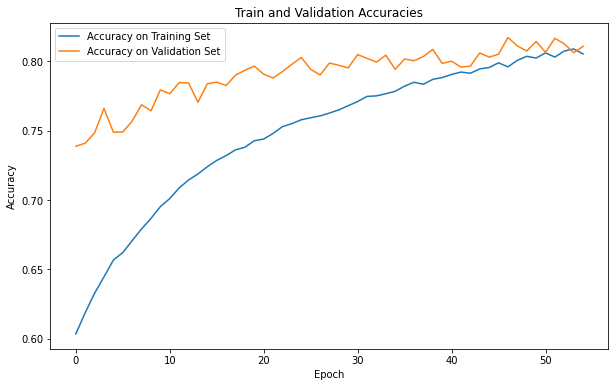

In [ ]:
# Learning curves
plot_accuracy(history)
fig=plt.gcf()
fig.savefig(datapath + '/models/opp_man_low_lc.png')

Evaluation

Test set without noise


In [ ]:
# Performance on test set
y_true=y_test_segmented_original

val_steps = int(np.ceil(len(x_test_segmented)/64))
y_prob=model_CNN_RNN.predict(x_test_segmented, batch_size=64, steps=val_steps)
y_pred=np.argmax(y_prob,axis=1)
precision, recall, fscore_opp_man_low, _= metrics.precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp_man_low) )

precision = 0.832
 recall = 0.855
 fscore = 0.825


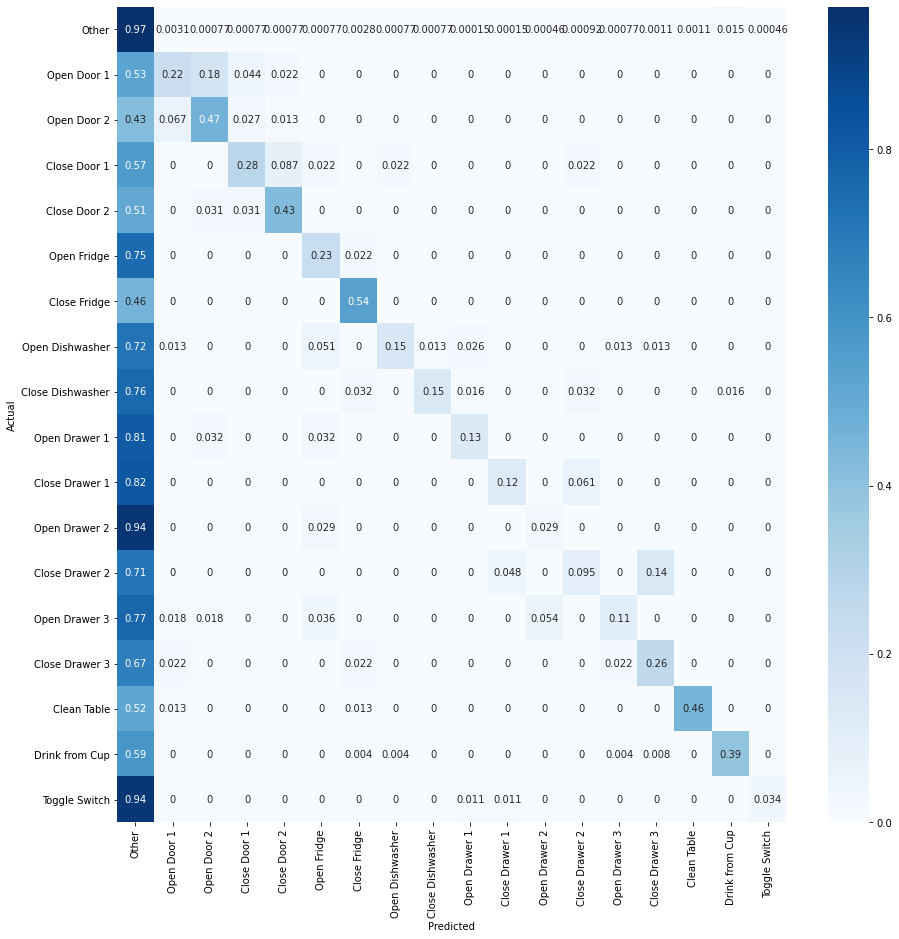

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true, y_pred, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.88      0.97      0.92      6522
     Open Door 1       0.26      0.22      0.24        45
     Open Door 2       0.67      0.47      0.55        75
    Close Door 1       0.54      0.28      0.37        46
    Close Door 2       0.72      0.43      0.54        65
     Open Fridge       0.75      0.23      0.35       183
    Close Fridge       0.71      0.54      0.61       124
 Open Dishwasher       0.63      0.15      0.25        78
Close Dishwasher       0.60      0.15      0.23        62
   Open Drawer 1       0.44      0.13      0.20        31
  Close Drawer 1       0.57      0.12      0.20        33
   Open Drawer 2       0.14      0.03      0.05        35
  Close Drawer 2       0.15      0.10      0.12        21
   Open Drawer 3       0.43      0.11      0.17        56
  Close Drawer 3       0.48      0.26      0.34        46
     Clean Table       0.84      0.46      0.59        79
  Drink from 

In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true, y_prob, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.896
One-vs-Rest ROC AUC scores: 0.878


Test set with noise 

In [ ]:
# Performance on test set with noise
y_true_n = y_test_noise_segmented_original

val_steps = int(np.ceil(len(x_test_noise_segmented)/batch_size))
y_prob_n=model_CNN_RNN.predict(x_test_noise_segmented, batch_size=64, steps=val_steps)
y_pred_n=np.argmax(y_prob_n,axis=1)
precision, recall, fscore_opp_man_low_n, _= metrics.precision_recall_fscore_support(y_true_n, y_pred_n, average='weighted',zero_division='warn')
print('precision = {:.3}\n recall = {:.3}\n fscore = {:.3}'.format(precision,recall,fscore_opp_man_low_n) )

precision = 0.813
 recall = 0.843
 fscore = 0.812


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


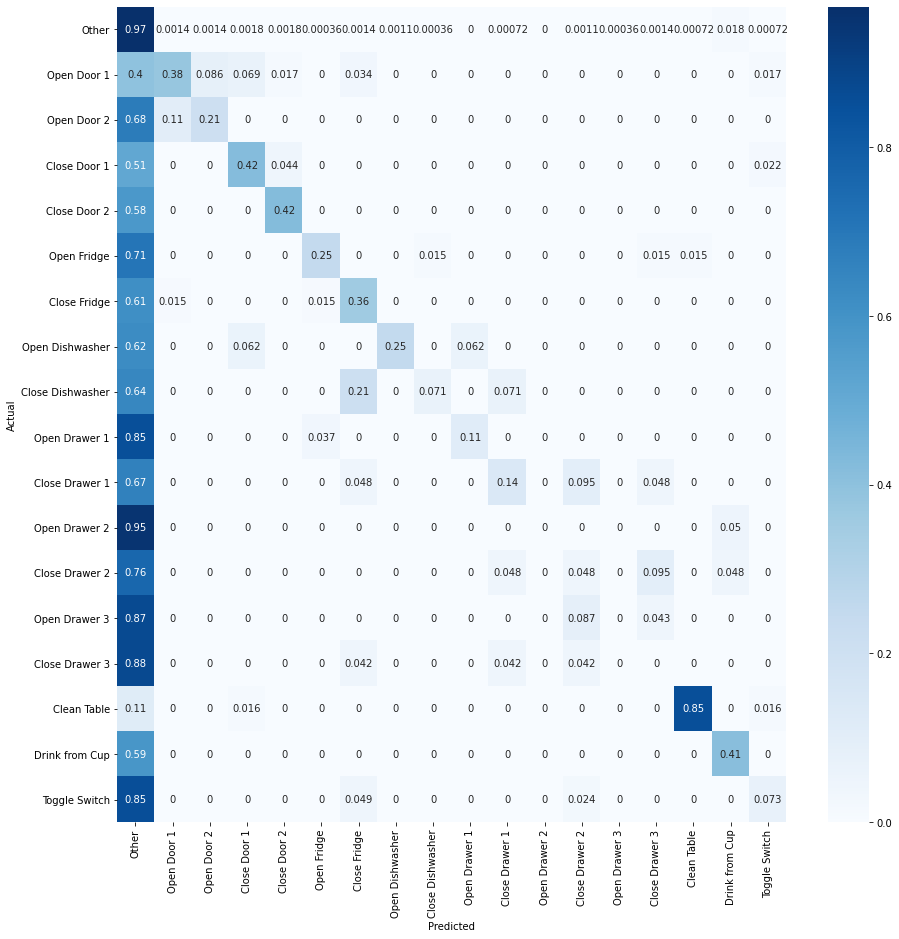

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_true_n, y_pred_n, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label, yticklabels=id2label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
report = metrics.classification_report(y_true_n, y_pred_n, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.87      0.97      0.92      2771
     Open Door 1       0.71      0.38      0.49        58
     Open Door 2       0.47      0.21      0.29        38
    Close Door 1       0.63      0.42      0.51        45
    Close Door 2       0.58      0.42      0.49        26
     Open Fridge       0.84      0.25      0.38        65
    Close Fridge       0.65      0.36      0.46        67
 Open Dishwasher       0.57      0.25      0.35        16
Close Dishwasher       0.33      0.07      0.12        14
   Open Drawer 1       0.75      0.11      0.19        27
  Close Drawer 1       0.38      0.14      0.21        21
   Open Drawer 2       0.00      0.00      0.00        20
  Close Drawer 2       0.10      0.05      0.06        21
   Open Drawer 3       0.00      0.00      0.00        23
  Close Drawer 3       0.00      0.00      0.00        24
     Clean Table       0.95      0.85      0.90        61
  Drink from 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# AUC ROC scores
weighted_roc_auc_ovo = roc_auc_score(y_true_n, y_prob_n, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_n, y_prob_n, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.899
One-vs-Rest ROC AUC scores: 0.889


Performance neglecting Null class


In [ ]:
mask = y_true!=0
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

precision, recall, fscore, _= metrics.precision_recall_fscore_support(y_true_0, y_pred_0, average='weighted',zero_division = 0)
print('precision_without_0 = {:.3}\n recall_without_0 = {:.3}\n fscore_without_0 = {:.3}'.format(precision,recall,fscore) )

precision_without_0 = 0.834
 recall_without_0 = 0.253
 fscore_without_0 = 0.365


In [ ]:
# Classification report
report = metrics.classification_report(y_true_0, y_pred_0, target_names=id2label,zero_division='warn')
print(report)   

                  precision    recall  f1-score   support

           Other       0.00      0.00      0.00         0
     Open Door 1       0.64      0.32      0.43        56
     Open Door 2       0.78      0.37      0.50        95
    Close Door 1       0.61      0.24      0.34        59
    Close Door 2       0.78      0.48      0.59        82
     Open Fridge       0.82      0.22      0.35       224
    Close Fridge       0.84      0.43      0.57       160
 Open Dishwasher       0.68      0.15      0.25       100
Close Dishwasher       0.53      0.11      0.18        76
   Open Drawer 1       0.42      0.13      0.20        38
  Close Drawer 1       0.40      0.09      0.15        44
   Open Drawer 2       0.20      0.03      0.04        40
  Close Drawer 2       0.20      0.07      0.11        27
   Open Drawer 3       0.64      0.14      0.23        66
  Close Drawer 3       0.57      0.21      0.30        58
     Clean Table       0.95      0.43      0.59        98
  Drink from 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# AUC ROC scores
y_prob_0=y_prob[mask,1:]#remove 1st column(class 0)
new_weigths=np.sum(y_prob_0,axis=1).reshape((y_pred_0.shape[0],1))#sum by row
y_prob_0=y_prob_0/new_weigths#divide each element in a row by the sum of the row
weighted_roc_auc_ovo = roc_auc_score(y_true_0, y_prob_0, multi_class="ovo", average="weighted")#ovo=one vs one
weighted_roc_auc_ovr = roc_auc_score(y_true_0, y_prob_0, multi_class="ovr",average="weighted")#ovr=one vs rest
print("One-vs-One ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores: {:.3f}".format(weighted_roc_auc_ovr))

One-vs-One ROC AUC scores: 0.878
One-vs-Rest ROC AUC scores: 0.894


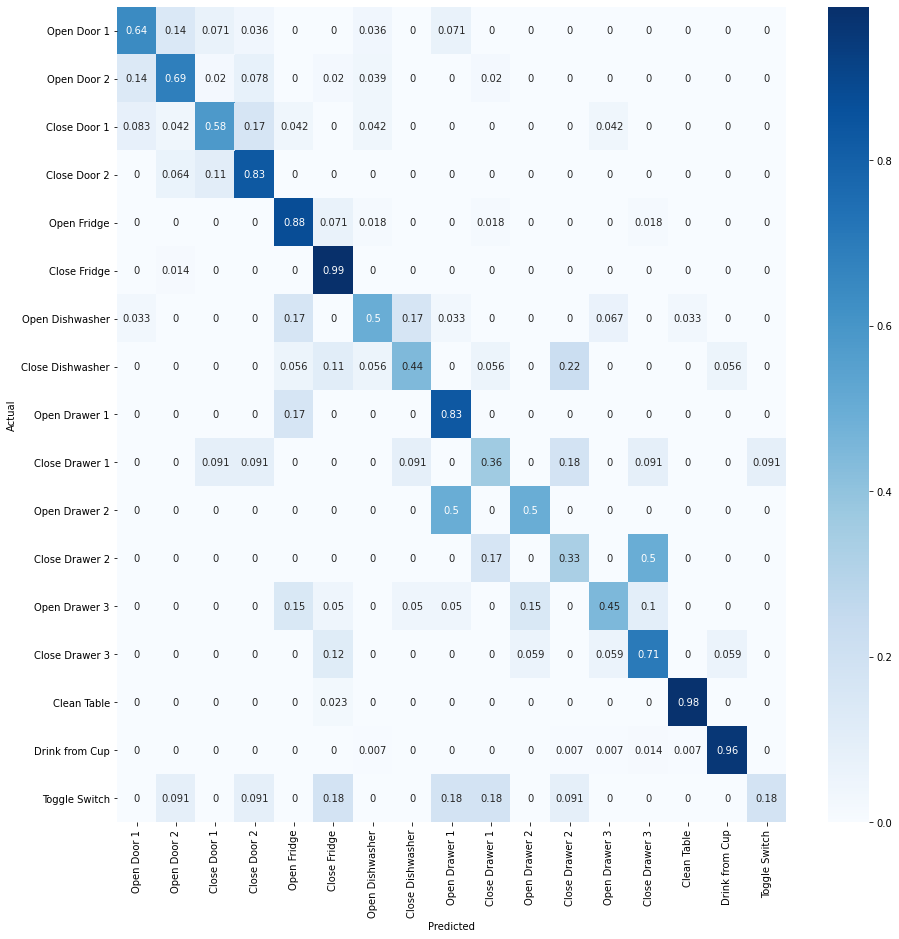

In [ ]:
# Confusion matrix
mask = (np.logical_and(y_true!=0, y_pred!=0))
y_true_0=y_true[mask]
y_pred_0=y_pred[mask]

conf_mat = confusion_matrix(y_true_0, y_pred_0, normalize='true') # row sums to 1
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap=plt.cm.Blues, xticklabels=id2label[1:], yticklabels=id2label[1:])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 6 Comparisons

### 6.1 CNN + RNN vs CNN only

In [ ]:
rnn_comparison = pd.DataFrame(np.array([[fscore_opp, fscore_opp_n, fscore_opp_low, fscore_opp_low_n],
                                             [fscore_opp_c, fscore_opp_c_n, fscore_opp_low_c, fscore_opp_low_c_n]]),
                                    index = ['CNN + RNN', 'CNN'] , columns = ['all IMUs', 'all IMUs noise', 'lower arms', 'lower arms noise']).T
print('CNN + RNN vs only CNN')
rnn_comparison

CNN + RNN vs only CNN


CNN + RNN       CNN
all IMUs           0.880800  0.877342
all IMUs noise     0.868655  0.866804
lower arms         0.862498  0.854364
lower arms noise   0.851476  0.854719

In [ ]:
#to have a first comparison between CNN+RNN vs CNN without considering the noisy test set
#rnn_comparison = pd.DataFrame(np.array([[fscore_opp, fscore_opp_low],
#                                        [fscore_opp_c, fscore_opp_low_c]]),
#                                    index = ['CNN + RNN', 'CNN'] , columns = ['all IMUs', 'lower arms']).T
#print('CNN + RNN vs only CNN')
#rnn_comparison

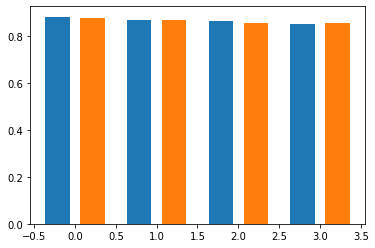

In [ ]:
# This cell is necessary to put the text of the following plot in the right position
bar_width = 0.3
bar1 = plt.bar(np.arange(4) - bar_width/1.4, np.array(rnn_comparison.loc[:,['CNN + RNN']]).flatten(), bar_width)
bar2 = plt.bar(np.arange(4) + bar_width/1.4, np.array(rnn_comparison.loc[:,['CNN']]).flatten(), bar_width)

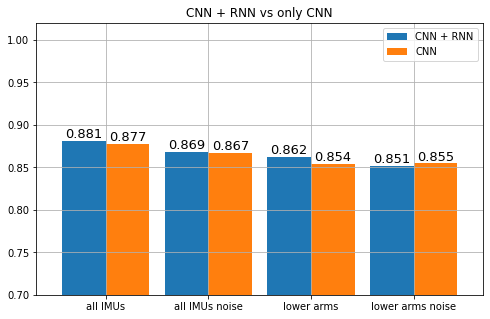

In [ ]:
rnn_comparison.plot.bar(figsize = (8,5), rot = 0, grid=True, ylim = (0.7, 1.02), width = .85)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(height,3), ha='center', va='bottom', fontsize=13, rotation = 0)
_ = plt.title('CNN + RNN vs only CNN') 
fig=plt.gcf()
fig.savefig(datapath + '/models/f1score.png')

The model with CNN + RNN are slightly better than the ones with only CNN. In what follows, we will keep only those with CNN + RNN

### 6.2 Datasets comparison

In [ ]:
rnn_comparison = pd.DataFrame(np.array([[fscore_opp, fscore_opp_low, fscore_opp_man, fscore_opp_man_low],
                                             [fscore_opp_n, fscore_opp_low_n, fscore_opp_man_n, fscore_opp_man_low_n]]),
                                    index = ['test set', 'noise test set'] , columns = ['all IMUs', 'lower arms', 'all IMUs manual', 'lower arms manual']).T
print('Model comparison')
rnn_comparison

Model comparison


test set  noise test set
all IMUs           0.880800        0.868655
lower arms         0.862498        0.851476
all IMUs manual    0.861983        0.845657
lower arms manual  0.824554        0.811662

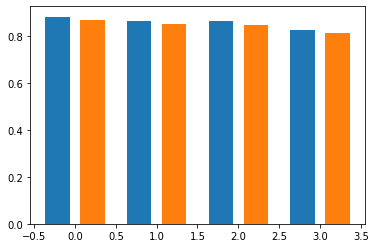

In [ ]:
# This cell is necessary to put the text of the following plot in the right position
bar_width = 0.3
bar1 = plt.bar(np.arange(4) - bar_width/1.4, np.array(rnn_comparison.loc[:,['test set']]).flatten(), bar_width)
bar2 = plt.bar(np.arange(4) + bar_width/1.4, np.array(rnn_comparison.loc[:,['noise test set']]).flatten(), bar_width)

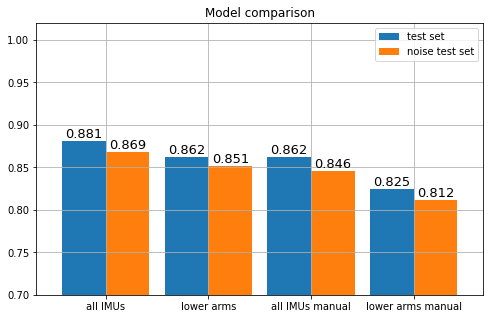

In [ ]:
rnn_comparison.plot.bar(figsize = (8,5), rot = 0, grid=True, ylim = (0.7, 1.02), width = .85)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(height,3), ha='center', va='bottom', fontsize=13, rotation = 0)
_ = plt.title('Model comparison') 
fig=plt.gcf()
fig.savefig(datapath + '/models/noise.png')